# Model building exercise on UCL's automobile dataset with corrupted data.

Here is a quick run-through on creating a linear regression model using two popular variable selection/shrinkage methods (LASSO and Elastic-Net), followed by backward stepwise selection to arrive at a parsimonious model.

DATA SOURCE: https://www.kaggle.com/toramky/automobile-dataset

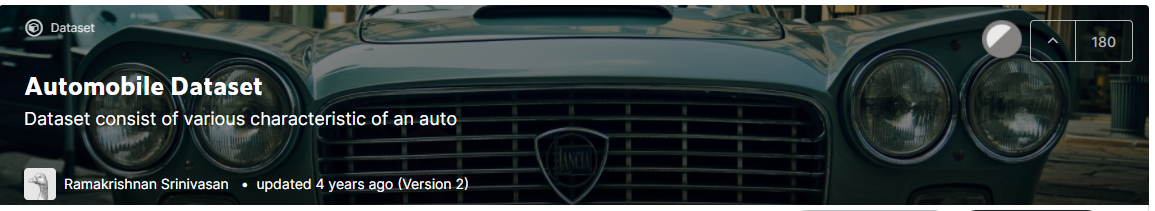

# Dependencies

In [1]:
import pandas as pd
import numpy as np
import os 

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

import statsmodels.api as sm  
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import ElasticNetCV
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import GradientBoostingRegressor

import warnings
warnings.filterwarnings('ignore')

# Definitions

In [2]:
def num_columns(series):
    """
    returns the number of columns in a series or dataframe
    """
    
    try: return series.shape[1]
    except: return 1
    
def make_number(series):
    
    """ this function is used to apply to a column of data to convrt it to a float value.
    It converts the value to a 0 if it is a string that cannot be converted."""
    
    try: return float(series)
    except: return 0

def clean_data(series, make_all_numbers):
    
    """ applies cleaning algorithms to series.     
        make_all_numbers == True makes all values a numerical value. If not a number it converts it to a zero.
    """
    
    if make_all_numbers: 
        series = series.map(make_number) if num_columns(y) == 1 else series.applymap(make_number)
    
    return series

def check_size(X,y):
    if (len(X.columns) < 1)and((len(y.columns)>1)):
        print("This won't work. You can't have more than one column of dependent variables, and you need to include independent variable(s) 'X' in your model.")
    elif(len(X.columns) < 1):
        print("This won't work. You need to include at least one column of values for your independent variable.")
    elif(len(y.columns) < 1):
        print("This won't work. You need one column of values for your independent variable.")        
    else:
        pass

def ols_model_fit(X,y, add_intercept=True):
    
    X = sm.add_constant(X) if add_intercept==True else X
    fitted_ols_model = sm.OLS(y, X).fit()
    
    return fitted_ols_model

def get_vifs(X, add_intercept=True):
    
    X = sm.add_constant(X) if add_intercept==True else X

    if ((X.columns[0] == 'const')and(len(X.columns)==2)):
        vifs = [np.nan, np.nan]
    
    elif (len(X.columns)==1):
        vifs = [np.nan]
        
    elif X.columns[0] == 'const':
        data = X.drop(columns = ['const']).copy()
        vifs = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
        vifs = [np.nan]+vifs
    else:
        data = X.copy()
        vifs = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
    
    vifs = pd.Series(vifs, index = X.columns.to_list(), name = 'VIF')
    
    return vifs

def get_summary_of_fit(X,y,fitted_ols_model, add_intercept):
    
    rsquared = fitted_ols_model.rsquared
    rsquared_adj = fitted_ols_model.rsquared_adj
    root_mean_square_error = (
        (mean_squared_error(y,fitted_ols_model.predict(sm.add_constant(X))))*0.5 if add_intercept==True 
        else (mean_squared_error(y,fitted_ols_model.predict(X)))*0.5
    )
    mean_of_response = round(y.mean(),5)
    num_observations = fitted_ols_model.nobs
    
    bic = fitted_ols_model.bic
    aic = fitted_ols_model.aic

    summary_of_fit_dict = {
        'RSquare':rsquared,
        'RSquare Adj':rsquared_adj,
        'Root Mean Square Error':root_mean_square_error,
        'AIC':aic,    
        'BIC':bic,
        'Mean of Response':mean_of_response,
        'Observations (or Sum Wgts)':num_observations
    }

    summary_of_fit = pd.DataFrame(
        {
        ' ':list(summary_of_fit_dict.keys()),
        '':list(summary_of_fit_dict.values())
        }
    )

    return summary_of_fit, summary_of_fit_dict

def beautify_summary_of_fit(summary_of_fit):
    
    summary_of_fit[''] = round(summary_of_fit[''],6)
    summary_of_fit= summary_of_fit.astype(str)
    
    summary_of_fit[''].iloc[-1] = summary_of_fit[''].iloc[-1].replace('.0','')

    s = summary_of_fit.style.set_properties(**{'text-align': 'left'})
    s = s.set_caption('Summary of Fit').set_table_styles([
        {
        'selector': 'caption',
        'props': [('color', 'darkorange'),('font-size', '18px'),('font-weight:','bold')]
        }
    ])
    
    return s

def get_anova(fitted_ols_model):
    
    model_mse = round(fitted_ols_model.mse_model,3)
    resid_mse = round(fitted_ols_model.mse_resid,3)
    total_mse = round(fitted_ols_model.mse_total,3)

    model_df = int(fitted_ols_model.df_model)
    resid_df = int(fitted_ols_model.df_resid)
    total_df = int(model_df+resid_df)

    model_ss = round(model_mse*model_df,3)
    error_ss = round(resid_mse*resid_df,3)
    total_ss = round(total_mse*total_df,3)

    f_ratio = round(fitted_ols_model.fvalue,4)
    prob_f = round(fitted_ols_model.f_pvalue,4)

    source = ['Model','Error','C.Total']
    df = [model_df, resid_df, total_df]
    ss = [model_ss, error_ss, total_ss]
    ms = [model_ss, error_ss, '']
    fr = [f_ratio, 'Prob > F', prob_f]

    analysis_of_variance_dict = {
        'Source':source,
        'Deg of Freedom':df,
        'Sum of Squares':ss,
        'Mean Square':ms,
        'F Ratio':fr
    }
    
    analysis_of_variance = pd.DataFrame(analysis_of_variance_dict)
    
    return analysis_of_variance, analysis_of_variance_dict

def reformat_p_values(pvalue):

    if float(pvalue) < 0.0001:
        new_pvalue = '<.0001*'
        
    elif ((float(pvalue) >= 0.0001)and(float(pvalue) < 0.05)):
        pvalue = round(pvalue,4)
        new_pvalue = '{}*'.format(pvalue)
        
    else: 
        pvalue = round(pvalue,4)
        new_pvalue = str(pvalue)

    return new_pvalue

def color_p_values(val):
    
    if '*' in val:
        val = float(val.replace('<','').replace('*',''))
        if val < 0.01:
            color = 'darkorange'
        elif ((val >= 0.01)and(val < 0.05)):
            color = 'red'
        else:
            color = 'black'
        return 'color: %s' % color
    
    else:
        return 'color: black'  
def beautify_analysis_of_variance(analysis_of_variance):
    
    def reformat_p_values(pvalue):

        if float(pvalue) < 0.0001:
            new_pvalue = '<.0001*'

        elif ((float(pvalue) >= 0.0001)and(float(pvalue) < 0.05)):
            pvalue = round(pvalue,4)
            new_pvalue = '{}*'.format(pvalue)

        else: 
            pvalue = round(pvalue,4)
            new_pvalue = str(pvalue)

        return new_pvalue
    
    def color_p_values(val):
    
        if '*' in val:
            val = float(val.replace('<','').replace('*',''))
            if val < 0.01:
                color = 'darkorange'
            elif ((val >= 0.01)and(val < 0.05)):
                color = 'red'
            else:
                color = 'black'
            return 'color: %s' % color

        else:
            return 'color: black'  
    
    
    def bold_f_val(val):
        if val == 'Prob > F':
            return 'font-weight: bold'
        else:
            return 'font-weight: normal'
    
    pvalue=analysis_of_variance.iloc[2,4]
    new_pvalue = reformat_p_values(pvalue)
    analysis_of_variance.iloc[2,4] = new_pvalue
    analysis_of_variance['Sum of Squares'] = analysis_of_variance['Sum of Squares'].astype(str)
    analysis_of_variance['Mean Square'] = analysis_of_variance['Mean Square'].astype(str)
    analysis_of_variance['F Ratio'] = analysis_of_variance['F Ratio'].astype(str)
    s = analysis_of_variance.style.set_properties(**{'text-align': 'left'})
    s = s.applymap(color_p_values, subset = ['F Ratio'])
    s = s.applymap(bold_f_val, subset = ['F Ratio'])
    s = s.set_caption('Analysis of Variance').set_table_styles([
        {
        'selector': 'caption',
        'props': [('color', 'darkorange'),('font-size', '18px'),('font-weight:','bold')]
        }
    ])
    
    return s

def get_parameter_estimates(X,fitted_ols_model, add_intercept):

    terms = fitted_ols_model.params.index.to_list()
    estimates = fitted_ols_model.params.to_list()
    standard_errors = fitted_ols_model.bse.to_list()
    t_ratios = fitted_ols_model.tvalues.to_list()
    p_values = fitted_ols_model.pvalues.to_list()
    lower_95 = fitted_ols_model.conf_int(alpha = 0.5, cols = None)[0].to_list()
    upper_95 = fitted_ols_model.conf_int(alpha = 0.5, cols = None)[1].to_list()
    vifs = get_vifs(X, add_intercept).to_list()

    parameter_estimates_dict = {
        'Term':terms,
        'Estimate':estimates,
        'Std Error':standard_errors,
        't Ratio':t_ratios,
        'Prob > |t|':p_values,
        'Lower 95%':lower_95,
        'Upper 95%':upper_95,
        'VIF':vifs
    }

    parameter_estimates = pd.DataFrame(parameter_estimates_dict)
    
    return parameter_estimates, parameter_estimates_dict 

def reformat_vifs(vif):
    
    vif = round(vif,4)
    
    if str(vif) == 'nan':
        new_vif = '.'
        
    elif vif <=10:
        new_vif = '{}*'.format(vif)
        
    else: 
        new_vif = str(vif)
        
    return new_vif

def color_vifs(val):

    if '*' in val:
        val = float(val.replace('*',''))
        if val <=5.0:
            color = 'darkorange'
        elif ((val > 5.0)and(val <=10.0)):
            color = 'red'
        else:
            color = 'black'
        return 'color: %s' % color

    else:
        return 'color: black' 
    
def beautify_parameter_estimates(parameter_estimates):
    
    def reformat_p_values(pvalue):

        if float(pvalue) < 0.0001:
            new_pvalue = '<.0001*'

        elif ((float(pvalue) >= 0.0001)and(float(pvalue) < 0.05)):
            pvalue = round(pvalue,4)
            new_pvalue = '{}*'.format(pvalue)

        else: 
            pvalue = round(pvalue,4)
            new_pvalue = str(pvalue)

        return new_pvalue

    def color_p_values(val):

        if '*' in val:
            val = float(val.replace('<','').replace('*',''))
            if val < 0.01:
                color = 'darkorange'
            elif ((val >= 0.01)and(val < 0.05)):
                color = 'red'
            else:
                color = 'black'
            return 'color: %s' % color

        else:
            return 'color: black' 

    def reformat_vifs(vif):

        vif = round(vif,4)

        if str(vif) == 'nan':
            new_vif = '.'

        elif vif <=10:
            new_vif = '{}*'.format(vif)

        else: 
            new_vif = str(vif)

        return new_vif


    def color_vifs(val):

        if '*' in val:
            val = float(val.replace('*',''))
            if val <=5.0:
                color = 'darkorange'
            elif ((val > 5.0)and(val <=10.0)):
                color = 'red'
            else:
                color = 'black'
            return 'color: %s' % color

        else:
            return 'color: black' 
    
    parameters_beautified = parameter_estimates.copy()

    parameters_beautified['Estimate'] = round(parameters_beautified['Estimate'],5)
    parameters_beautified['Std Error'] = round(parameters_beautified['Std Error'],5)
    parameters_beautified['t Ratio'] = round(parameters_beautified['t Ratio'],2)
    parameters_beautified['Prob > |t|'] = parameters_beautified['Prob > |t|'].apply(reformat_p_values)
    parameters_beautified['Lower 95%'] = round(parameters_beautified['Lower 95%'],5)
    parameters_beautified['Upper 95%'] = round(parameters_beautified['Upper 95%'],5)
    parameters_beautified['VIF'] = parameters_beautified['VIF'].apply(reformat_vifs)
    parameters_beautified = parameters_beautified.astype(str)
    parameters_beautified['Term'] = ['Intercept' if term == 'const' else term for term in parameters_beautified['Term'].to_list()]
    s = parameters_beautified.style.set_properties(**{'text-align': 'left'})
    s = s.applymap(color_p_values, subset = ['Prob > |t|'])
    s = s.applymap(color_vifs, subset = ['VIF'])
    s = s.set_caption('Parameter Estimates').set_table_styles([
        {
        'selector': 'caption',
        'props': [('color', 'darkorange'),('font-size', '18px'),('font-weight:','bold')]
        }
    ])
    return(s)

def get_results(y, fitted_ols_model):

    influence = fitted_ols_model.get_influence()                        
    results = pd.DataFrame()
    results['y'] = y                                                         # target variable
    results['yhat'] = fitted_ols_model.predict()                             # predictions
    results['residuals'] = results['y']-results['yhat']                      # residuals
    results['studentized_residuals'] = influence.resid_studentized_external  # studentized residuals
    results['cooks_distance']= influence.cooks_distance[0]                   # cook's distance

    return results

def make_diagnostic_plots(y, fitted_ols_model):
    
    results = get_results(y, fitted_ols_model)

    title = pd.DataFrame()
    s = title.style.set_properties(**{'text-align': 'left'})
    s = s.set_caption('Diagnostic Plots').set_table_styles([
        {
        'selector': 'caption',
        'props': [('color', 'darkorange'),('font-size', '18px'),('font-weight:','bold')]
        }
    ])
    display(s)

    with plt.style.context('ggplot'):

        fig = plt.figure(figsize = (8,7), dpi=200)
        #fig.suptitle('Diagnostic Plots', color = 'orange', fontsize=16, horizontalalignment = 'center')
        
        ax1 = plt.subplot2grid((4, 4), (0, 0), rowspan=2, colspan=2)
        ax2 = plt.subplot2grid((4, 4), (0, 2), rowspan=2, colspan=2)
        ax3 = plt.subplot2grid((4, 4), (2, 0), rowspan=2, colspan=3)
        ax4 = plt.subplot2grid((4, 4), (2, 3), rowspan=2, colspan=1)

        fmt = '{x:,.0f}'
        tick = ticker.StrMethodFormatter(fmt)
        residuals_limit = max(min(results.studentized_residuals), max(results.studentized_residuals))

        ax1.set_title('\nActual by Predicted Plot\n\n',fontsize = 10, color = 'darkorange')
        ax1.scatter(results.yhat, 
                    results.y, 
                    s = 20, 
                    color = 'black', 
                    facecolors='burlywood', 
                    edgecolors='black', 
                    marker = 'o')
        ax1.plot(results.yhat, results.yhat, color = 'r', linewidth = 0.80)
        ax1.ticklabel_format(useOffset=False, style='plain')
        ax1.yaxis.set_major_formatter(tick) 
        ax1.xaxis.set_major_formatter(tick) 
        ax1.set_xlabel('Predicted',fontsize = 10)
        ax1.set_ylabel('Actual',fontsize = 10)
        ax1.tick_params(axis='x', rotation=35)

        ax2.set_title("\nStudentized Residuals vs.\n Cook's Distance\n", fontsize = 10, color = 'darkorange')
        ax2.scatter(results.cooks_distance, 
                    results.studentized_residuals, 
                    s = 10, 
                    color = 'black', 
                    facecolors='lightblue', 
                    edgecolors='black', 
                    marker = 'o')
        ax2.axvline(x=0.5, color = 'salmon', linestyle = '--', label = "Cook's D = 0.5", linewidth = 1.5)
        ax2.axvline(x=1.0, color = 'salmon', linestyle = '-', label = "Cook's D = 1.0", linewidth = 1.5)
        ax2.set_xlabel("Cook's Distance",fontsize = 10)
        ax2.set_ylabel('\nStudentized Residuals',fontsize = 10)
        ax2.set_ylim(-residuals_limit*1.10, residuals_limit*1.10)
        ax2.set_xlim(-0.25, 3)
        ax2.tick_params(axis='x', rotation=35)
        ax2.legend(loc = 5)

        ax3.set_title('\nStudentized Residuals vs. \nPredicted\n',fontsize = 10, color = 'darkorange')
        ax3.scatter(results.yhat, 
                    results.studentized_residuals, 
                    s = 10, 
                    color = 'black', 
                    facecolors='lightblue', 
                    edgecolors='black', 
                    marker = 'o')
        ax3.axhline(y=0, color = 'salmon', linestyle = '--', label = 'Zero Line')
        ax3.xaxis.set_major_formatter(tick) 
        ax3.set_xlabel('Predicted',fontsize = 10)
        ax3.set_ylabel('\nStudentized Residuals',fontsize = 10)
        ax3.set_ylim(-residuals_limit*1.10, residuals_limit*1.10)
        ax3.tick_params(axis='x', rotation=35)
        ax3.legend(loc = 2)

        ax4.set_title('Distribution\n\n', fontsize = 10, color = 'darkorange')
        ax4.hist(results.studentized_residuals, 
                 histtype='stepfilled', 
                 color = 'burlywood', 
                 alpha = 0.5, 
                 edgecolor='black', 
                 linewidth = 1, 
                 bins = 20, 
                 orientation = 'horizontal')
        ax4.axhline(y=0, color = 'salmon', linestyle = '--')
        ax4.xaxis.set_major_formatter(tick) 
        ax4.set_ylim(-residuals_limit*1.10, residuals_limit*1.10)
        ax4.tick_params(axis='x')

        plt.tight_layout()
        plt.show()
        
def make_leverage_plots(fitted_ols_model):
    
    title = pd.DataFrame()
    s = title.style.set_properties(**{'text-align': 'left'})
    s = s.set_caption('Leverage Plots').set_table_styles([
        {
        'selector': 'caption',
        'props': [('color', 'darkorange'),('font-size', '18px'),('font-weight:','bold')]
        }
    ])
    display(s)

    num_params = len(fitted_ols_model.params)
    rows = (num_params//3 + 1) if ((num_params/3-num_params//3) > 0) else (num_params//3)
    figure_length = rows*14
    fig = plt.figure(figsize=(14,figure_length/3))
    fig = sm.graphics.plot_partregress_grid(fitted_ols_model, grid = (4,3), fig = fig)
    fig.tight_layout(pad=5)
    
def ols_regression(
    y,
    X,
    add_intercept=True,
    display_summary_of_fit=True,
    display_analysis_of_variance=True,
    display_parameter_estimates=True,
    display_diagnostic_plots=True,
    display_leverage_plots=False,
    display_marginal_model_plots=False,
    return_data=False
):
    y = y.copy()
    X = X.copy()
    
    fitted_ols_model = ols_model_fit(X,y, add_intercept=add_intercept)
    results = get_results(y, fitted_ols_model)
    yhat = results['yhat']
    residuals = results['residuals']
    studentized_residuals = results['studentized_residuals']
    cooks_distance = results['cooks_distance']
    
    if display_summary_of_fit:
        summary_of_fit = get_summary_of_fit(X,y,fitted_ols_model, add_intercept=add_intercept)[0]
        display(beautify_summary_of_fit(summary_of_fit))
                
    if display_analysis_of_variance:
        analysis_of_variance=get_anova(fitted_ols_model)[0]
        display(beautify_analysis_of_variance(analysis_of_variance))
        
    if display_parameter_estimates:
        parameter_estimates = get_parameter_estimates(X,fitted_ols_model, add_intercept=add_intercept)[0]
        display(beautify_parameter_estimates(parameter_estimates))
        
    if display_diagnostic_plots:
        make_diagnostic_plots(y, fitted_ols_model)
    
    if display_marginal_model_plots:
        #marginal_model_plots(results,X, show_actuals = True, show_predicteds = True, smoothness = 0.5)
        marginal_model_plots(y, yhat, X)
    if display_leverage_plots:
        make_leverage_plots(fitted_ols_model)
        
    if return_data:
        return results, fitted_ols_model
    
    
def smooth_lowess(y_series, lowess_window_length = 100, smoothing_iterations = 2):
    
    """
    This is a customized LOWESS (locally weighted scatterplot smoothing) implementation that "smooths" a discrete data set.  
    In the LOWESS, each smoothed value is given by a weighted linear least squares regression over the span.  
    
    This implementation uses an upstream process to account for missing and zero values and data series that can't have negative values.  
    It also allows for a finite window length above 3, rather than a percentage of the total dataset.   
    
    It uses the statstmodels implementation:
    statsmodels.nonparametric.smoothers_lowess.lowess
    source: https://www.statsmodels.org/stable/generated/statsmodels.nonparametric.smoothers_lowess.lowess.html
    
    Params:
    
    y_series:  Pandas series of discrete points as the inputs variable y
    lowess_window_length:  This is the window length passed smoothed through the data set. It cannot be less than 3. 
    smoothing_iterations: number of times to iterate the smoother
    
    Returns:
    yhat: a Pandas series of the smoothed values.
    """
    
    import statsmodels.api as sm
    
    y_series = y_series.fillna(0) # replace all NaN values with 0
    x_series = list(np.arange(0,len(y_series),1))
    
    window = lowess_window_length/len(x_series)
    
    
    lowess = sm.nonparametric.lowess
    smooth = lowess(y_series, x_series, frac = window, it = smoothing_iterations)
    index, yhat = np.transpose(smooth)
    
    return yhat

def marginal_model_plots(y, yhat, X, smoothness = 0.5, figsize = (12, 4), cols = 3):
    
    # select lowess window length
    lowess_window_length = len(X)//2
    
    # screen out binary("dummy") columns
    features = []
    
    for col in X.columns:
    
        if X[col].nunique() > 2:       
            features.append(col)
    
    # assign data and calculate the number of rows
    X = X[features]  
    df = X.copy()
    rows = len(features) // cols + 1
    
    display_cols = (cols-1)*6
    display_rows = rows*4
    
    figsize = (display_cols, display_rows)
    
    # smooth target and predictor variables
    y_smooth = smooth_lowess(y, lowess_window_length = lowess_window_length)
    yhat_smooth = smooth_lowess(yhat, lowess_window_length = lowess_window_length)
    
    def trim_axs(axs, N):
        """
        Reduce *axs* to *N* Axes. All further Axes are removed from the figure.
        """
        axs = axs.flat

        for ax in axs[N:]:
            ax.remove()
        return axs[:N]

    axs = plt.figure(figsize=figsize, constrained_layout=True).subplots(rows, cols)
    axs = trim_axs(axs, len(features))
    for ax, feature in zip(axs, features):
        
        ###### ADDED TO ACCOUNT FOR REACTION TERMS
        values = X[feature].loc[X[feature]>0]
        ######
        
        lowess_window_length = len(values)//2
        
        smoothed_values = smooth_lowess(values, lowess_window_length = lowess_window_length)
        x_max = X[feature].max()
        x_min = X[feature].min()
        y_max = y.max()
        y_min = y.min()  
        
        data = pd.DataFrame({'x':values,'y':y,'yhat':yhat}).sort_values('x').reset_index(drop = True)
        
        
        
        data['y_smooth'] =  smooth_lowess(data['y'], 
                                          lowess_window_length = lowess_window_length, 
                                          smoothing_iterations = 5)
        data['yhat_smooth'] =  smooth_lowess(data['yhat'], 
                                             lowess_window_length = lowess_window_length, 
                                             smoothing_iterations = 5)
        data['x_smooth'] = smooth_lowess(data['x'], 
                                         lowess_window_length = lowess_window_length, 
                                         smoothing_iterations = 5)
        
        values = data['x']
        smoothed_values = data['x_smooth']
        x_max = X[feature].max()
        x_min = X[feature].min()
        y_max = y.max()
        y_min = y.min()    
    
        ax.set_title(feature, fontsize = 15)
        ax.scatter(data['x'], data['y'], s = 10, facecolors='none', edgecolors='black', linewidth=0.5)
        ax.scatter(data['x'], data['yhat'], s = 10, facecolors='none', edgecolors='blue', linewidth=0.5)

        ax.plot(data['x_smooth'], data['y_smooth'], color = 'black', linestyle = '-', linewidth = 4.5, alpha = 0.55, label = 'Actual')
        ax.plot(data['x_smooth'], data['yhat_smooth'], color = 'blue', linestyle = '--', linewidth = 4.5, alpha = 0.55, label = 'Predicted')    

        ax.set_ylabel('y',  rotation=0, fontsize = 20, labelpad=20)

        ax.set_xlim(x_min,x_max)
        ax.set_ylim(y_min,y_max)
        ax.legend(fontsize = 10, loc = 1)    
            
def get_wls_model(X, y, w, add_intercept=True):
    
    X = sm.add_constant(X) if add_intercept==True else X
    wls_model = sm.WLS(y, X, weights = w)
    fitted_wls_model = sm.WLS(y, X, weights = w).fit()
    
    return wls_model, fitted_wls_model

def get_wls_results(y, wls_model, fitted_wls_model):
    
    #fitted_wls_model = wls_model.fit()
    
    res = sm.OLS(wls_model.wendog, wls_model.wexog).fit()
    influence = res.get_influence()
    
                       
    results = pd.DataFrame()
    results['y'] = y                                                         # target variable
    results['yhat'] = fitted_wls_model.predict()                             # predictions
    results['residuals'] = results['y']-results['yhat']                      # residuals
    results['studentized_residuals'] = influence.resid_studentized_external  # studentized residuals
    results['cooks_distance']= influence.cooks_distance[0]                   # cook's distance

    return results

def make_wls_diagnostic_plots(y, wls_model, fitted_wls_model):
    
    results = get_wls_results(y, wls_model, fitted_wls_model)

    title = pd.DataFrame()
    s = title.style.set_properties(**{'text-align': 'left'})
    s = s.set_caption('Diagnostic Plots').set_table_styles([
        {
        'selector': 'caption',
        'props': [('color', 'darkorange'),('font-size', '18px'),('font-weight:','bold')]
        }
    ])
    display(s)

    with plt.style.context('ggplot'):

        fig = plt.figure(figsize = (8,7), dpi=200)
        #fig.suptitle('Diagnostic Plots', color = 'orange', fontsize=16, horizontalalignment = 'center')
        
        ax1 = plt.subplot2grid((4, 4), (0, 0), rowspan=2, colspan=2)
        ax2 = plt.subplot2grid((4, 4), (0, 2), rowspan=2, colspan=2)
        ax3 = plt.subplot2grid((4, 4), (2, 0), rowspan=2, colspan=3)
        ax4 = plt.subplot2grid((4, 4), (2, 3), rowspan=2, colspan=1)

        fmt = '{x:,.0f}'
        tick = ticker.StrMethodFormatter(fmt)
        residuals_limit = max(min(results.studentized_residuals), max(results.studentized_residuals))

        ax1.set_title('\nActual by Predicted Plot\n\n',fontsize = 10, color = 'darkorange')
        ax1.scatter(results.yhat, 
                    results.y, 
                    s = 20, 
                    color = 'black', 
                    facecolors='burlywood', 
                    edgecolors='black', 
                    marker = 'o')
        ax1.plot(results.yhat, results.yhat, color = 'r', linewidth = 0.80)
        ax1.ticklabel_format(useOffset=False, style='plain')
        ax1.yaxis.set_major_formatter(tick) 
        ax1.xaxis.set_major_formatter(tick) 
        ax1.set_xlabel('Predicted',fontsize = 10)
        ax1.set_ylabel('Actual',fontsize = 10)
        ax1.tick_params(axis='x', rotation=35)

        ax2.set_title("\nStudentized Residuals vs.\n Cook's Distance\n", fontsize = 10, color = 'darkorange')
        ax2.scatter(results.cooks_distance, 
                    results.studentized_residuals, 
                    s = 20, 
                    color = 'black', 
                    facecolors='burlywood', 
                    edgecolors='black', 
                    marker = 'o')
        ax2.axvline(x=0.5, color = 'salmon', linestyle = '--', label = "Cook's D = 0.5", linewidth = 1.5)
        ax2.axvline(x=1.0, color = 'salmon', linestyle = '-', label = "Cook's D = 1.0", linewidth = 1.5)
        ax2.set_xlabel("Cook's Distance",fontsize = 10)
        ax2.set_ylabel('\nStudentized Residuals',fontsize = 10)
        ax2.set_ylim(-residuals_limit*1.10, residuals_limit*1.10)
        ax2.tick_params(axis='x', rotation=35)
        ax2.legend(loc = 5)

        ax3.set_title('\nStudentized Residuals vs. \nPredicted\n',fontsize = 10, color = 'darkorange')
        ax3.scatter(results.yhat, 
                    results.studentized_residuals, 
                    s = 20, 
                    color = 'black', 
                    facecolors='burlywood', 
                    edgecolors='black', 
                    marker = 'o')
        ax3.axhline(y=0, color = 'salmon', linestyle = '--', label = 'Zero Line')
        ax3.xaxis.set_major_formatter(tick) 
        ax3.set_xlabel('Predicted',fontsize = 10)
        ax3.set_ylabel('\nStudentized Residuals',fontsize = 10)
        ax3.set_ylim(-residuals_limit*1.10, residuals_limit*1.10)
        ax3.tick_params(axis='x', rotation=35)
        ax3.legend(loc = 2)

        ax4.set_title('Distribution\n\n', fontsize = 10, color = 'darkorange')
        ax4.hist(results.studentized_residuals, 
                 histtype='stepfilled', 
                 color = 'burlywood', 
                 alpha = 0.5, 
                 edgecolor='black', 
                 linewidth = 1, 
                 bins = 20, 
                 orientation = 'horizontal')
        ax4.axhline(y=0, color = 'salmon', linestyle = '--')
        ax4.xaxis.set_major_formatter(tick) 
        ax4.set_ylim(-residuals_limit*1.10, residuals_limit*1.10)
        ax4.tick_params(axis='x')

        plt.tight_layout()
        plt.show()
        
def wls_regression(
    y,
    X,
    w,
    add_intercept=True,
    display_summary_of_fit=True,
    display_analysis_of_variance=True,
    display_parameter_estimates=True,
    display_diagnostic_plots=True,
    display_leverage_plots=False,
    display_marginal_model_plots=False,
    return_data=False
):
    y = y.copy()
    w = w.copy()
    X = X.copy()

    wls_model, fitted_wls_model = get_wls_model(X, y, w, add_intercept=add_intercept)
    results = get_wls_results(y, wls_model, fitted_wls_model)

    yhat = results['yhat']
    residuals = results['residuals']
    studentized_residuals = results['studentized_residuals']
    cooks_distance = results['cooks_distance']

    if display_summary_of_fit:
        summary_of_fit = get_summary_of_fit(X,y,fitted_wls_model, add_intercept=add_intercept)[0]
        display(beautify_summary_of_fit(summary_of_fit))

    if display_analysis_of_variance:
        analysis_of_variance=get_anova(fitted_wls_model)[0]
        display(beautify_analysis_of_variance(analysis_of_variance))

    if display_parameter_estimates:
        parameter_estimates = get_parameter_estimates(X,fitted_wls_model, add_intercept=add_intercept)[0]
        parameters_beautified = beautify_parameter_estimates(parameter_estimates)
        display(parameters_beautified)

    if display_diagnostic_plots:
        make_wls_diagnostic_plots(y, wls_model, fitted_wls_model)

    if display_marginal_model_plots:
        #marginal_model_plots(results,X, show_actuals = True, show_predicteds = True, smoothness = 0.5)
        marginal_model_plots(y, yhat, X)

    if display_leverage_plots:
        make_leverage_plots(fitted_wls_model)

    if return_data:
        return results, fitted_wls_model

def get_fitted_wls_model(X, y, w, add_intercept=True):
    
    X = sm.add_constant(X) if add_intercept==True else X
    fitted_wls_model = sm.WLS(y, X, weights = w).fit()
    
    return fitted_wls_model

def get_metrics(fitted_wls_model):
    
    pvalues = fitted_wls_model.pvalues
    llf = fitted_wls_model.llf
    nobs = fitted_wls_model.nobs
    df_modelwc = len(pvalues)
    aic = fitted_wls_model.aic
    bic = fitted_wls_model.bic
    aicc = sm.tools.eval_measures.aicc(llf, nobs, df_modelwc)
    rsquared_adj = fitted_wls_model.rsquared_adj
    
    return aic, bic, aicc, rsquared_adj 

def forward_remove_next_feature(X, y, w, add_intercept=True):
    
    fitted_wls_model = get_fitted_wls_model(X, y, w, add_intercept=True)
    df = pd.DataFrame(fitted_wls_model.pvalues)
    df = pd.DataFrame(fitted_wls_model.pvalues).sort_values(by = 0, ascending = False)
    df = df.loc[df.index != 'const']
    remove_feature = df.index[0]
    sig_prob = df[0][0]
    #display(df)
    return sig_prob, remove_feature

def forward_backward_selection(y, 
                               X, 
                               w=False, 
                               method = 'fit_backward', 
                               stopping_rule = 'bic'):
    
    # if w is false, then adjust the all models so it works like a an OLS, not a WLS
    
    if w == False:
        
        X['weight'] = 1
        w = X['weight']
        X = X.drop(columns = 'weight')
        
    original_X = X.copy()
    
    if method == 'fit_backward':
        
        if stopping_rule == 'bic': stopping_rule = 'BIC'
        elif stopping_rule == 'aic': stopping_rule = 'AIC'
        elif stopping_rule == 'aicc': stopping_rule = 'AICc'          
        else: 
            print('Stopping rule not specifide.')
            return 
            
    features_list = X.columns.to_list()
    remove_from_features_list = X.columns.to_list()

    step_history_list = []
    remaining_columns_list = []
    sig_prob_list = []
    aic_list = []
    bic_list = []
    aicc_list = []
    rsquared_adj_list = []
    remove_list = ['All']
    action_list = ['Entered']


    for step in range(0,len(X.columns)):

        fitted_wls_model = get_fitted_wls_model(X, y, w, add_intercept=True)
        aic, bic, aicc, rsquared_adj = get_metrics(fitted_wls_model)
        sig_prob, remove_feature = forward_remove_next_feature(X, y, w, add_intercept=True)

        step_history_list.append(step+1)
        remove_list.append(remove_feature)
        action_list.append('Removed')
        remaining_columns_list.append(X.columns.to_list())
        sig_prob_list.append(round(sig_prob,6))
        aic_list.append(aic)
        aicc_list.append(aicc)
        bic_list.append(bic)
        rsquared_adj_list.append(rsquared_adj)

        remove_from_features_list.remove(remove_feature)

        X = X[remove_from_features_list]

    action_list  = action_list[0:-1]
    remove_list  = remove_list[0:-1]

    step_history_dict = {
        'Step': step_history_list,
        'Parameter':remove_list,
        'Action':action_list,
        'Sig Prob': sig_prob_list,
        'AIC': aic_list,
        'AICc':aicc_list,
        'BIC': bic_list,
        'RSquare Adj': rsquared_adj_list,
        'remaining_cols':remaining_columns_list}

    step_history = pd.DataFrame(step_history_dict)
    
    #TODO: Fix this code below for the changes in method selection
    min_amount = step_history[stopping_rule].min()

    if stopping_rule != 'RSquare Adj':

        best_cols = step_history.loc[step_history[stopping_rule] == step_history[stopping_rule].min()]['remaining_cols'].values[0]

    elif stopping_rule == 'RSquare Adj':

        best_cols = step_history.loc[step_history[stopping_rule] == step_history[stopping_rule].max()]['remaining_cols'].values[0]
    else:
        print('Unkonwn stopping rule')

    best_cols = step_history.loc[step_history[stopping_rule] == step_history[stopping_rule].min()].copy()
    best_cols['Step'] = step+2
    best_cols['Parameter'] = 'Best'
    best_cols['Action'] = 'Specific'
    
    # plot the stepwise progress....
    fig, ax1 = plt.subplots(figsize = (13.5,4))

    ax1.set_xlabel('Steps', color = 'black', fontsize = 15)
    ax1.set_ylabel('AIC-BIC', color='black', fontsize = 15)
    ax1.plot(step_history['Step'], step_history['AIC'], label = 'AIC')
    #ax1.plot(step_history['Step'], step_history['AICc'], label = 'AICc')
    ax1.plot(step_history['Step'], step_history['BIC'], label = 'BIC')
    ax1.tick_params(axis='y', labelcolor='black')
    plt.legend(loc = 2, fontsize = 14)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    ax2.set_ylabel('R-Squared Adj.', color='black', fontsize = 15)  # we already handled the x-label with ax1
    ax2.plot(step_history['Step'], step_history['RSquare Adj'], label = 'RSquare Adj', color = 'dodgerblue', linestyle = '--')
    ax2.tick_params(axis='y', labelcolor='black')

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.title('\nStepwise Fit Backward\n', fontsize = 20)
    plt.legend(loc = 1, fontsize = 14)
    plt.show()

    # display the stepwise results dataframe
    step_history = step_history.append(best_cols, ignore_index=True)
    display(step_history)
    
    # get the selected columns based on the stopping rule:
    col_list = best_cols.values[0][-1]

    results, fitted_ols_model = wls_regression(
        y = y,
        X = original_X[col_list],
        w = w,
        add_intercept=True,
        display_summary_of_fit=True,
        display_analysis_of_variance=True,
        display_parameter_estimates=True,
        display_diagnostic_plots=False,
        display_leverage_plots=False,
        display_marginal_model_plots=False,
        return_data=True
    )
    
    return results, fitted_ols_model, step_history


def all_possible_models(
    y,
    X,
    w=False,
    num_show = 10,
    min_cols = 1,
    max_cols = 10000000,
    stopping_rule = 'bic',
    dislay_results = True,
    pval_max = 0.5,
    vif_max = 10,
    add_intercept=True,
    screen_pvalues=True,
    screen_vifs=True
): 
    
    max_cols = len(X.columns)
    
    # if w is false, then adjust the all models so it works like a an OLS, not a WLS
    
    if w == False:
        
        X['weight'] = 1
        w = X['weight']
        X = X.drop(columns = 'weight')
    
    from itertools import chain, combinations
    from math import comb
    
    def generate_combinations(outcomes, rolls=1):

        # outcome generator developed by AJ Hill

        N = len(outcomes)
        if N == 0 or rolls == 0:
            yield []
            return

        indices = [0 for _ in range(rolls)]

        for i in range(N**rolls):
            yield [outcomes[index] for index in indices]

            for i in range(rolls):
                indices[i] += 1
                if indices[i] == N:
                    indices[i] = 0
                else:
                    break
    
    def find_num_models(total_cols, max_cols, min_cols):

        """
        Takes the maximum number of columns and the minimum number of columns and returns 
        an integer value which represents the number of possible models that can be evaluated.

        Parameters:
        total_cols: A non-negative integer
        max_cols: A non-negative integer
        min_cols: A non-negative integer

        Returns:
        num_models: A non-negative integer

        """
        from math import comb

        upper, lower = 0, 0

        for col_num in range(1, total_cols+1):

            upper += comb(total_cols, col_num)

            if col_num == min_cols-1:
                lower = upper

        num_models = upper - lower     #Add one to account for the same number of max, min, and total columns

        return num_models

    def num_combinatons_powerset(n):

        # Relation to binomial theorem
        # Abs (2^S)

        # https://en.wikipedia.org/wiki/Power_set

        return int(2**n)
    
    def powerset(iterable):
    
        # iterable engine made by AJ Hill
        
        s = list(iterable)
        return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))


    min_cols = min_cols-1
    if min_cols < 0:
        min_cols = 0

    cols_list = X.columns.to_list()
    total_cols = len(X.columns.to_list())

    from tqdm.notebook import tqdm_notebook as tqdm
    import math

    if max_cols > total_cols:
        max_cols = total_cols

    total_model_fits = find_num_models(total_cols, max_cols, min_cols)
    total_iterations = num_combinatons_powerset(total_cols)-1

    print('\nAll Possible Models\n')
    print('Total columns/features:          {}'.format(total_cols))
    print('Max coefficients to use:         {}'.format(max_cols))
    print('Min coefficients to use:         {}'.format(min_cols))
    print('Total number of models to fit:   {}'.format(total_model_fits)) 
    print('Number of combinations:          {}'.format(total_iterations))
    print('Number of top models to display: {}'.format(num_show))
    print('\n****Fitting {} model(s) out of {} possible combinations?****\n'.format(total_model_fits, total_iterations))

    pbar = tqdm(total=total_iterations-1) # display progress...

    sets = list(powerset(cols_list))

    all_models = {}
    model_num = 0

    for cols in sets[1:][::-1]:
        pbar.update(1)

        if len(cols) < min_cols or len(cols) > max_cols:  #screen out columns from max or min
            continue

        X_predictors = X[list(cols)]

        if add_intercept == True:
            X_predictors = sm.add_constant(X_predictors)

        # fitted model
        model_wls = sm.WLS(y, X_predictors, weights=w) # fit model
        fitted_wls = model_wls.fit()

        # screen for pvalues and vifs

        pvalues = list((fitted_wls.pvalues).values)
        vifs = list(get_vifs(X_predictors, add_intercept).values)

        # screen for pvalues
        if screen_pvalues == True and max([0 if np.isnan(val) else val for val in pvalues]) >= pval_max:
                    continue

        # screen for vifs
        if screen_vifs == True and max([0 if np.isnan(val) else val for val in vifs]) > vif_max:
                    continue

        # metrics
        model_num += 1
        num_terms = len(cols)
        coeffs = list((fitted_wls.pvalues).index)

        llf = fitted_wls.llf
        nobs = fitted_wls.nobs
        df_modelwc = len(pvalues)
        aic = fitted_wls.aic
        aicc = sm.tools.eval_measures.aicc(llf, nobs, df_modelwc)
        bic = fitted_wls.bic
        rsquared_adj = fitted_wls.rsquared_adj
        rmse = (
            (mean_squared_error(y,fitted_wls.predict(sm.add_constant(X_predictors))))*0.5 if add_intercept==True
            else (mean_squared_error(y,fitted_wls.predict(X_predictors)))*0.5
        )

        all_models[model_num] = [coeffs, pvalues, vifs, num_terms, aic, aicc, bic, rsquared_adj, rmse]

        # display progress  

    pbar.close()  
    df = pd.DataFrame(all_models).T

    df.columns = ['coeffs', 'pvalues', 'vif', 'num_terms', 'aic', 'aicc', 'bic', 'rsquared_adj', 'rmse']
    df = df.sort_values(by = stopping_rule)
    
    if dislay_results:
        df_display = df[['coeffs', 'num_terms', 'aic', 'aicc', 'bic', 'rsquared_adj', 'rmse']]
        display(df_display.head(num_show))
        
        columns = [feature for feature in df.iloc[0][0] if feature != 'const']
        
        print('\nBest Model Fit Based on {}'.format(stopping_rule.upper()))
        print('\n\nColumns Used:\n')
        
        for col in columns:
            print(col)
        print('\n\n')
        results, fitted_wls_model = wls_regression(
            y,
            X[columns],
            w,
            add_intercept=True,
            display_summary_of_fit=True,
            display_analysis_of_variance=True,
            display_parameter_estimates=True,
            display_diagnostic_plots=True,
            display_leverage_plots=False,
            display_marginal_model_plots=False,
            return_data=True
        )
    
    return df, fitted_wls_model


def shapiro_wilk_test(data, alpha = 0.5, print_result=False):
    
    """
    This function conducts a Shapiro-Wilk Test for normality on a data series.

    The Shapiro-Wilk test, proposed in 1965, calculates a W statistic that tests whether a 
    random sample, x1,x2,…,xn comes from (specifically) a normal distribution . Small values 
    of W are evidence of departure from normality.

    Source: US Department of Commerce, National Institute of Standards and Technology (NIST) 
    https://www.itl.nist.gov/div898/handbook/prc/section2/prc213.htm

    Parameters: 
        
        data: array of sample data
        alpha: test threshold
        print_result: selected if printed results are desired
        
    Returns: string with the test results
    """

    # library file
    from scipy.stats import shapiro

    # normality test
    w_statistic, p_value = shapiro(data)

    # interpret
    if p_value > alpha:

        result = ' > alpha = {:0.5f}'.format(alpha)
        conclusion = "Gaussian (Don't reject H{})".format('\u2092') 

    else:
        result = ' < alpha = {:0.5f}'.format(alpha)
        conclusion = "Not Gaussian (Reject H{})".format('\u2092') 

    result_string = 'W statistic = {:0.5f}\np = {:0.5f}{}\n{}'.format(w_statistic, p_value, result, conclusion)
    
    if print_result == True:
        print(result_string)
    
    return result_string

def ridge_selector(X,
                   y,
                   test_size = 0.40,
                   kfolds = 5, 
                   random_state = 42, 
                   display_summary_of_fit=False,
                   display_analysis_of_variance=True, 
                   display_parameter_estimates=True,
                   display_diagnostic_plots=True,
                   display_leverage_plots=False, 
                   display_marginal_model_plots=False
                   ):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=42)

    ridge_selector = SelectFromModel(estimator=RidgeCV(cv=kfolds)).fit(X_train, y_train)

    ridge_features = pd.DataFrame()
    ridge_features['feature'] = X_train.columns
    ridge_features['selected'] = ridge_selector.get_support()
    ridge_features['coeff'] = ridge_selector.estimator_.coef_

    ridge_features = ridge_features.loc[ridge_features['selected']==True].drop(columns = ['selected'])

    # put features in a list and display model results
    ridge_features_list = ridge_features.feature.to_list()

    print('\n---TRAIN SET-----\n\n')
    ols_regression(
        y = y_train,
        X = X_train[ridge_features_list],
        add_intercept=True,
        display_summary_of_fit=display_summary_of_fit,
        display_analysis_of_variance=display_analysis_of_variance,
        display_parameter_estimates=display_parameter_estimates,
        display_diagnostic_plots=display_diagnostic_plots,
        display_leverage_plots=display_leverage_plots,
        display_marginal_model_plots=display_marginal_model_plots,
        return_data=False)

    # check accuracy on the test set
    lr = LinearRegression().fit(X_train, y_train)
    yhat = lr.predict(X_test)
    results = pd.DataFrame({'y':y_test, 'yhat':yhat})
    results['residuals'] = results.y-results.yhat

    from statsmodels.graphics.gofplots import ProbPlot

    with plt.style.context('ggplot'):

        fig = plt.figure(figsize = (15,10), dpi=200)
        #fig.suptitle('Diagnostic Plots', color = 'orange', fontsize=16, horizontalalignment = 'center')

        ax1 = plt.subplot2grid((40, 10), (0, 0), rowspan=14, colspan=8)
        ax2 = plt.subplot2grid((40, 10), (20, 0), rowspan=14, colspan=8)

        fmt = '{x:,.0f}'
        tick = ticker.StrMethodFormatter(fmt)
        residuals_limit = max(min(results), max(results))

        ax1.set_title('\nActual (Test) by Predicted (Trained Model)\n\n',fontsize = 14, color = 'darkorange')
        ax1.scatter(results.yhat, 
                    results.y, 
                    s = 20, 
                    color = 'black', 
                    facecolors='burlywood', 
                    edgecolors='black', 
                    marker = 'o')
        ax1.plot(results.yhat, results.yhat, color = 'r', linewidth = 0.80)
        ax1.ticklabel_format(useOffset=False, style='plain')
        ax1.yaxis.set_major_formatter(tick) 
        ax1.xaxis.set_major_formatter(tick) 
        ax1.set_xlabel('Values Predicted by the Trained Model',fontsize = 14)
        ax1.set_ylabel('Test Set Values',fontsize = 14)
        ax1.tick_params(axis='x', rotation=35)

        ax2.set_title('\nResiduals vs. Predicted\n',fontsize = 14, color = 'darkorange')
        ax2.scatter(results.yhat, 
                    results.residuals, 
                    s = 20, 
                    color = 'black', 
                    facecolors='burlywood', 
                    edgecolors='black', 
                    marker = 'o')
        ax2.axhline(y=0, color = 'salmon', linestyle = '--', label = 'Zero Line')
        ax2.xaxis.set_major_formatter(tick) 
        ax2.set_xlabel('Values Predicted by The Trained Model',fontsize = 14)
        ax2.set_ylabel('\nResiduals From Test Values',fontsize = 14)
        #ax2.set_ylim(-residuals_limit*1.10, residuals_limit*1.10)
        ax2.tick_params(axis='x', rotation=35)
        ax2.legend(loc = 2)


        plt.tight_layout()
        plt.show()
        
        return ridge_features_list

def lasso_selector(X,
                   y,
                   test_size = 0.40,
                   kfolds = 5, 
                   random_state = 42, 
                   display_summary_of_fit=False,
                   display_analysis_of_variance=True, 
                   display_parameter_estimates=True,
                   display_diagnostic_plots=True,
                   display_leverage_plots=False, 
                   display_marginal_model_plots=False
                   ):

    # perform the lasso using SelectFromModel with the esimator equal to LassoCV

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=42)

    lasso_selector = SelectFromModel(estimator=LassoCV(cv=kfolds)).fit(X_train, y_train)

    lasso_features = pd.DataFrame()
    lasso_features['feature'] = X_train.columns
    lasso_features['selected'] = lasso_selector.get_support()
    lasso_features['coeff'] = lasso_selector.estimator_.coef_

    lasso_features = lasso_features.loc[lasso_features['selected']==True]

    # put features in a list and display results
    lasso_features_list = lasso_features.feature.to_list()

    print('\n---TRAIN SET-----\n\n')
    ols_regression(
        y = y_train,
        X = X_train[lasso_features_list],
        add_intercept=True,
        display_summary_of_fit=display_summary_of_fit,
        display_analysis_of_variance=display_analysis_of_variance,
        display_parameter_estimates=display_parameter_estimates,
        display_diagnostic_plots=display_diagnostic_plots,
        display_leverage_plots=display_leverage_plots,
        display_marginal_model_plots=display_marginal_model_plots,
        return_data=False)

    # check accuracy on the test set
    lr = LinearRegression().fit(X_train, y_train)
    yhat = lr.predict(X_test)
    results = pd.DataFrame({'y':y_test, 'yhat':yhat})
    results['residuals'] = results.y-results.yhat

    from statsmodels.graphics.gofplots import ProbPlot

    with plt.style.context('ggplot'):

        fig = plt.figure(figsize = (15,10), dpi=200)

        ax1 = plt.subplot2grid((40, 10), (0, 0), rowspan=14, colspan=8)
        ax2 = plt.subplot2grid((40, 10), (20, 0), rowspan=14, colspan=8)

        fmt = '{x:,.0f}'
        tick = ticker.StrMethodFormatter(fmt)
        residuals_limit = max(min(results), max(results))

        ax1.set_title('\nActual (Test) by Predicted (Trained Model)\n\n',fontsize = 14, color = 'darkorange')
        ax1.scatter(results.yhat, 
                    results.y, 
                    s = 20, 
                    color = 'black', 
                    facecolors='burlywood', 
                    edgecolors='black', 
                    marker = 'o')
        ax1.plot(results.yhat, results.yhat, color = 'r', linewidth = 0.80)
        ax1.ticklabel_format(useOffset=False, style='plain')
        ax1.yaxis.set_major_formatter(tick) 
        ax1.xaxis.set_major_formatter(tick) 
        ax1.set_xlabel('Values Predicted by the Trained Model',fontsize = 14)
        ax1.set_ylabel('Test Set Values',fontsize = 14)
        ax1.tick_params(axis='x', rotation=35)

        ax2.set_title('\nResiduals vs. Predicted\n',fontsize = 14, color = 'darkorange')
        ax2.scatter(results.yhat, 
                    results.residuals, 
                    s = 20, 
                    color = 'black', 
                    facecolors='burlywood', 
                    edgecolors='black', 
                    marker = 'o')
        ax2.axhline(y=0, color = 'salmon', linestyle = '--', label = 'Zero Line')
        ax2.xaxis.set_major_formatter(tick) 
        ax2.set_xlabel('Values Predicted by the Trained Model',fontsize = 14)
        ax2.set_ylabel('\nResiduals From Test Values',fontsize = 14)
        #ax2.set_ylim(-residuals_limit*1.10, residuals_limit*1.10)
        ax2.tick_params(axis='x', rotation=35)
        ax2.legend(loc = 2)


        plt.tight_layout()
        plt.show()
        
        return lasso_features_list
    
def enet_selector(X,
                  y,
                  test_size = 0.40,
                  kfolds = 5, 
                  random_state = 42, 
                  display_summary_of_fit=False,
                  display_analysis_of_variance=True, 
                  display_parameter_estimates=True,
                  display_diagnostic_plots=True,
                  display_leverage_plots=False, 
                  display_marginal_model_plots=False
                 ):
    # perform the lasso using SelectFromModel with the esimator equal to LassoCV

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=42)

    enet_selector = SelectFromModel(estimator=ElasticNetCV(cv=kfolds)).fit(X_train, y_train)

    enet_features = pd.DataFrame()
    enet_features['feature'] = X_train.columns
    enet_features['selected'] = enet_selector.get_support()
    enet_features['coeff'] = enet_selector.estimator_.coef_

    enet_features = enet_features.loc[enet_features['selected']==True]

    # put features in a list and display results
    enet_features_list = enet_features.feature.to_list()


    print('\n---TRAIN SET-----\n\n')
    ols_regression(
        y = y_train,
        X = X_train[enet_features_list],
        add_intercept=True,
        display_summary_of_fit=display_summary_of_fit,
        display_analysis_of_variance=display_analysis_of_variance,
        display_parameter_estimates=display_parameter_estimates,
        display_diagnostic_plots=display_diagnostic_plots,
        display_leverage_plots=display_leverage_plots,
        display_marginal_model_plots=display_marginal_model_plots,
        return_data=False)

    # check accuracy on the test set
    lr = LinearRegression().fit(X_train, y_train)
    yhat = lr.predict(X_test)
    results = pd.DataFrame({'y':y_test, 'yhat':yhat})
    results['residuals'] = results.y-results.yhat

    from statsmodels.graphics.gofplots import ProbPlot

    with plt.style.context('ggplot'):

        fig = plt.figure(figsize = (15,10), dpi=200)

        ax1 = plt.subplot2grid((40, 10), (0, 0), rowspan=14, colspan=8)
        ax2 = plt.subplot2grid((40, 10), (20, 0), rowspan=14, colspan=8)

        fmt = '{x:,.0f}'
        tick = ticker.StrMethodFormatter(fmt)
        residuals_limit = max(min(results), max(results))

        ax1.set_title('\nActual (Test) by Predicted (Trained Model)\n\n',fontsize = 14, color = 'darkorange')
        ax1.scatter(results.yhat, 
                    results.y, 
                    s = 20, 
                    color = 'black', 
                    facecolors='burlywood', 
                    edgecolors='black', 
                    marker = 'o')
        ax1.plot(results.yhat, results.yhat, color = 'r', linewidth = 0.80)
        ax1.ticklabel_format(useOffset=False, style='plain')
        ax1.yaxis.set_major_formatter(tick) 
        ax1.xaxis.set_major_formatter(tick) 
        ax1.set_xlabel('Values Predicted by the Trained Model',fontsize = 14)
        ax1.set_ylabel('Test Set Values',fontsize = 14)
        ax1.tick_params(axis='x', rotation=35)

        ax2.set_title('\nResiduals vs. Predicted\n',fontsize = 14, color = 'darkorange')
        ax2.scatter(results.yhat, 
                    results.residuals, 
                    s = 20, 
                    color = 'black', 
                    facecolors='burlywood', 
                    edgecolors='black', 
                    marker = 'o')
        ax2.axhline(y=0, color = 'salmon', linestyle = '--', label = 'Zero Line')
        ax2.xaxis.set_major_formatter(tick) 
        ax2.set_xlabel('Values Predicted by the Trained Model',fontsize = 14)
        ax2.set_ylabel('\nResiduals From Test Values',fontsize = 14)
        #ax2.set_ylim(-residuals_limit*1.10, residuals_limit*1.10)
        ax2.tick_params(axis='x', rotation=35)
        ax2.legend(loc = 2)


        plt.tight_layout()
        plt.show()

        return enet_features_list

def histplot_features(data, features, figsize = (20, 30), cols = 3):
    
    df = data.copy()
    rows = len(features) // cols + 1
    
    
    def shapiro_wilk_test(data, alpha = 0.5, print_result=False):
    
        """
        This function conducts a Shapiro-Wilk Test for normality on a data series.

        The Shapiro-Wilk test, proposed in 1965, calculates a W statistic that tests whether a 
        random sample, x1,x2,…,xn comes from (specifically) a normal distribution . Small values 
        of W are evidence of departure from normality.

        Source: US Department of Commerce, National Institute of Standards and Technology (NIST) 
        https://www.itl.nist.gov/div898/handbook/prc/section2/prc213.htm

        Parameters: 

            data: array of sample data
            alpha: test threshold
            print_result: selected if printed results are desired

        Returns: string with the test results
        """

        # library file
        from scipy.stats import shapiro

        # normality test
        w_statistic, p_value = shapiro(data)

        # interpret
        if p_value > alpha:

            result = ' > alpha = {:0.5f}'.format(alpha)
            conclusion = "Gaussian (Don't reject H{})".format('\u2092') 

        else:
            result = ' < alpha = {:0.5f}'.format(alpha)
            conclusion = "Not Gaussian (Reject H{})".format('\u2092') 

        result_string = 'W statistic = {:0.5f}\np = {:0.5f}{}\n{}'.format(w_statistic, p_value, result, conclusion)

        if print_result == True:
            print(result_string)
    
        return result_string

    figsize = (20, 30)
    cols = 3
    rows = len(features) // cols + 1

    def trim_axs(axs, N):
            """
            Reduce *axs* to *N* Axes. All further Axes are removed from the figure.
            """
            axs = axs.flat

            for ax in axs[N:]:
                ax.remove()
            return axs[:N]

    axs = plt.figure(figsize=figsize, constrained_layout=True).subplots(rows, cols)
    axs = trim_axs(axs, len(features))

    for ax, feature in zip(axs, features):

        data = df[feature].dropna()
        test_result_string = shapiro_wilk_test(data, alpha = 0.5, print_result=False)
        str_title = '\n{}\n{}\n'.format(feature,test_result_string)
        ax.set_title(str_title, fontsize = 25)
        ax.hist(data, bins = 25, color = 'orange', alpha = 0.6, edgecolor='black', linewidth=1.2)

def boxplot_features(data, features, figsize = (20, 30), cols = 3):
    
    df = data.copy()
    rows = len(features) // cols + 1
    
    def trim_axs(axs, N):
        """
        Reduce *axs* to *N* Axes. All further Axes are removed from the figure.
        """
        axs = axs.flat

        for ax in axs[N:]:
            ax.remove()
        return axs[:N]
    
    axs = plt.figure(figsize=figsize, constrained_layout=True).subplots(rows, cols)
    axs = trim_axs(axs, len(features))
    for ax, feature in zip(axs, features):
        ax.set_title('{}'.format(str(feature), fontsize = 50))
        ax.boxplot(df[feature].dropna())

def target_vs_predictor_plots(data, target, features, spot_size = 50, figsize = (20, 30), cols = 3):
    
    df = data.copy()
    y = target
    rows = len(features) // cols + 1
    
    def trim_axs(axs, N):
        """
        Reduce *axs* to *N* Axes. All further Axes are removed from the figure.
        """
        axs = axs.flat

        for ax in axs[N:]:
            ax.remove()
        return axs[:N]

    axs = plt.figure(figsize=figsize, constrained_layout=True).subplots(rows, cols)
    axs = trim_axs(axs, len(features))
    
    for ax, feature in zip(axs, features):
                   
        ax.set_title('{} vs \n{}'.format(str(feature), 'price'), fontsize = 25)
        ax.scatter(df[feature], y, s = spot_size, color = 'orange', alpha = 0.6, edgecolor='black', linewidth=1.2)
        ax.set_ylabel('y  ', fontsize = 30, rotation = 0)
        ax.set_xlabel('x', fontsize = 30)

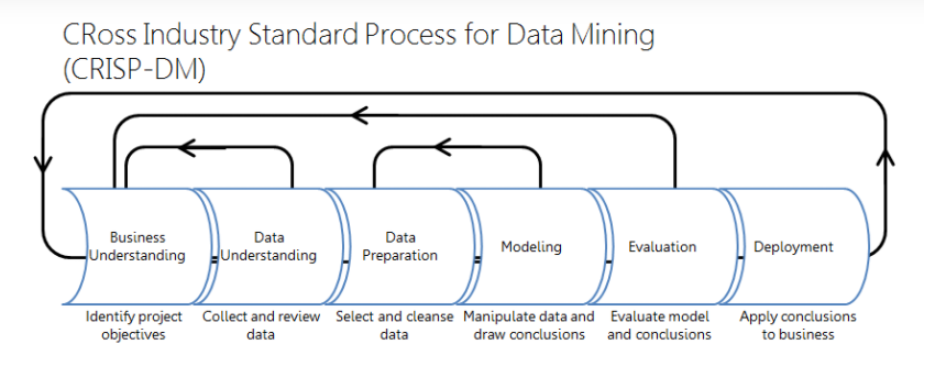

SOURCE: Full CRISP-DM Manual in PDF format: https://the-modeling-agency.com/crisp-dm.pdf

# Step 1:  Business Understanding:  We are given a data set that includes the features of various cars, and the cost of each car.  Some of the data is also missing.  We are tasked to build a model that predicts the automobile's price.  

# Step 2:  Data Understanding:  Collect and review the data

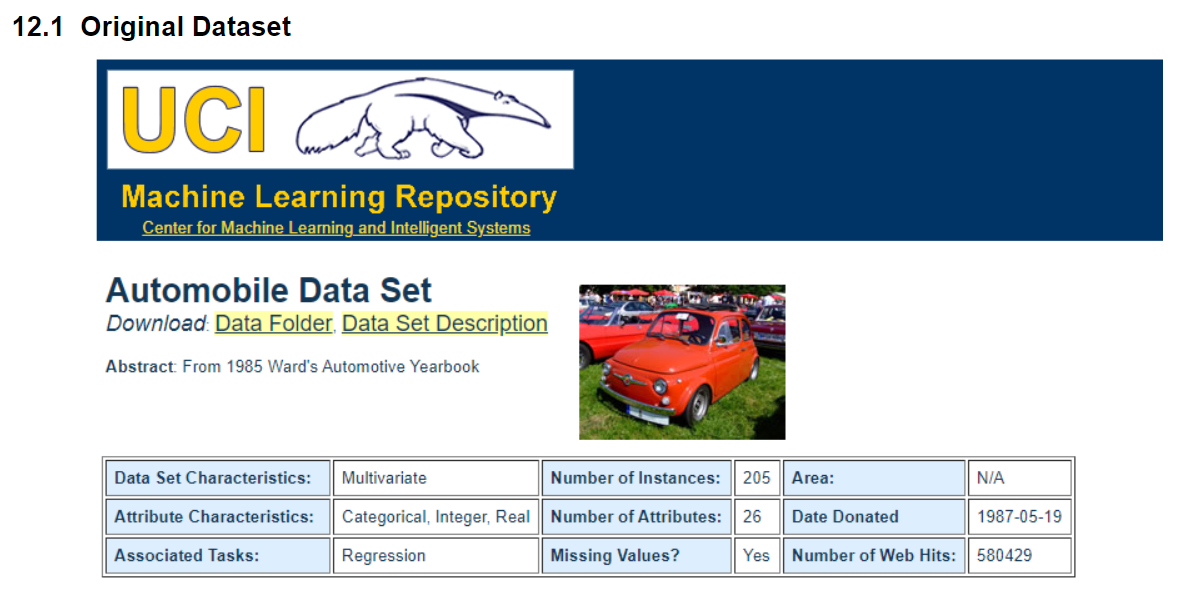

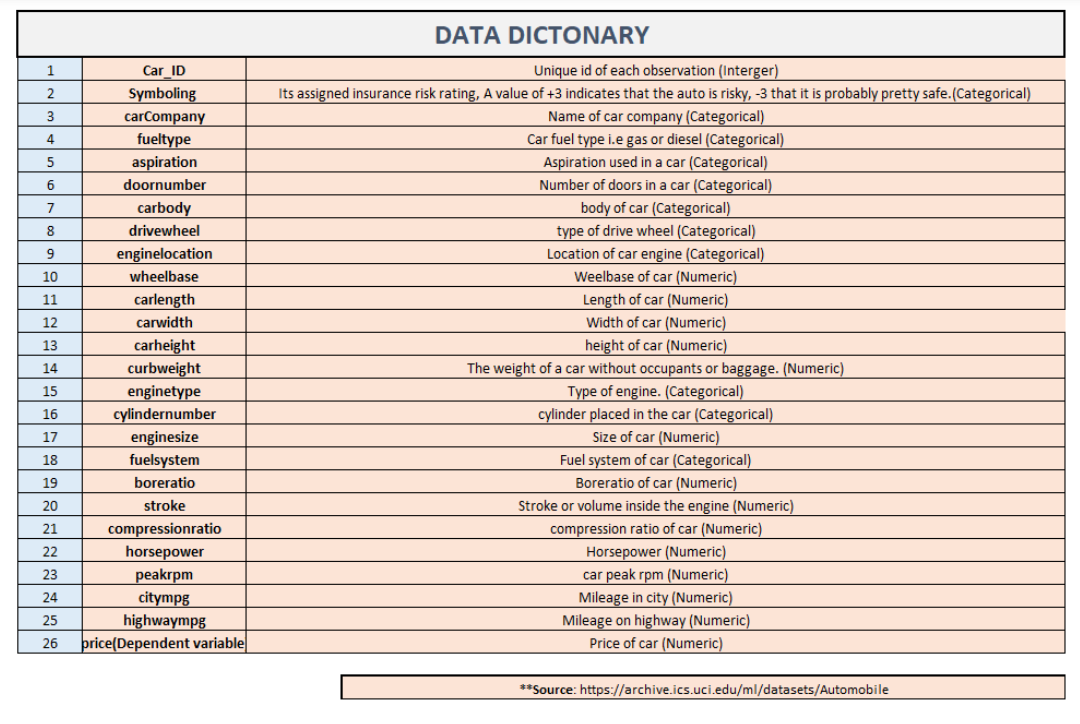

SOURCE:  UCI Datasets

 ## Read in the data

In [3]:
file_location = './auto_prices.pkl'
df = pd.read_pickle(file_location)

## Preliminary view of the data

In [4]:
# display a data summary 
display(df.info())
display(df.describe())
display(df.head(3))
display(df.tail(3))
display(df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   make               205 non-null    object 
 1   fuel-type          205 non-null    object 
 2   aspiration         205 non-null    object 
 3   num-of-doors       205 non-null    object 
 4   body-style         205 non-null    object 
 5   drive-wheels       205 non-null    object 
 6   engine-location    205 non-null    object 
 7   wheel-base         205 non-null    float64
 8   length             205 non-null    float64
 9   width              205 non-null    float64
 10  height             205 non-null    float64
 11  curb-weight        205 non-null    int64  
 12  engine-type        205 non-null    object 
 13  num-of-cylinders   205 non-null    object 
 14  engine-size        205 non-null    int64  
 15  fuel-system        205 non-null    object 
 16  bore               205 non

None

wheel-base      length       width      height  curb-weight  \
count  205.000000  205.000000  205.000000  205.000000   205.000000   
mean    98.756585  174.049268   65.907805   53.724878  2555.565854   
std      6.021776   12.337289    2.145204    2.443522   520.680204   
min     86.600000  141.100000   60.300000   47.800000  1488.000000   
25%     94.500000  166.300000   64.100000   52.000000  2145.000000   
50%     97.000000  173.200000   65.500000   54.100000  2414.000000   
75%    102.400000  183.100000   66.900000   55.500000  2935.000000   
max    120.900000  208.100000   72.300000   59.800000  4066.000000   

       engine-size  compression-ratio    city-mpg  highway-mpg  
count   205.000000         205.000000  205.000000   205.000000  
mean    126.907317          10.142537   25.219512    30.751220  
std      41.642693           3.972040    6.542142     6.886443  
min      61.000000           7.000000   13.000000    16.000000  
25%      97.000000           8.600000   19.000000    25.000000  
50%     120.000000           9.000000   24.000000    30.000000  
75%     141.000000           9.400000   30.000000    34.000000  
max     326.000000          23.000000   49.000000    54.000000

make fuel-type aspiration num-of-doors   body-style drive-wheels  \
0  alfa-romero       gas        std          two  convertible          rwd   
1  alfa-romero       gas        std          two  convertible          rwd   
2  alfa-romero       gas        std          two    hatchback          rwd   

  engine-location  wheel-base  length  width  ...  engine-size  fuel-system  \
0           front        88.6   168.8   64.1  ...          130         mpfi   
1           front        88.6   168.8   64.1  ...          130         mpfi   
2           front        94.5   171.2   65.5  ...          152         mpfi   

   bore stroke  compression-ratio horsepower peak-rpm city-mpg  highway-mpg  \
0  3.47   2.68                9.0        111     5000       21           27   
1  3.47   2.68                9.0        111     5000       21           27   
2  2.68   3.47                9.0        154     5000       19           26   

   price  
0  13495  
1  16500  
2  16500  

[3 rows x 24 columns]

make fuel-type aspiration num-of-doors body-style drive-wheels  \
202  volvo       gas        std         four      sedan          rwd   
203  volvo    diesel      turbo         four      sedan          rwd   
204  volvo       gas      turbo         four      sedan          rwd   

    engine-location  wheel-base  length  width  ...  engine-size  fuel-system  \
202           front       109.1   188.8   68.9  ...          173         mpfi   
203           front       109.1   188.8   68.9  ...          145          idi   
204           front       109.1   188.8   68.9  ...          141         mpfi   

     bore stroke  compression-ratio horsepower peak-rpm city-mpg  highway-mpg  \
202  3.58   2.87                8.8        134     5500       18           23   
203  3.01    3.4               23.0        106     4800       26           27   
204  3.78   3.15                9.5        114     5400       19           25   

     price  
202  21485  
203  22470  
204  22625  

[3 rows x 24 columns]

(205, 24)

## Set columns and rows to the size of the dataframe and view it.

In [5]:
pd.options.display.max_rows = 300       #Increases the number of rows displayed without a break in the middle.
pd.options.display.max_columns = 25     #Increases the number of columns displayed without a break in the middle.
pd.set_option('max_colwidth',100)       #Increases the width of the columns to display 100 characters at the same time.

In [6]:
df.head()

make fuel-type aspiration num-of-doors   body-style drive-wheels  \
0  alfa-romero       gas        std          two  convertible          rwd   
1  alfa-romero       gas        std          two  convertible          rwd   
2  alfa-romero       gas        std          two    hatchback          rwd   
3         audi       gas        std         four        sedan          fwd   
4         audi       gas        std         four        sedan          4wd   

  engine-location  wheel-base  length  width  height  curb-weight engine-type  \
0           front        88.6   168.8   64.1    48.8         2548        dohc   
1           front        88.6   168.8   64.1    48.8         2548        dohc   
2           front        94.5   171.2   65.5    52.4         2823        ohcv   
3           front        99.8   176.6   66.2    54.3         2337         ohc   
4           front        99.4   176.6   66.4    54.3         2824         ohc   

  num-of-cylinders  engine-size fuel-system  bore stroke  compression-ratio  \
0             four          130        mpfi  3.47   2.68                9.0   
1             four          130        mpfi  3.47   2.68                9.0   
2              six          152        mpfi  2.68   3.47                9.0   
3             four          109        mpfi  3.19    3.4               10.0   
4             five          136        mpfi  3.19    3.4                8.0   

  horsepower peak-rpm  city-mpg  highway-mpg  price  
0        111     5000        21           27  13495  
1        111     5000        21           27  16500  
2        154     5000        19           26  16500  
3        102     5500        24           30  13950  
4        115     5500        18           22  17450

## View contents and question marks - Some of the columns have question marks in them.

In [7]:
def check_numeric(val):
    try:
        test = float(val)
        return True

    except ValueError:
        return False
    
for col in df.columns:
    
    vals = set([val for val in df[col].values if check_numeric(val) == False])
    if len(vals)>0:
        
        print('|{:<18}  | {} '.format(str(col), vals))

    else:
        print('|{:<18}  | {} '.format(str(col), 'All Numbers'))  

|make                | {'dodge', 'volkswagen', 'jaguar', 'mitsubishi', 'bmw', 'renault', 'mazda', 'mercury', 'plymouth', 'toyota', 'isuzu', 'nissan', 'volvo', 'porsche', 'audi', 'saab', 'chevrolet', 'mercedes-benz', 'alfa-romero', 'subaru', 'peugot', 'honda'} 
|fuel-type           | {'diesel', 'gas'} 
|aspiration          | {'std', 'turbo'} 
|num-of-doors        | {'?', 'four', 'two'} 
|body-style          | {'sedan', 'hatchback', 'convertible', 'hardtop', 'wagon'} 
|drive-wheels        | {'fwd', '4wd', 'rwd'} 
|engine-location     | {'rear', 'front'} 
|wheel-base          | All Numbers 
|length              | All Numbers 
|width               | All Numbers 
|height              | All Numbers 
|curb-weight         | All Numbers 
|engine-type         | {'rotor', 'ohc', 'l', 'ohcf', 'ohcv', 'dohc', 'dohcv'} 
|num-of-cylinders    | {'five', 'four', 'six', 'twelve', 'three', 'two', 'eight'} 
|engine-size         | All Numbers 
|fuel-system         | {'1bbl', '4bbl', 'spfi', 'mpfi', '2bbl',

### Columns that should be categorical values
- make
- fuel-type
- aspiration
- body-style
- drive-wheels
- engine-location
- engine-type
- fuel-system

### All column that should be numerical values

- wheel-base 
- length     
- width
- height
- curb-weight  

- num-of-cylinders (Needs to be converted)

- fuel-system
- bore
- stroke
- compression-ratio
- horsepower
- peak-rpm
- city-mpg
- highway-mpg
- price

### Columns with question marks (all should be numerical):
- num-of-cylinders (Needs to stay categorical)
- bore
- stroke
- horsepower
- peak-rpm
- price

### Total columns to convert to numeric
- num-of-doors 
- num-of-cylinders
- bore
- stroke
- horsepower
- peak-rpm
- price

 ### convert columns to numbers and ?'s to NaN's

In [8]:
print(df['num-of-doors'].unique())
print(df['num-of-cylinders'].unique())

['two' 'four' '?']
['four' 'six' 'five' 'three' 'twelve' 'two' 'eight']


In [9]:
# convert the num-of-doors and cynlinders

# num-of-doors (Needs to stay categorical)
# bore
# stroke
# horsepower
# peak-rpm
# price
# e

df['num-of-cylinders'].loc[df['num-of-cylinders'] == 'four']  = 4
df['num-of-cylinders'].loc[df['num-of-cylinders'] == 'six']   = 6
df['num-of-cylinders'].loc[df['num-of-cylinders'] == 'five']  = 5
df['num-of-cylinders'].loc[df['num-of-cylinders'] == 'three'] = 3
df['num-of-cylinders'].loc[df['num-of-cylinders'] == 'twelve']= 12
df['num-of-cylinders'].loc[df['num-of-cylinders'] == 'two']   = 2
df['num-of-cylinders'].loc[df['num-of-cylinders'] == 'eight'] = 8

# convert columns to numeric and ? to np.nan

columns_to_covert = ['num-of-cylinders','bore','stroke','horsepower','peak-rpm','price']
df[columns_to_covert] = df[columns_to_covert].apply(pd.to_numeric, errors='coerce')

df['num-of-doors'].loc[df['num-of-doors'] == '?'] = np.nan

display(df.info())
print('Numeric Column/ Features')
display(df.select_dtypes(include='number').head())
print('Objects')
display(df.select_dtypes(include='object').head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   make               205 non-null    object 
 1   fuel-type          205 non-null    object 
 2   aspiration         205 non-null    object 
 3   num-of-doors       203 non-null    object 
 4   body-style         205 non-null    object 
 5   drive-wheels       205 non-null    object 
 6   engine-location    205 non-null    object 
 7   wheel-base         205 non-null    float64
 8   length             205 non-null    float64
 9   width              205 non-null    float64
 10  height             205 non-null    float64
 11  curb-weight        205 non-null    int64  
 12  engine-type        205 non-null    object 
 13  num-of-cylinders   205 non-null    int64  
 14  engine-size        205 non-null    int64  
 15  fuel-system        205 non-null    object 
 16  bore               201 non

None

Numeric Column/ Features


wheel-base  length  width  height  curb-weight  num-of-cylinders  \
0        88.6   168.8   64.1    48.8         2548                 4   
1        88.6   168.8   64.1    48.8         2548                 4   
2        94.5   171.2   65.5    52.4         2823                 6   
3        99.8   176.6   66.2    54.3         2337                 4   
4        99.4   176.6   66.4    54.3         2824                 5   

   engine-size  bore  stroke  compression-ratio  horsepower  peak-rpm  \
0          130  3.47    2.68                9.0       111.0    5000.0   
1          130  3.47    2.68                9.0       111.0    5000.0   
2          152  2.68    3.47                9.0       154.0    5000.0   
3          109  3.19    3.40               10.0       102.0    5500.0   
4          136  3.19    3.40                8.0       115.0    5500.0   

   city-mpg  highway-mpg    price  
0        21           27  13495.0  
1        21           27  16500.0  
2        19           26  16500.0  
3        24           30  13950.0  
4        18           22  17450.0

Objects


make fuel-type aspiration num-of-doors   body-style drive-wheels  \
0  alfa-romero       gas        std          two  convertible          rwd   
1  alfa-romero       gas        std          two  convertible          rwd   
2  alfa-romero       gas        std          two    hatchback          rwd   
3         audi       gas        std         four        sedan          fwd   
4         audi       gas        std         four        sedan          4wd   

  engine-location engine-type fuel-system  
0           front        dohc        mpfi  
1           front        dohc        mpfi  
2           front        ohcv        mpfi  
3           front         ohc        mpfi  
4           front         ohc        mpfi

## Variable exploration with histograms, boxplots, etc.

### histograms and tests for normality

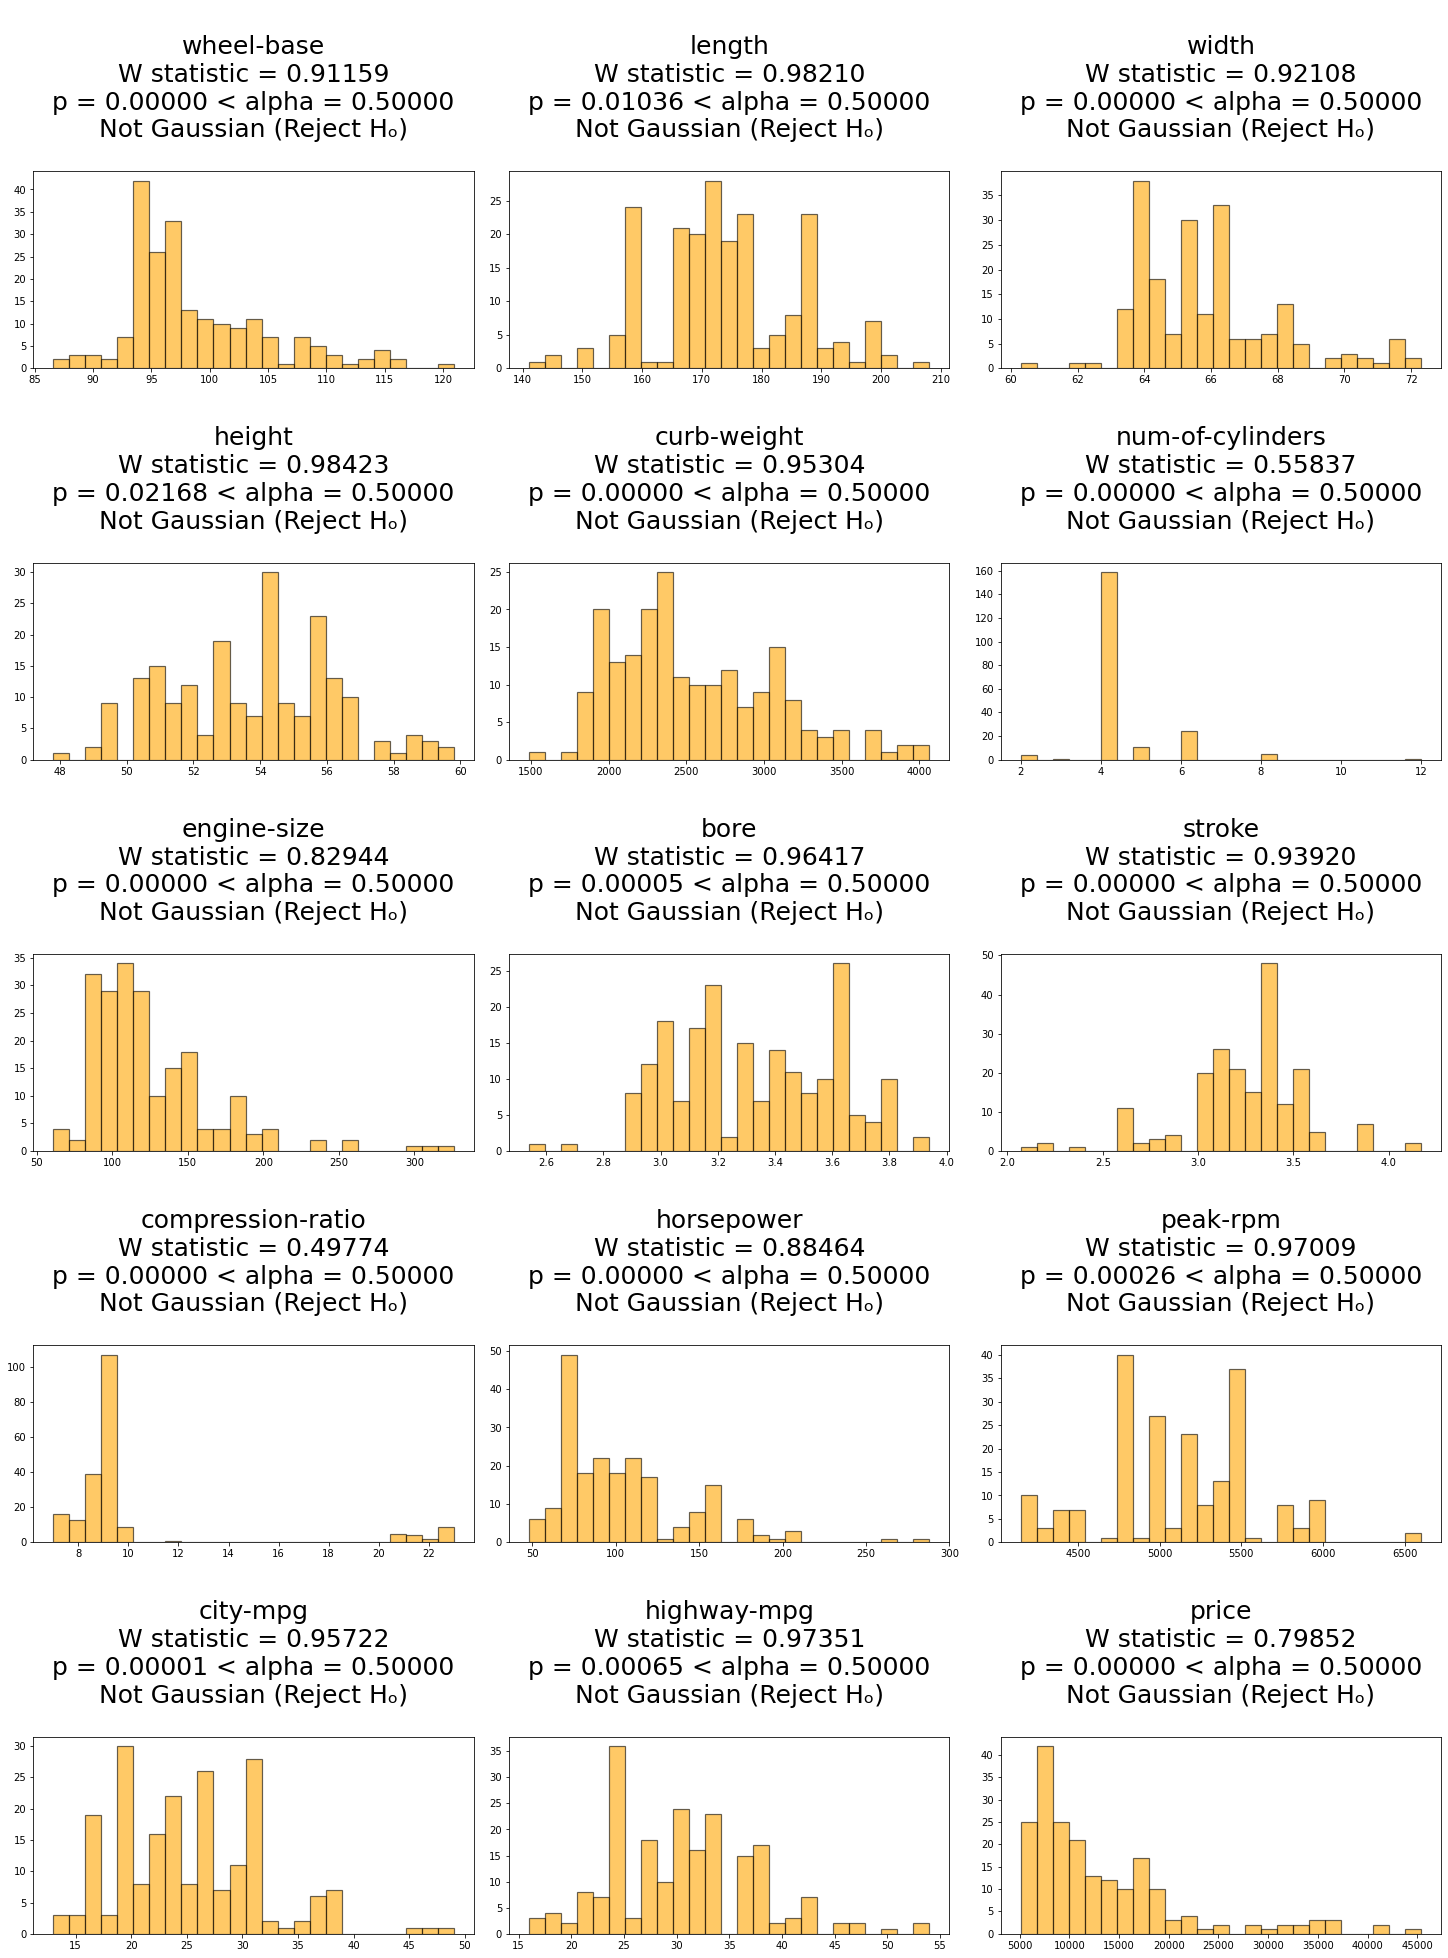

In [10]:
data = df.copy()
features = df.select_dtypes(include='number').columns.to_list()

histplot_features(data, features)

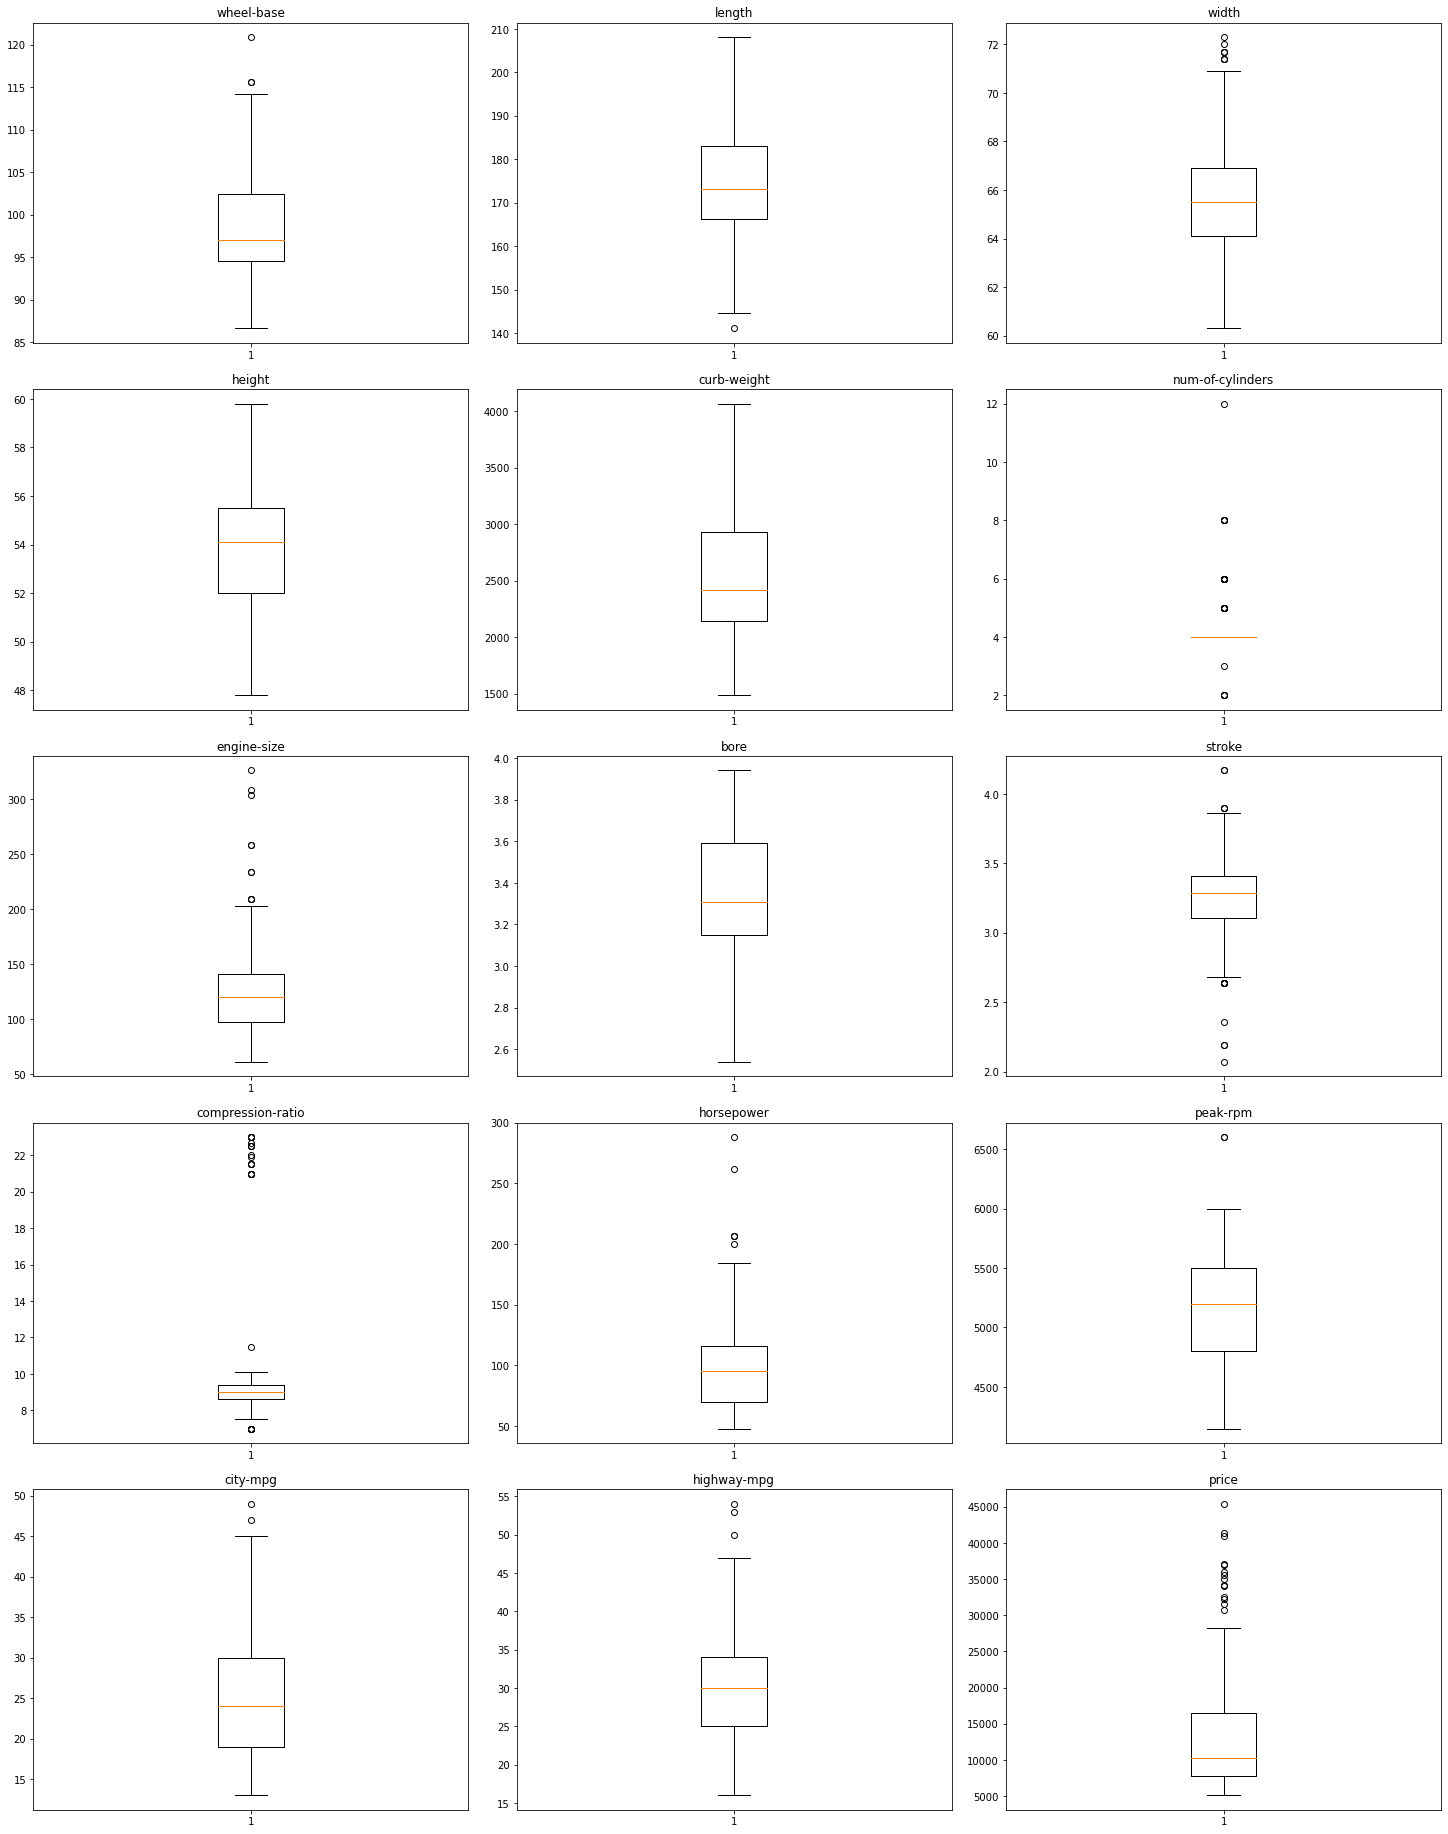

In [11]:
data = df.copy()
features = df.select_dtypes(include='number').columns.to_list()

boxplot_features(data, features)

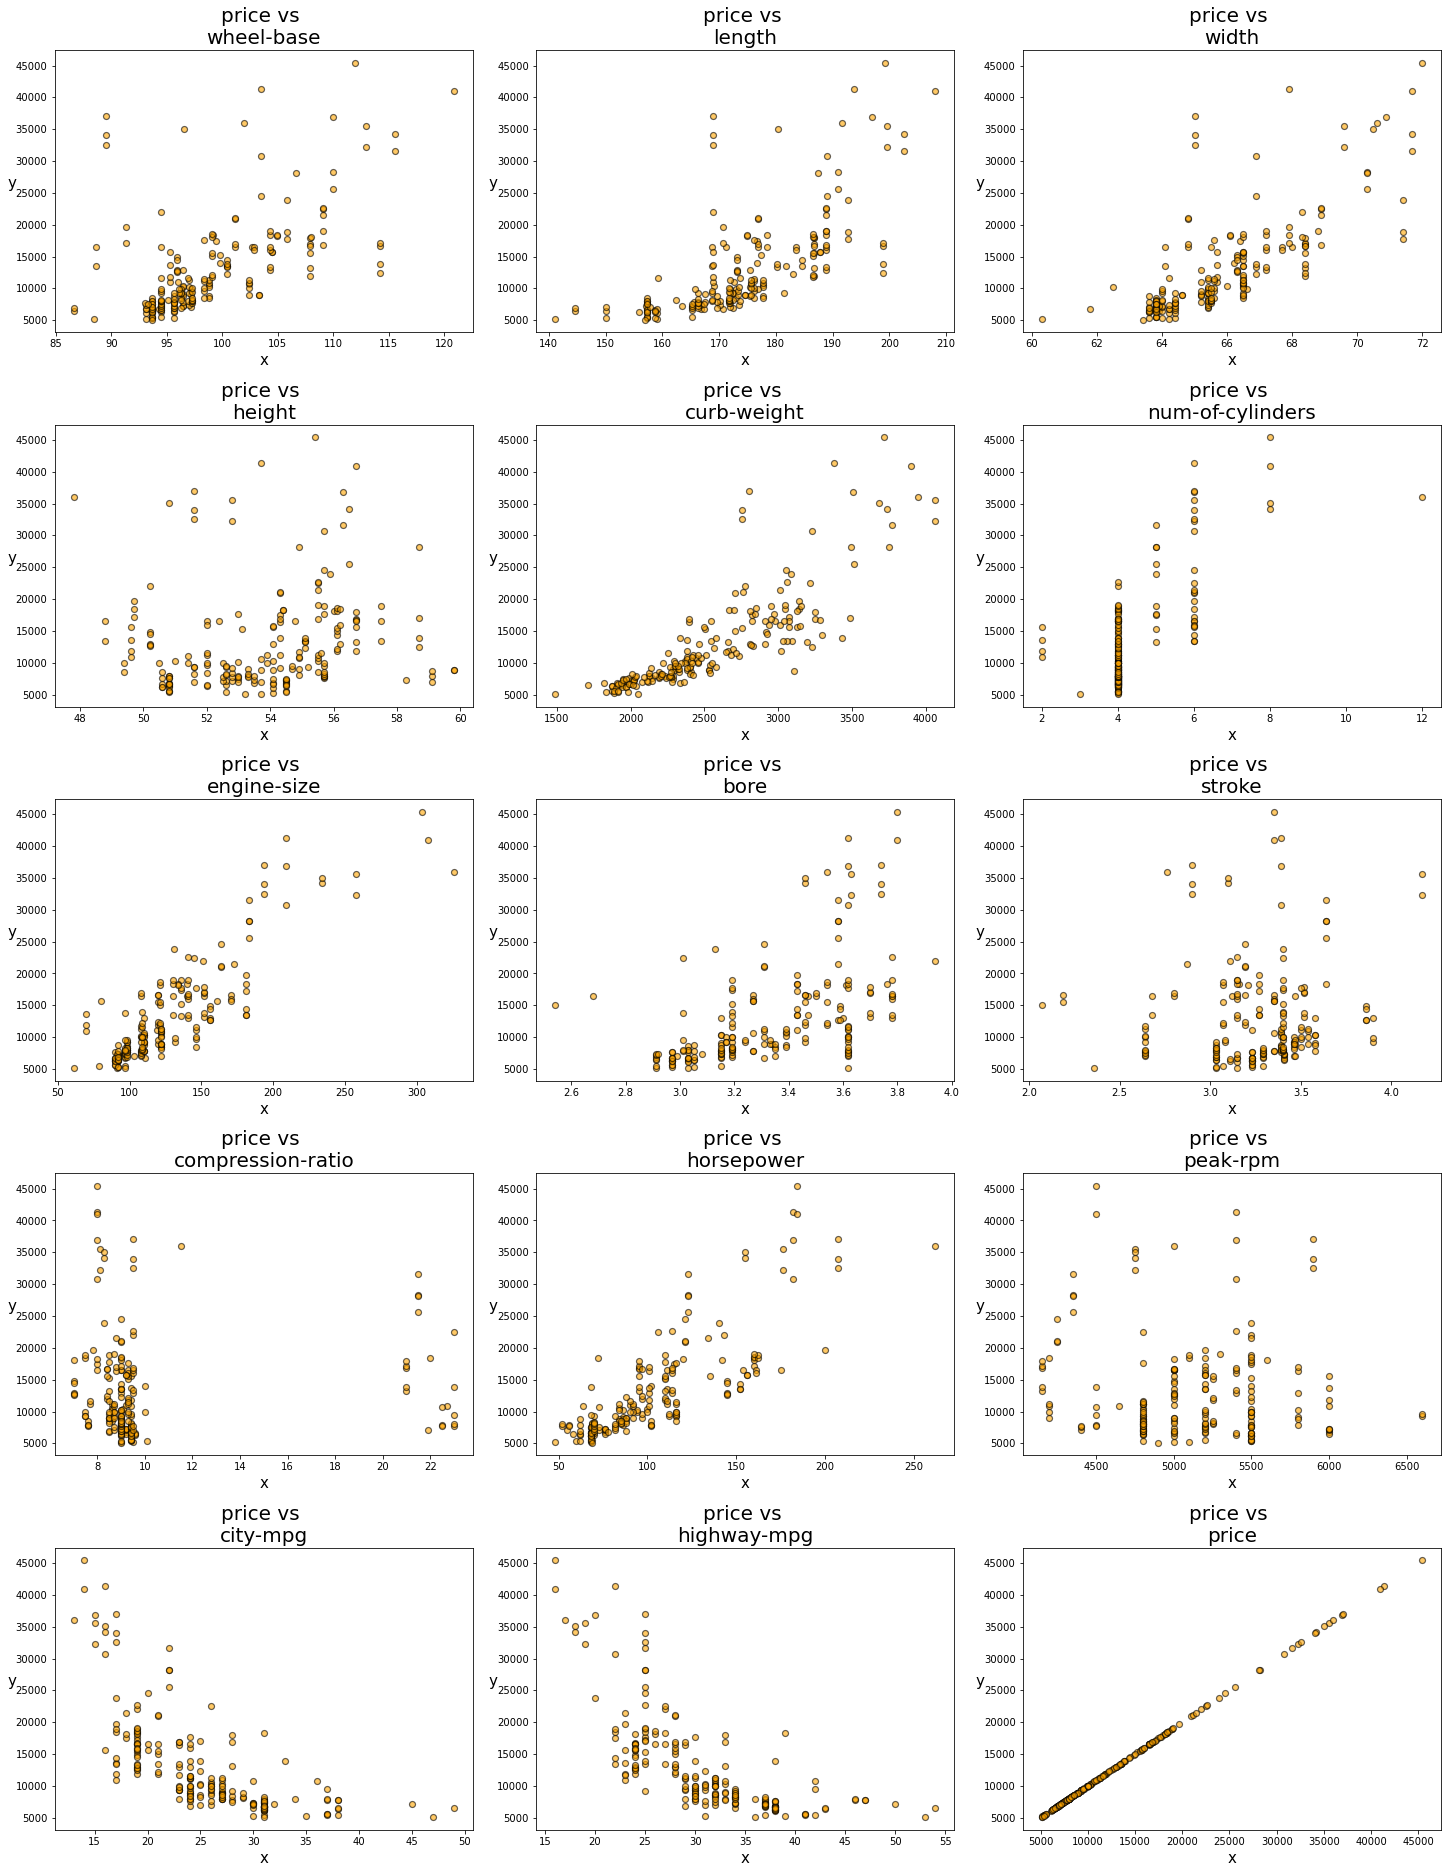

In [12]:
y = df['price']
cols = 3
rows = len(features) // cols + 1

def trim_axs(axs, N):
    """
    Reduce *axs* to *N* Axes. All further Axes are removed from the figure.
    """
    axs = axs.flat

    for ax in axs[N:]:
        ax.remove()
    return axs[:N]
    
axs = plt.figure(figsize = (20, 30), constrained_layout=True).subplots(rows, cols)
axs = trim_axs(axs, len(features))
for ax, feature in zip(axs, features):
    ax.set_title('{} vs \n{}'.format('price',str(feature)), fontsize = 20)
    ax.scatter(df[feature], y,color = 'orange', alpha = 0.6, edgecolor='black', linewidth=1.2)
    ax.set_ylabel('y', fontsize = 15, rotation = 0)
    ax.set_xlabel('x', fontsize = 15)

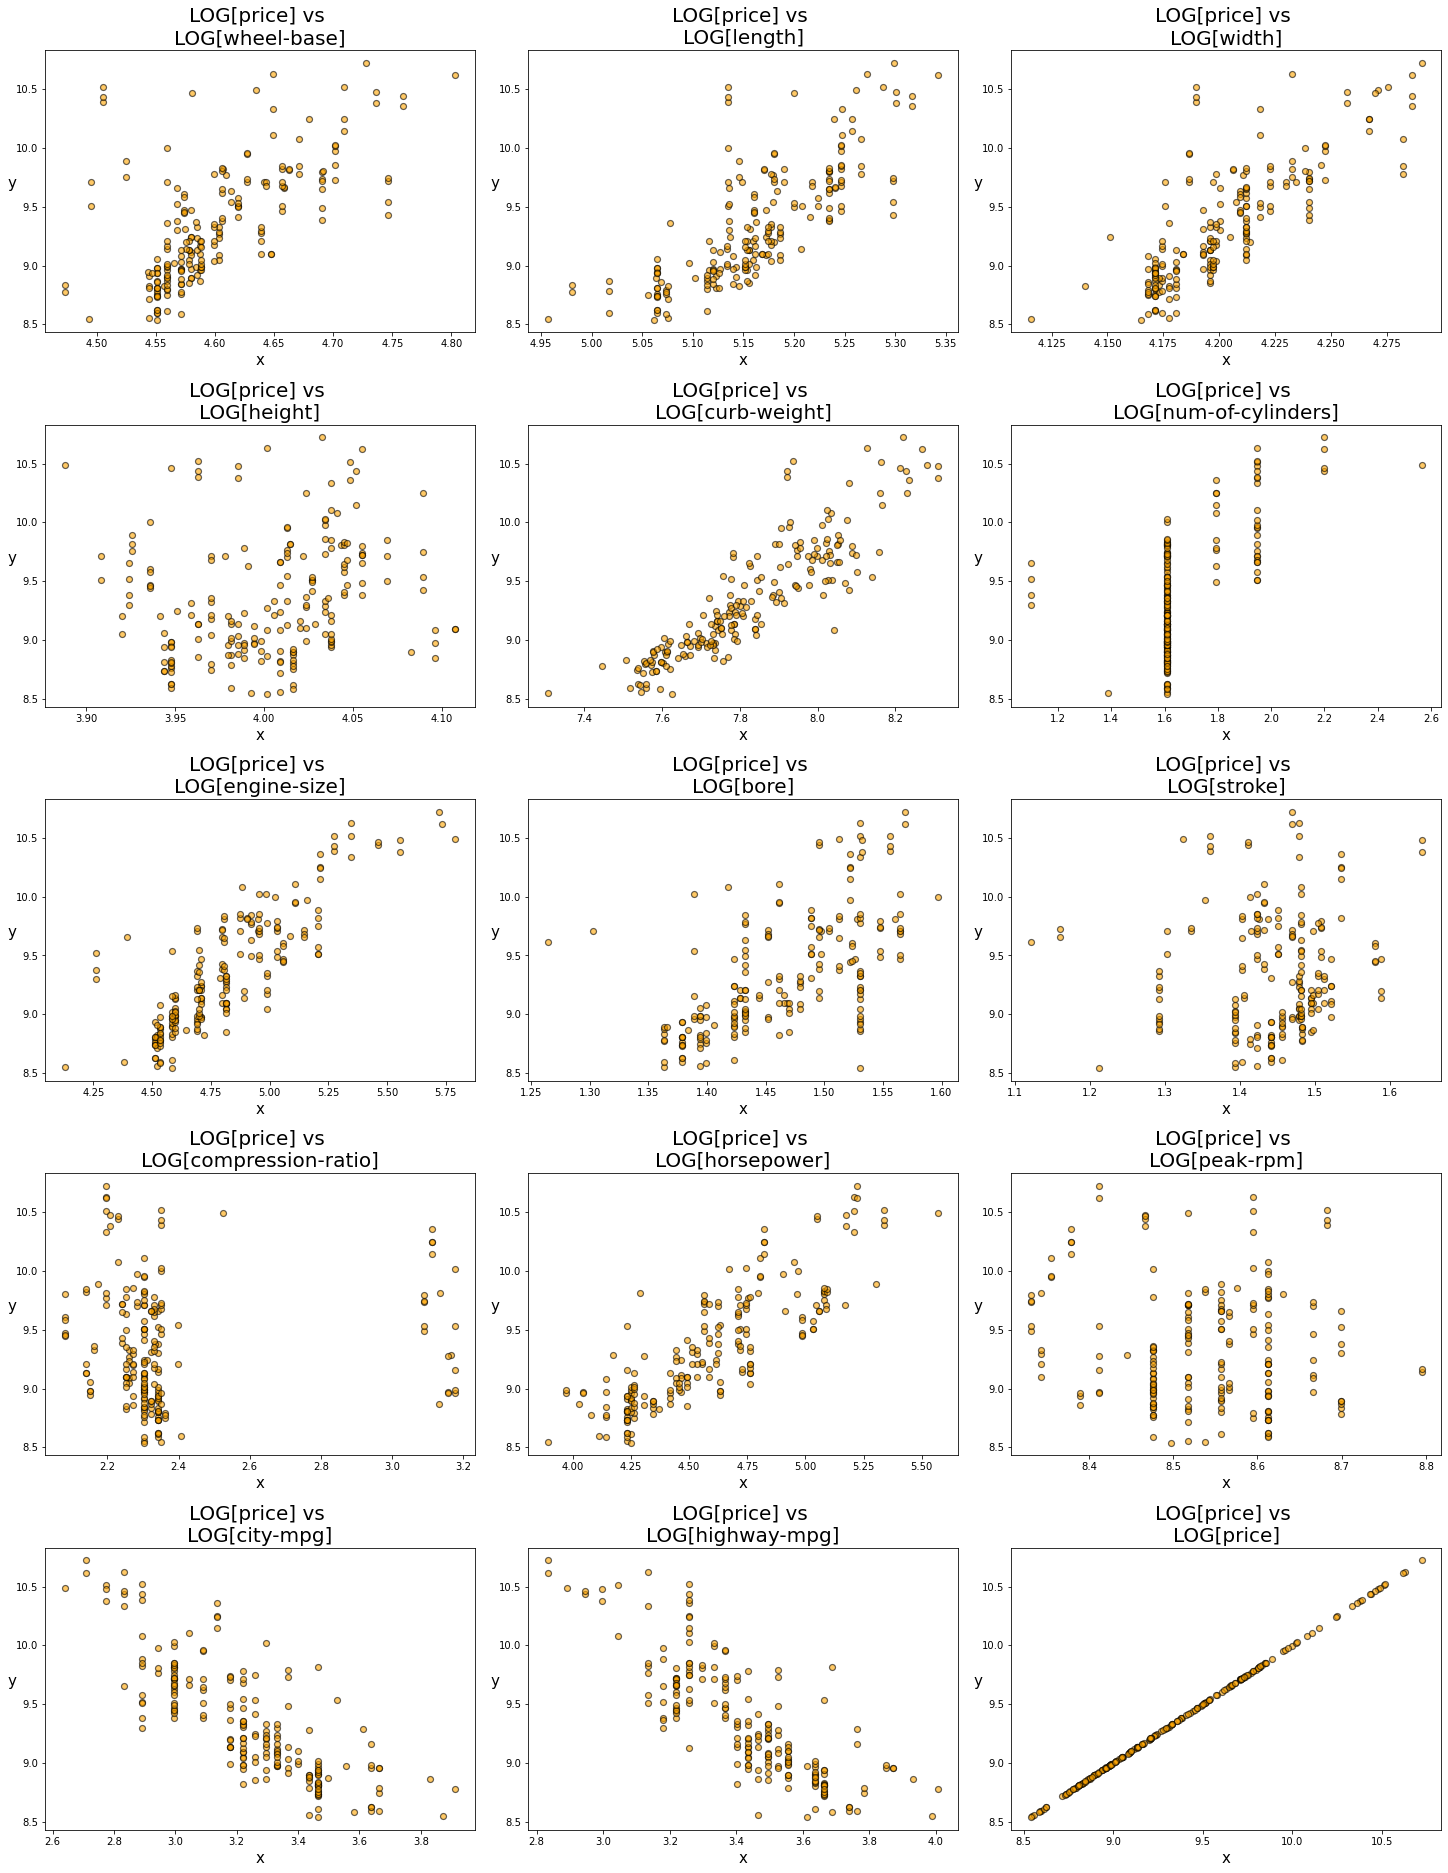

In [13]:
y = df['price']
cols = 3
rows = len(features) // cols + 1

def trim_axs(axs, N):
    """
    Reduce *axs* to *N* Axes. All further Axes are removed from the figure.
    """
    axs = axs.flat

    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

axs = plt.figure(figsize = (20, 30), constrained_layout=True).subplots(rows, cols)
axs = trim_axs(axs, len(features))
for ax, feature in zip(axs, features):
    
    data_log = np.log1p(df[feature])
    y_log = np.log1p(y)
    
    ax.set_title('LOG[{}] vs \nLOG[{}]'.format('price', str(feature)), fontsize = 20)
    ax.scatter(data_log, y_log,color = 'orange', alpha = 0.6, edgecolor='black', linewidth=1.2)
    ax.set_ylabel('y', fontsize = 15, rotation = 0)
    ax.set_xlabel('x', fontsize = 15)

### Conclusions:
- Some data exhibits heterskedasticity in the form of expanding variance. 
- Log transformation seems to help address the heteroskedasticity which may help with the regression model
- Log transformation does not normalize the data, however this is not necessary to performe a linear regression.
- The number of cylinders was originally categorical, but it exhibits a positive correlation to price. 
- The compression ratio has two clusters, that should either be changed to a categorical variable of 'low' and 'high' or an interaction term should be added.

### Take a closer look at examining the feature 'compression ratio'

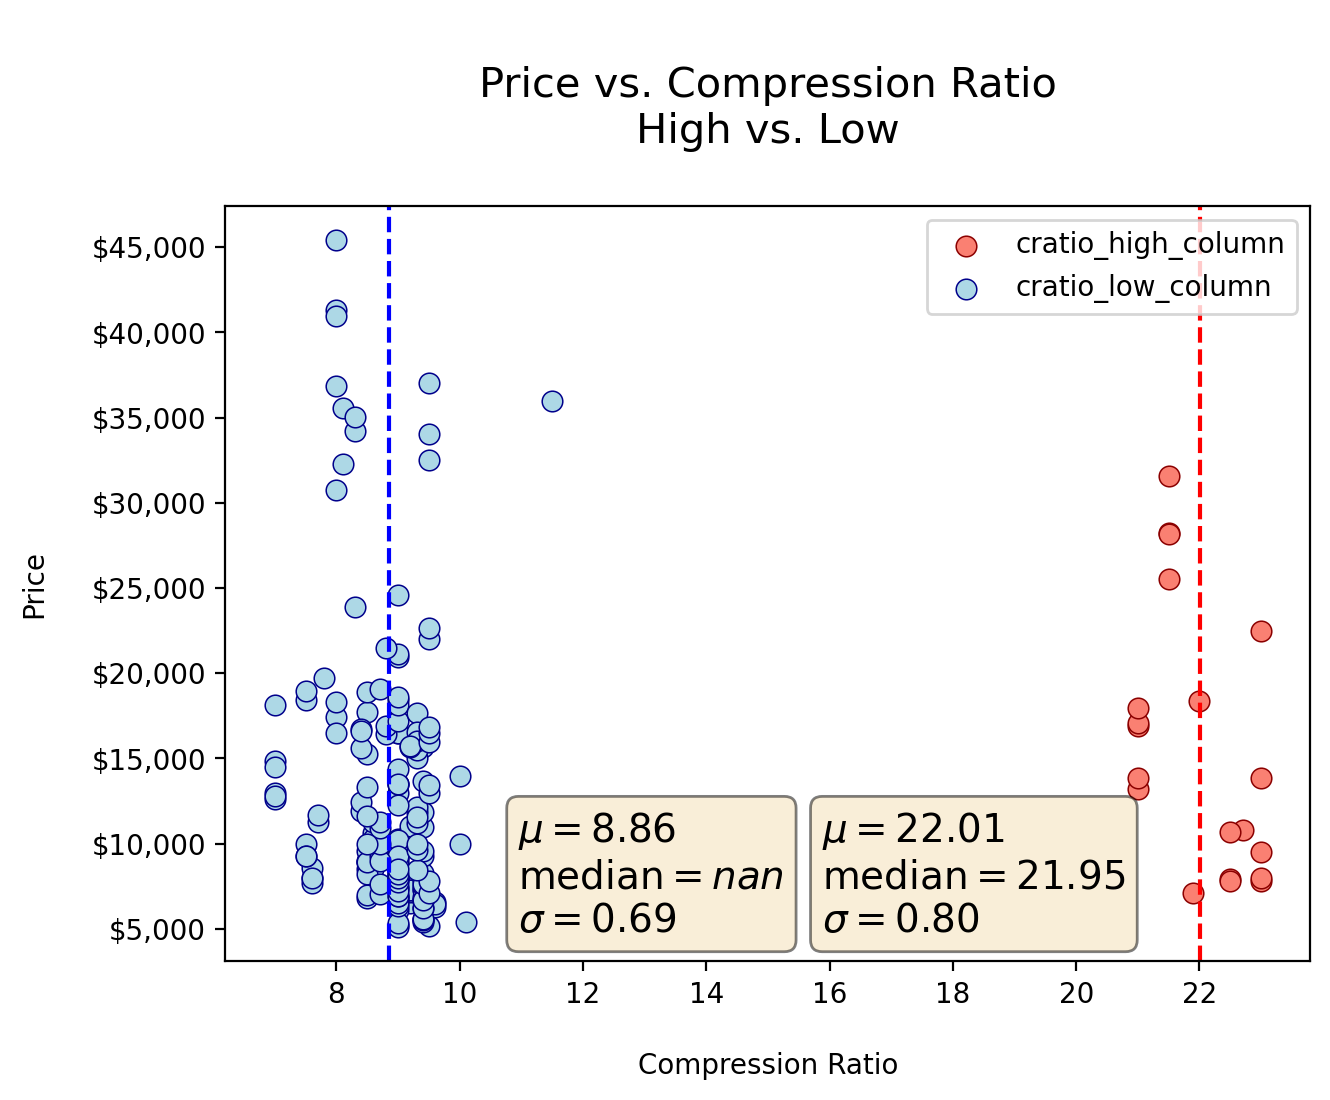

In [14]:
cratio_high = pd.Series([1 if x >= 15 else np.nan for x in df['compression-ratio']])*df['compression-ratio']
cratio_low  = pd.Series([1 if x <  15 else np.nan for x in df['compression-ratio']])*df['compression-ratio']

# high_mean = cratio_high.mean()
# low_mean = cratio_low.mean()

hi_mu = cratio_high.mean()
hi_sigma = cratio_high.std()
hi_median = cratio_high.median()

lo_mu = cratio_low.mean()
lo_sigma = cratio_low.std()
lo_median = np.median(cratio_low)

plt.style.context('ggplot')
fig, ax = plt.subplots(figsize = (7,5), dpi = 200)

fmt = '${x:,.0f}'
tick = ticker.StrMethodFormatter(fmt)

# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

hi_textstr = '\n'.join((
    r'$\mu=%.2f$' % (hi_mu, ),
    r'$\mathrm{median}=%.2f$' % (hi_median, ),
    r'$\sigma=%.2f$' % (hi_sigma, )))

lo_textstr = '\n'.join((
    r'$\mu=%.2f$' % (lo_mu, ),
    r'$\mathrm{median}=%.2f$' % (lo_median, ),
    r'$\sigma=%.2f$' % (lo_sigma, )))

ax.yaxis.set_major_formatter(tick) 

ax.scatter(cratio_high,  df['price'], facecolors='salmon', edgecolors='darkred', s = 55, linewidth = 0.55, 
           label = 'cratio_high_column')
ax.scatter(cratio_low,  df['price'], facecolors='lightblue',edgecolors='darkblue', s = 55, linewidth = 0.55, 
           label = 'cratio_low_column')

ax.axvline(x = hi_mu, linestyle = '--', color = 'red')
ax.axvline(x = lo_mu, linestyle = '--', color = 'blue')

ax.set_ylabel('Price\n')
ax.set_xlabel('\nCompression Ratio')
ax.set_title('\nPrice vs. Compression Ratio\nHigh vs. Low\n',fontsize = 15)

ax.text(0.55, 0.20, hi_textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

ax.text(0.27, 0.20, lo_textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)


plt.legend(loc=1)
plt.show()

### Conclusion

There needs to be a "reaction term" created for compression ration that is a binary term for a high or low compression-ratio, multiplied by the original feature to create two reaction terms. 

### Scatterplot matrix of numeric predictor variables and get a first look at collinearity/ multicollinearity. 

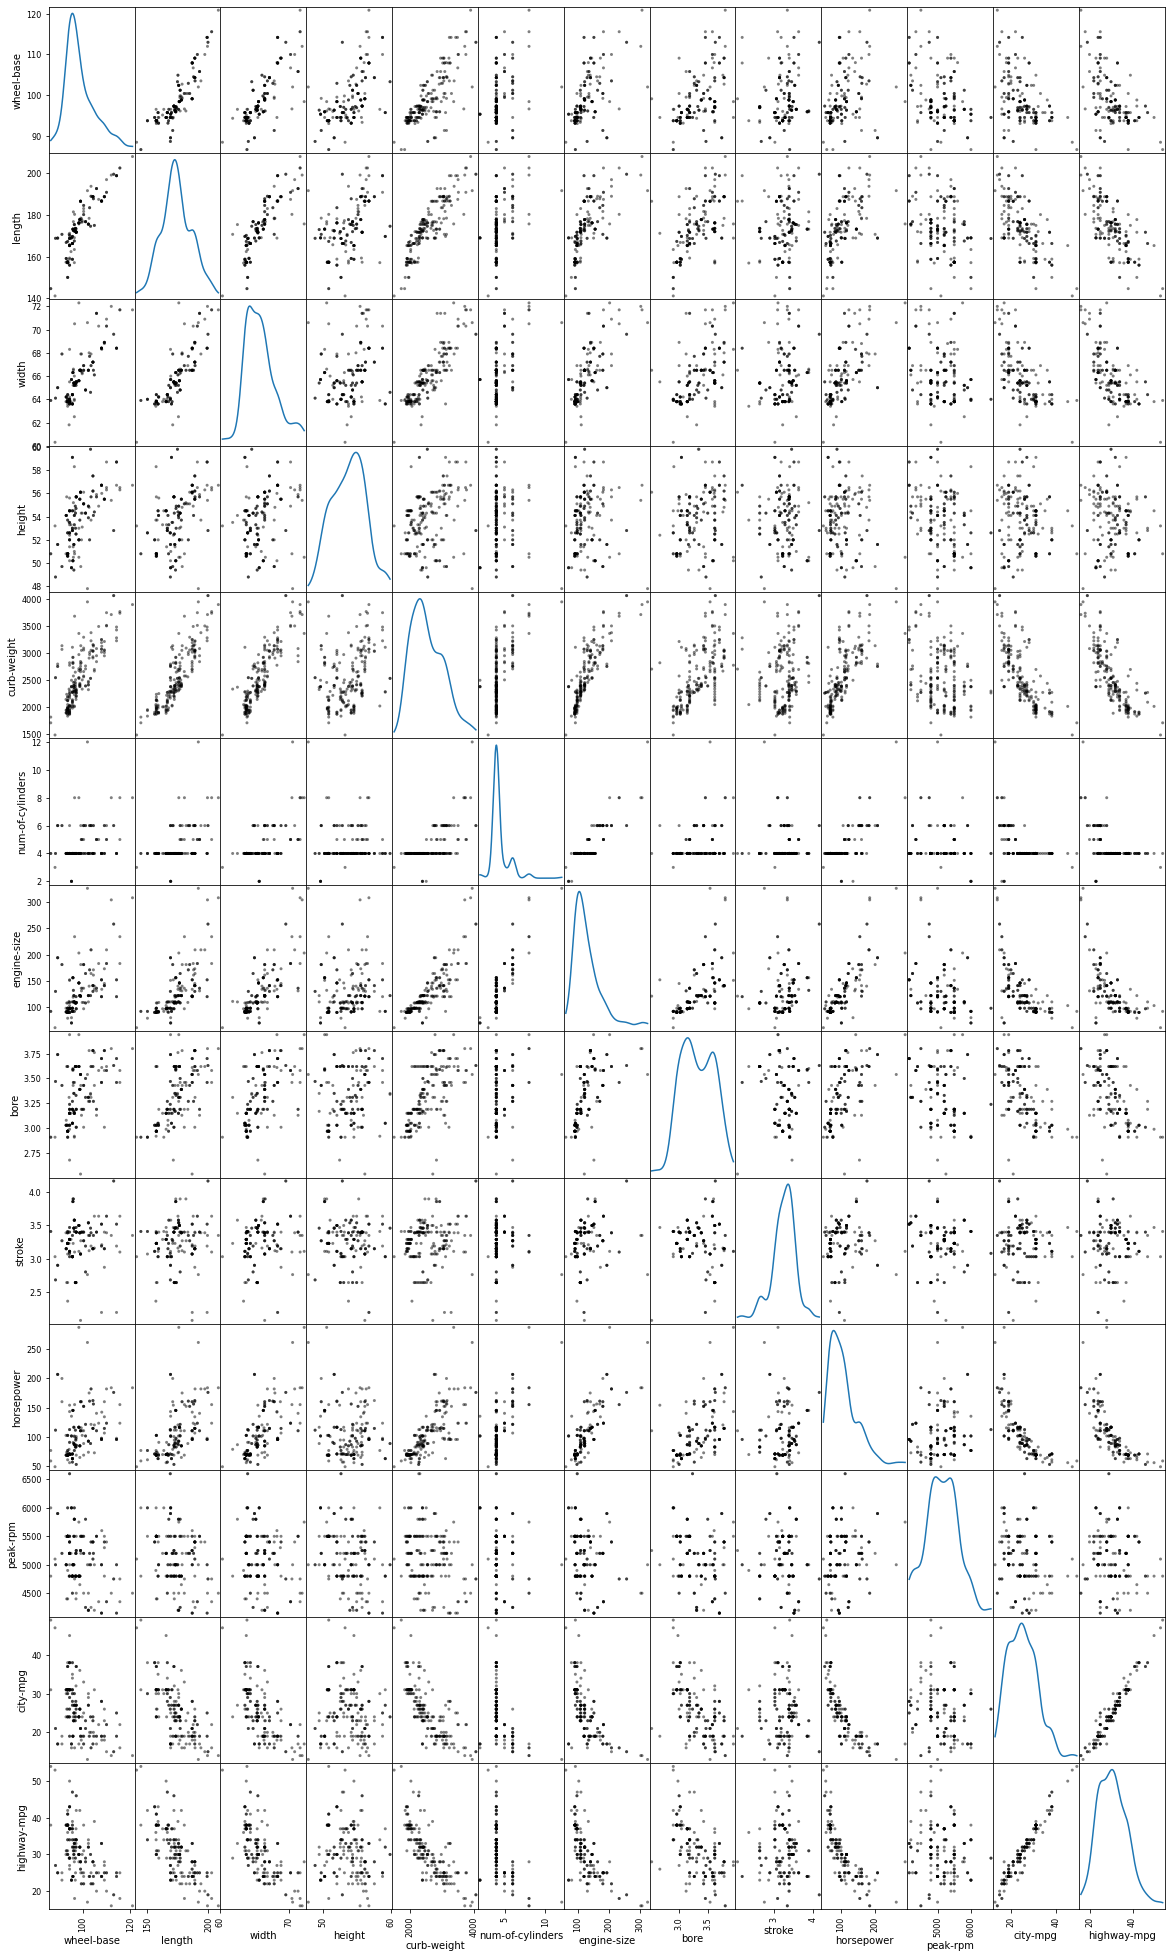

In [15]:
# not including price,compression-ratio to the numerical variables.
# price is the target variable and was used above. 
# compression ratio is bifurcated and needs a dummy variable.

from pandas.plotting import scatter_matrix

features = df.select_dtypes(include='number').columns.to_list()
numerical_predictors = [col for col in features if col not in ['price','compression-ratio']]
scatter_matrix(df[[col for col in numerical_predictors]], color = 'black', figsize = (20, 35), diagonal = 'kde')
plt.show()

### Plot correlations in a matrix and in an extended fashion to view the feature correlations them individually

In [16]:
features = df.select_dtypes(include='number').columns.to_list()
numerical_predictors = [col for col in features if col not in ['price','compression-ratio']]

display(df[numerical_predictors].corr())
display(pd.DataFrame(df[numerical_predictors].corr().unstack()))

wheel-base    length     width    height  curb-weight  \
wheel-base          1.000000  0.874587  0.795144  0.589435     0.776386   
length              0.874587  1.000000  0.841118  0.491029     0.877728   
width               0.795144  0.841118  1.000000  0.279210     0.867032   
height              0.589435  0.491029  0.279210  1.000000     0.295572   
curb-weight         0.776386  0.877728  0.867032  0.295572     1.000000   
num-of-cylinders    0.339507  0.430672  0.545007 -0.013995     0.609727   
engine-size         0.569329  0.683360  0.735433  0.067149     0.850594   
bore                0.490378  0.607480  0.559204  0.176195     0.649045   
stroke              0.161477  0.129739  0.182956 -0.056999     0.168929   
horsepower          0.352297  0.555003  0.642482 -0.110711     0.751034   
peak-rpm           -0.361052 -0.287325 -0.219957 -0.322272    -0.266306   
city-mpg           -0.470414 -0.670909 -0.642704 -0.048640    -0.757414   
highway-mpg        -0.544082 -0.704662 -0.677218 -0.107358    -0.797465   

                  num-of-cylinders  engine-size      bore    stroke  \
wheel-base                0.339507     0.569329  0.490378  0.161477   
length                    0.430672     0.683360  0.607480  0.129739   
width                     0.545007     0.735433  0.559204  0.182956   
height                   -0.013995     0.067149  0.176195 -0.056999   
curb-weight               0.609727     0.850594  0.649045  0.168929   
num-of-cylinders          1.000000     0.846031  0.243553  0.008578   
engine-size               0.846031     1.000000  0.594090  0.206675   
bore                      0.243553     0.594090  1.000000 -0.055909   
stroke                    0.008578     0.206675 -0.055909  1.000000   
horsepower                0.691633     0.810773  0.577273  0.090254   
peak-rpm                 -0.124434    -0.244618 -0.264269 -0.071493   
city-mpg                 -0.445837    -0.653658 -0.594584 -0.042906   
highway-mpg              -0.466666    -0.677470 -0.594572 -0.044528   

                  horsepower  peak-rpm  city-mpg  highway-mpg  
wheel-base          0.352297 -0.361052 -0.470414    -0.544082  
length              0.555003 -0.287325 -0.670909    -0.704662  
width               0.642482 -0.219957 -0.642704    -0.677218  
height             -0.110711 -0.322272 -0.048640    -0.107358  
curb-weight         0.751034 -0.266306 -0.757414    -0.797465  
num-of-cylinders    0.691633 -0.124434 -0.445837    -0.466666  
engine-size         0.810773 -0.244618 -0.653658    -0.677470  
bore                0.577273 -0.264269 -0.594584    -0.594572  
stroke              0.090254 -0.071493 -0.042906    -0.044528  
horsepower          1.000000  0.130971 -0.803620    -0.770908  
peak-rpm            0.130971  1.000000 -0.113788    -0.054257  
city-mpg           -0.803620 -0.113788  1.000000     0.971337  
highway-mpg        -0.770908 -0.054257  0.971337     1.000000

0
wheel-base       wheel-base        1.000000
                 length            0.874587
                 width             0.795144
                 height            0.589435
                 curb-weight       0.776386
                 num-of-cylinders  0.339507
                 engine-size       0.569329
                 bore              0.490378
                 stroke            0.161477
                 horsepower        0.352297
                 peak-rpm         -0.361052
                 city-mpg         -0.470414
                 highway-mpg      -0.544082
length           wheel-base        0.874587
                 length            1.000000
                 width             0.841118
                 height            0.491029
                 curb-weight       0.877728
                 num-of-cylinders  0.430672
                 engine-size       0.683360
                 bore              0.607480
                 stroke            0.129739
                 horsepower        0.555003
                 peak-rpm         -0.287325
                 city-mpg         -0.670909
                 highway-mpg      -0.704662
width            wheel-base        0.795144
                 length            0.841118
                 width             1.000000
                 height            0.279210
                 curb-weight       0.867032
                 num-of-cylinders  0.545007
                 engine-size       0.735433
                 bore              0.559204
                 stroke            0.182956
                 horsepower        0.642482
                 peak-rpm         -0.219957
                 city-mpg         -0.642704
                 highway-mpg      -0.677218
height           wheel-base        0.589435
                 length            0.491029
                 width             0.279210
                 height            1.000000
                 curb-weight       0.295572
                 num-of-cylinders -0.013995
                 engine-size       0.067149
                 bore              0.176195
                 stroke           -0.056999
                 horsepower       -0.110711
                 peak-rpm         -0.322272
                 city-mpg         -0.048640
                 highway-mpg      -0.107358
curb-weight      wheel-base        0.776386
                 length            0.877728
                 width             0.867032
                 height            0.295572
                 curb-weight       1.000000
                 num-of-cylinders  0.609727
                 engine-size       0.850594
                 bore              0.649045
                 stroke            0.168929
                 horsepower        0.751034
                 peak-rpm         -0.266306
                 city-mpg         -0.757414
                 highway-mpg      -0.797465
num-of-cylinders wheel-base        0.339507
                 length            0.430672
                 width             0.545007
                 height           -0.013995
                 curb-weight       0.609727
                 num-of-cylinders  1.000000
                 engine-size       0.846031
                 bore              0.243553
                 stroke            0.008578
                 horsepower        0.691633
                 peak-rpm         -0.124434
                 city-mpg         -0.445837
                 highway-mpg      -0.466666
engine-size      wheel-base        0.569329
                 length            0.683360
                 width             0.735433
                 height            0.067149
                 curb-weight       0.850594
                 num-of-cylinders  0.846031
                 engine-size       1.000000
                 bore              0.594090
                 stroke            0.206675
                 horsepower        0.810773
                 peak-rpm         -0.244618
                 city-mpg         -0.653658
                 highway-mpg      -0.6

### Conclusions
- There are high correlations among many features.  Here are some examples that are correlated above or near 0.80:
    - wheel_base vs. length
    - wheel vs. width
    - width vs. curb-weight
    - length vs. curb-weight 
    - engine-size vs. curb-weight
    - engine-size vs. num-of-cylinders
    - engine-size vs. horsepower
    - highway_mpg vs. curb-weight  
    - highway-mpg vs. city-mpg, etc.

# Step 3: Data Preparation

### Set up reaction terms for 'compression ratio' - create a binary term for a high or low compression-ratio, multiply them by the original to create two reaction terms

In [17]:
# assign binary/ dummy variable assignment of 1 or 0 depending on if the compression ratio is high or low.

df['cratio_high'] = [1 if x >= 15 else 0 for x in df['compression-ratio']] 
df['cratio_low']  = [1 if x <  15 else 0 for x in df['compression-ratio']] 

display(df[['compression-ratio', 'cratio_low', 'cratio_high']].tail())

# # create a reaction term by multiplying the binary assignment to the compression ratio

df['cratio_high'] = df['compression-ratio']*df['cratio_high'] 
df['cratio_low'] = df['compression-ratio']*df['cratio_low']

display(df[['compression-ratio', 'cratio_low', 'cratio_high']].tail())

compression-ratio  cratio_low  cratio_high
200                9.5           1            0
201                8.7           1            0
202                8.8           1            0
203               23.0           0            1
204                9.5           1            0

compression-ratio  cratio_low  cratio_high
200                9.5         9.5          0.0
201                8.7         8.7          0.0
202                8.8         8.8          0.0
203               23.0         0.0         23.0
204                9.5         9.5          0.0

### Select and Create dummy variables

In [18]:
# impute the num-of-cylinders
categorical_vals = df.select_dtypes(include='object').head()
categorical_vals

make fuel-type aspiration num-of-doors   body-style drive-wheels  \
0  alfa-romero       gas        std          two  convertible          rwd   
1  alfa-romero       gas        std          two  convertible          rwd   
2  alfa-romero       gas        std          two    hatchback          rwd   
3         audi       gas        std         four        sedan          fwd   
4         audi       gas        std         four        sedan          4wd   

  engine-location engine-type fuel-system  
0           front        dohc        mpfi  
1           front        dohc        mpfi  
2           front        ohcv        mpfi  
3           front         ohc        mpfi  
4           front         ohc        mpfi

In [19]:
df_dummies = pd.DataFrame()
dummies_cols = []

for col in categorical_vals.columns:
    
    dummies = pd.get_dummies(df[col], prefix = str(col))
    df_dummies = pd.concat([df_dummies, dummies], axis = 1)
    dummies_cols.append(dummies.columns.to_list())

df = pd.concat([df,df_dummies], axis = 1)

print(dummies_cols)
display(df_dummies.head())
display(df.head())

[['make_alfa-romero', 'make_audi', 'make_bmw', 'make_chevrolet', 'make_dodge', 'make_honda', 'make_isuzu', 'make_jaguar', 'make_mazda', 'make_mercedes-benz', 'make_mercury', 'make_mitsubishi', 'make_nissan', 'make_peugot', 'make_plymouth', 'make_porsche', 'make_renault', 'make_saab', 'make_subaru', 'make_toyota', 'make_volkswagen', 'make_volvo'], ['fuel-type_diesel', 'fuel-type_gas'], ['aspiration_std', 'aspiration_turbo'], ['num-of-doors_four', 'num-of-doors_two'], ['body-style_convertible', 'body-style_hardtop', 'body-style_hatchback', 'body-style_sedan', 'body-style_wagon'], ['drive-wheels_4wd', 'drive-wheels_fwd', 'drive-wheels_rwd'], ['engine-location_front', 'engine-location_rear'], ['engine-type_dohc', 'engine-type_dohcv', 'engine-type_l', 'engine-type_ohc', 'engine-type_ohcf', 'engine-type_ohcv', 'engine-type_rotor'], ['fuel-system_1bbl', 'fuel-system_2bbl', 'fuel-system_4bbl', 'fuel-system_idi', 'fuel-system_mfi', 'fuel-system_mpfi', 'fuel-system_spdi', 'fuel-system_spfi']]


make_alfa-romero  make_audi  make_bmw  make_chevrolet  make_dodge  \
0                 1          0         0               0           0   
1                 1          0         0               0           0   
2                 1          0         0               0           0   
3                 0          1         0               0           0   
4                 0          1         0               0           0   

   make_honda  make_isuzu  make_jaguar  make_mazda  make_mercedes-benz  \
0           0           0            0           0                   0   
1           0           0            0           0                   0   
2           0           0            0           0                   0   
3           0           0            0           0                   0   
4           0           0            0           0                   0   

   make_mercury  make_mitsubishi  ...  engine-type_ohc  engine-type_ohcf  \
0             0                0  ...                0                 0   
1             0                0  ...                0                 0   
2             0                0  ...                0                 0   
3             0                0  ...                1                 0   
4             0                0  ...                1                 0   

   engine-type_ohcv  engine-type_rotor  fuel-system_1bbl  fuel-system_2bbl  \
0                 0                  0                 0                 0   
1                 0                  0                 0                 0   
2                 1                  0                 0                 0   
3                 0                  0                 0                 0   
4                 0                  0                 0                 0   

   fuel-system_4bbl  fuel-system_idi  fuel-system_mfi  fuel-system_mpfi  \
0                 0                0                0                 1   
1                 0                0                0                 1   
2                 0                0                0                 1   
3                 0                0                0                 1   
4                 0                0                0                 1   

   fuel-system_spdi  fuel-system_spfi  
0                 0                 0  
1                 0                 0  
2                 0                 0  
3                 0                 0  
4                 0                 0  

[5 rows x 53 columns]

make fuel-type aspiration num-of-doors   body-style drive-wheels  \
0  alfa-romero       gas        std          two  convertible          rwd   
1  alfa-romero       gas        std          two  convertible          rwd   
2  alfa-romero       gas        std          two    hatchback          rwd   
3         audi       gas        std         four        sedan          fwd   
4         audi       gas        std         four        sedan          4wd   

  engine-location  wheel-base  length  width  height  curb-weight  ...  \
0           front        88.6   168.8   64.1    48.8         2548  ...   
1           front        88.6   168.8   64.1    48.8         2548  ...   
2           front        94.5   171.2   65.5    52.4         2823  ...   
3           front        99.8   176.6   66.2    54.3         2337  ...   
4           front        99.4   176.6   66.4    54.3         2824  ...   

  engine-type_ohc  engine-type_ohcf  engine-type_ohcv engine-type_rotor  \
0               0                 0                 0                 0   
1               0                 0                 0                 0   
2               0                 0                 1                 0   
3               1                 0                 0                 0   
4               1                 0                 0                 0   

   fuel-system_1bbl  fuel-system_2bbl  fuel-system_4bbl  fuel-system_idi  \
0                 0                 0                 0                0   
1                 0                 0                 0                0   
2                 0                 0                 0                0   
3                 0                 0                 0                0   
4                 0                 0                 0                0   

   fuel-system_mfi  fuel-system_mpfi  fuel-system_spdi  fuel-system_spfi  
0                0                 1                 0                 0  
1                0                 1                 0                 0  
2                0                 1                 0                 0  
3                0                 1                 0                 0  
4                0                 1                 0                 0  

[5 rows x 79 columns]

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 79 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   make                    205 non-null    object 
 1   fuel-type               205 non-null    object 
 2   aspiration              205 non-null    object 
 3   num-of-doors            203 non-null    object 
 4   body-style              205 non-null    object 
 5   drive-wheels            205 non-null    object 
 6   engine-location         205 non-null    object 
 7   wheel-base              205 non-null    float64
 8   length                  205 non-null    float64
 9   width                   205 non-null    float64
 10  height                  205 non-null    float64
 11  curb-weight             205 non-null    int64  
 12  engine-type             205 non-null    object 
 13  num-of-cylinders        205 non-null    int64  
 14  engine-size             205 non-null    in

### Assign modeling data as only numerical variables

In [21]:
categorical_vals = df.select_dtypes(include='object').head()
mod_df = df[[col for col in df.columns if col not in categorical_vals]]
mod_df.head()

wheel-base  length  width  height  curb-weight  num-of-cylinders  \
0        88.6   168.8   64.1    48.8         2548                 4   
1        88.6   168.8   64.1    48.8         2548                 4   
2        94.5   171.2   65.5    52.4         2823                 6   
3        99.8   176.6   66.2    54.3         2337                 4   
4        99.4   176.6   66.4    54.3         2824                 5   

   engine-size  bore  stroke  compression-ratio  horsepower  peak-rpm  ...  \
0          130  3.47    2.68                9.0       111.0    5000.0  ...   
1          130  3.47    2.68                9.0       111.0    5000.0  ...   
2          152  2.68    3.47                9.0       154.0    5000.0  ...   
3          109  3.19    3.40               10.0       102.0    5500.0  ...   
4          136  3.19    3.40                8.0       115.0    5500.0  ...   

   engine-type_ohc  engine-type_ohcf  engine-type_ohcv  engine-type_rotor  \
0                0                 0                 0                  0   
1                0                 0                 0                  0   
2                0                 0                 1                  0   
3                1                 0                 0                  0   
4                1                 0                 0                  0   

   fuel-system_1bbl  fuel-system_2bbl  fuel-system_4bbl  fuel-system_idi  \
0                 0                 0                 0                0   
1                 0                 0                 0                0   
2                 0                 0                 0                0   
3                 0                 0                 0                0   
4                 0                 0                 0                0   

   fuel-system_mfi  fuel-system_mpfi  fuel-system_spdi  fuel-system_spfi  
0                0                 1                 0                 0  
1                0                 1                 0                 0  
2                0                 1                 0                 0  
3                0                 1                 0                 0  
4                0                 1                 0                 0  

[5 rows x 70 columns]

### Remove any rows with NaN's in the variable 'price' we are targeting

In [22]:
mod_df = mod_df.loc[mod_df['price'].notnull()]
print((mod_df['price'].isna().any() == True))
mod_df['price'].unique()

False


array([13495., 16500., 13950., 17450., 15250., 17710., 18920., 23875.,
       16430., 16925., 20970., 21105., 24565., 30760., 41315., 36880.,
        5151.,  6295.,  6575.,  5572.,  6377.,  7957.,  6229.,  6692.,
        7609.,  8558.,  8921., 12964.,  6479.,  6855.,  5399.,  6529.,
        7129.,  7295.,  7895.,  9095.,  8845., 10295., 12945., 10345.,
        6785., 11048., 32250., 35550., 36000.,  5195.,  6095.,  6795.,
        6695.,  7395., 10945., 11845., 13645., 15645.,  8495., 10595.,
       10245., 10795., 11245., 18280., 18344., 25552., 28248., 28176.,
       31600., 34184., 35056., 40960., 45400., 16503.,  5389.,  6189.,
        6669.,  7689.,  9959.,  8499., 12629., 14869., 14489.,  6989.,
        8189.,  9279.,  5499.,  7099.,  6649.,  6849.,  7349.,  7299.,
        7799.,  7499.,  7999.,  8249.,  8949.,  9549., 13499., 14399.,
       17199., 19699., 18399., 11900., 13200., 12440., 13860., 15580.,
       16900., 16695., 17075., 16630., 17950., 18150., 12764., 22018.,
      

### Impute the missing values with a gradient booster using the standard settings in Scikit-learn

In [23]:
# list of numerical columns with np.nan in them 

cols = (mod_df.isna().any() == True)                    #series of nan values == True
nan_cols = cols.loc[cols == True].index.to_list()   #index is the col names of the nan values
before_impute = mod_df[mod_df.isna().any(axis=1)][nan_cols]
before_impute_index = before_impute.index.to_list()
display(before_impute)

bore  stroke  horsepower  peak-rpm
55    NaN     NaN       101.0    6000.0
56    NaN     NaN       101.0    6000.0
57    NaN     NaN       101.0    6000.0
58    NaN     NaN       135.0    6000.0
130  3.46     3.9         NaN       NaN
131  3.46     3.9         NaN       NaN

In [24]:
# import the Gradient Booster
from sklearn.ensemble import GradientBoostingRegressor

# find nan columns
cols = (mod_df.isna().any() == True)                #series of nan values == True
nan_cols = cols.loc[cols == True].index.to_list()   #index is the col names of the nan values

# Taking the values columns without nans to use as training data. 
impute_train_X = mod_df.dropna()

# impute the missing nan variables in each nan columns//set up X_train, y_train, X_impute, y_impute
# DO NOT include the future output variable 'price' we intend to model

X_train = impute_train_X[[col for col in impute_train_X.columns if col not in nan_cols+['price']]]
X_impute = mod_df[mod_df.isna().any(axis=1)]
X_impute = X_impute[[col for col in impute_train_X.columns if col not in nan_cols+['price']]]

for col in nan_cols:
    
    # set y values and model
    y_train = impute_train_X[col] 
    reg = GradientBoostingRegressor(random_state=0).fit(X_train, y_train)
    
    # select the rows with NaN values to impute
    X_impute = mod_df[mod_df[col].isnull()]  
    X_impute = X_impute[[col for col in impute_train_X.columns if col not in nan_cols+['price']]]
    
    # impute the values (returns an array)
    y_impute = reg.predict(X_impute)
    
    # prepare a the row slice with NaN values 
    row_slice_replace = mod_df[mod_df[col].isnull()] 
    
    # replace the NaN values with the imputed values
    row_slice_replace[col] = y_impute
    
    # replace the NaN values with the imputed values in the main modeling dataframe
    mod_df.update(row_slice_replace)
    

### Before and after views of the imputed data:

In [25]:
before_impute

bore  stroke  horsepower  peak-rpm
55    NaN     NaN       101.0    6000.0
56    NaN     NaN       101.0    6000.0
57    NaN     NaN       101.0    6000.0
58    NaN     NaN       135.0    6000.0
130  3.46     3.9         NaN       NaN
131  3.46     3.9         NaN       NaN

In [26]:
after_impute = mod_df.loc[before_impute_index][nan_cols]
after_impute

bore    stroke  horsepower     peak-rpm
55   3.060642  3.011587  101.000000  6000.000000
56   3.060642  3.011587  101.000000  6000.000000
57   3.060642  3.011587  101.000000  6000.000000
58   3.060642  3.011587  135.000000  6000.000000
130  3.460000  3.900000   92.518729  5005.224031
131  3.460000  3.900000   96.050229  5025.596650

### Double check the entire modeling dataframe for NaN values

In [27]:
cols = (mod_df.isna().any() == True)                #series of nan values == True
nan_cols = cols.loc[cols == True].index.to_list()   #index is the col names of the nan values
nan_cols

[]

# Step 5: Modeling: Manipulate data and draw conclusions

### Step 1 - Log transform y and X to reduce the heteroskedasticity we observed earlier in data. 

In [28]:
X = np.log1p(mod_df[[col for col in mod_df.columns if col != 'price']])
y = np.log1p(mod_df['price'])

### Step 2 - Split the data into training and test set with a 60% Training Data /40% Test Data split. 

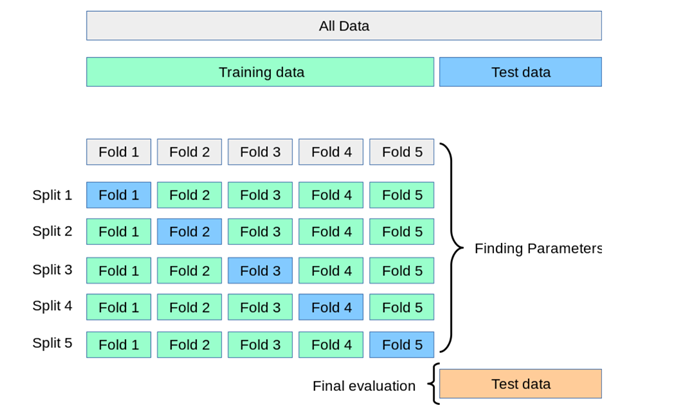

SOURCE: Scikit-learn docs regarding cross-validation diagram found here: https://scikit-learn.org/stable/modules/cross_validation.html

### Step 3 - Initial model shrinkage

For the model building process, we're going to use cross validation with the default settings for each of the following model shrinkage methods using the default settings in Scikit-learn. (k = 5) is the default, and it can be reset with <b>n_splits = 5</b>

- LassoCV
- ElasticNetCV



### Step 4 - Addressing multicolinearity by using the Variance Inflation Factor index (VIF) score

Next we'll shrink the values remaining in from each procedure, by individually removing the highest VIF's scores then recalculating them until we have no VIF scores greater than 10.  This will ensure we have minimized the chance of multicolinearity amoung the exogenous variables we will use in the model.

### Step 5 - Address statistical significance by backward selecting (removing) features.

Next we'll shrink the values remaining from each procedure, by individually removing the features with the highest p-values, then calculating the BIC, AIC, R-squared etc and selecting the best model based on BIC.  

### Step 6 - Select the model with the lowest BIC and run diagnostic plots.
- Predcited vs. Actual
- Studentized Residuals vs. Cook's Distance (to check for leverage points.)
- Studentized Residuals Plot (Check for model validity)
- Leverage Plots (Impact of each parameter on the model)
- Marginal Model Plots (Make sure that the underlying distribution of each column of data is accounted for.)

### LASSO 


---TRAIN SET-----




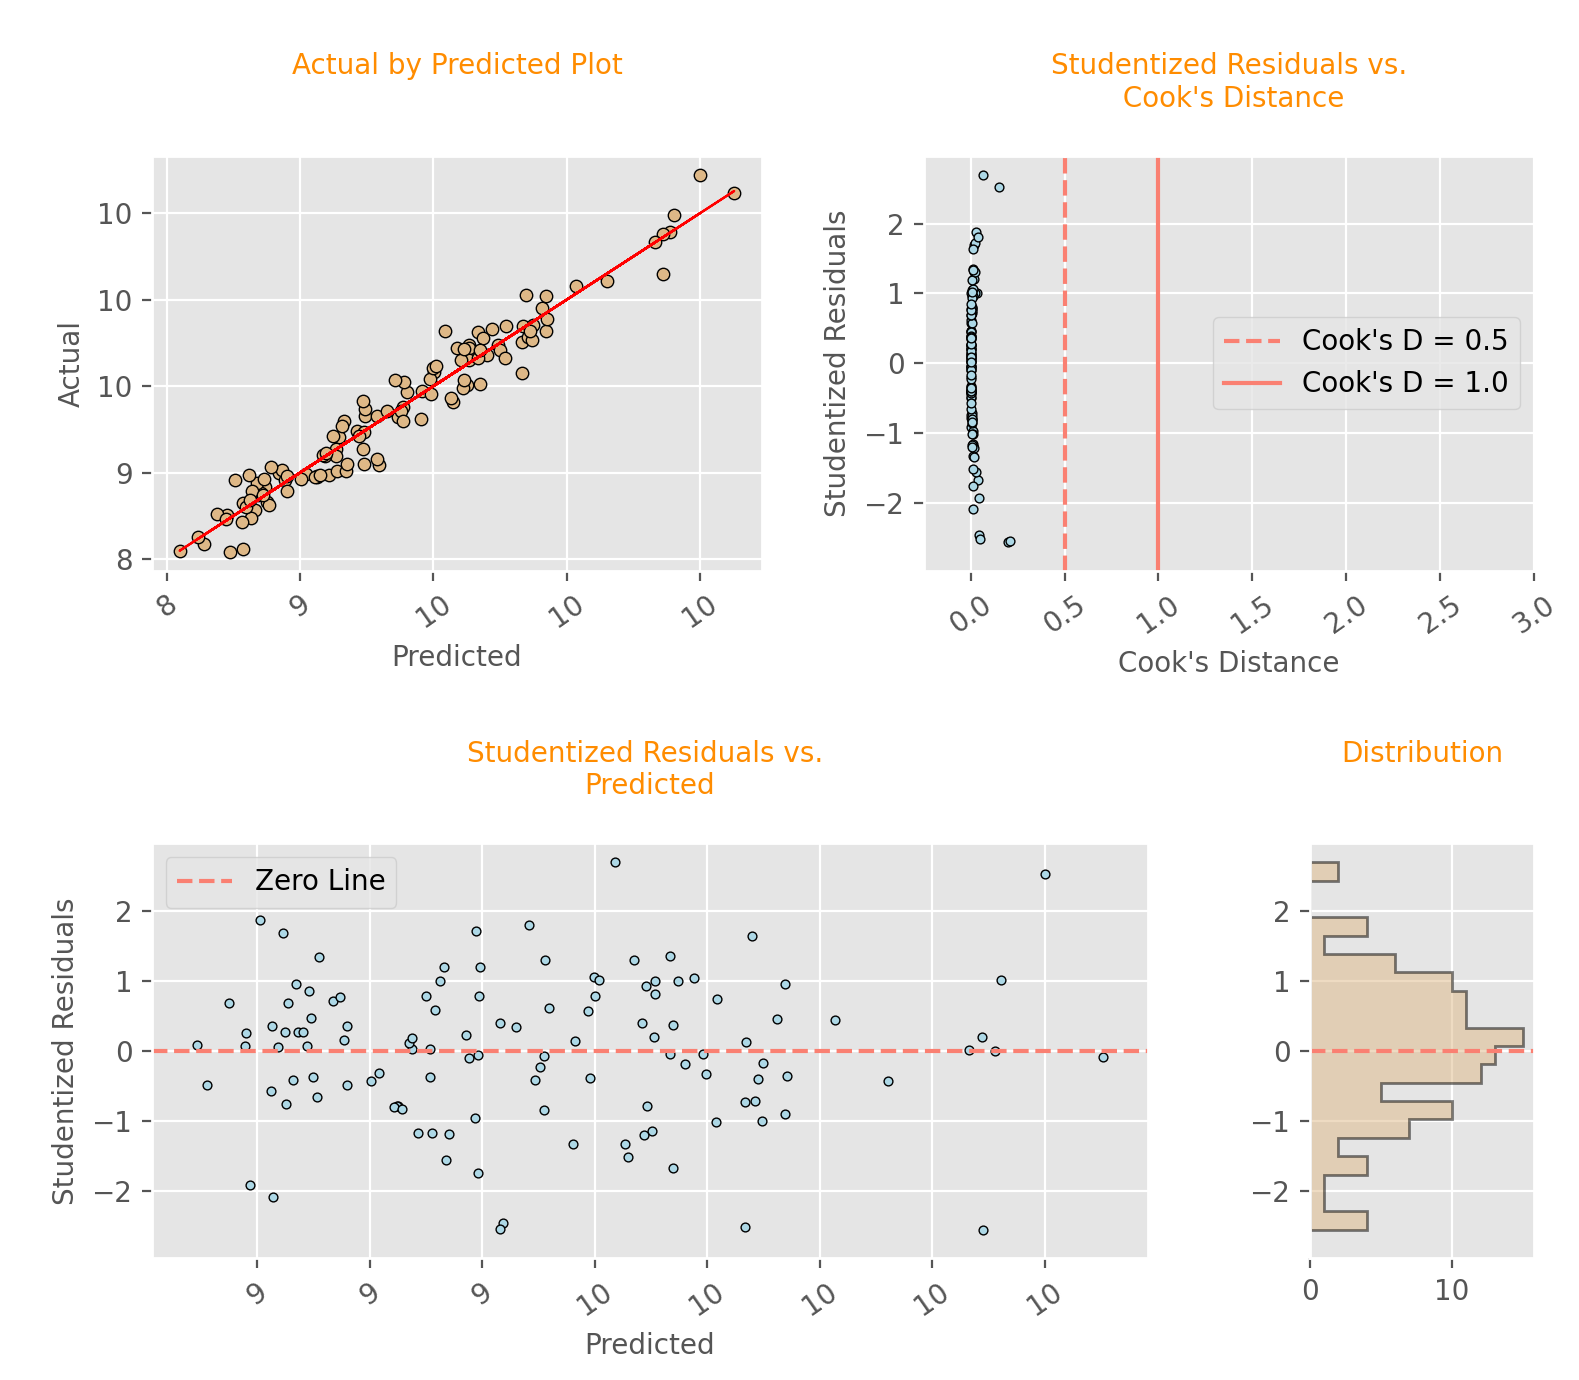

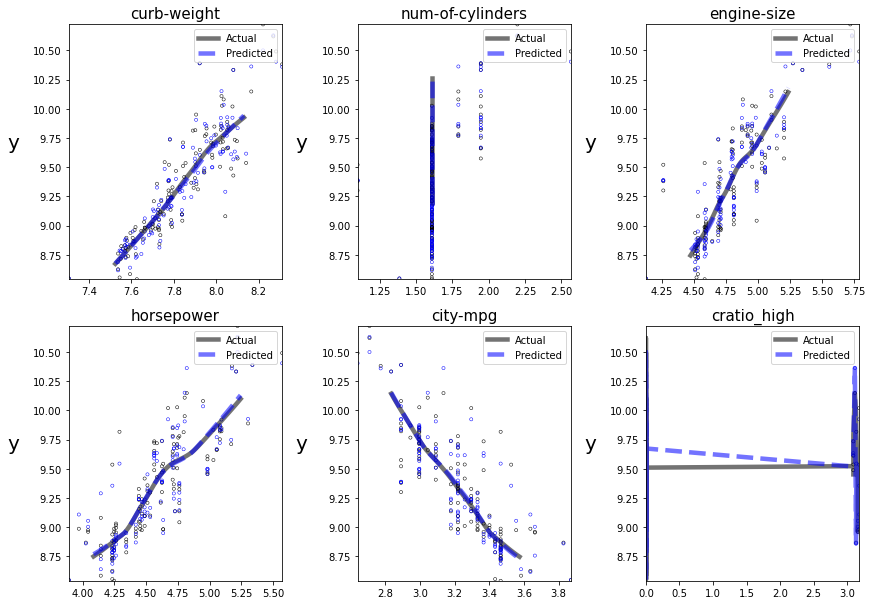

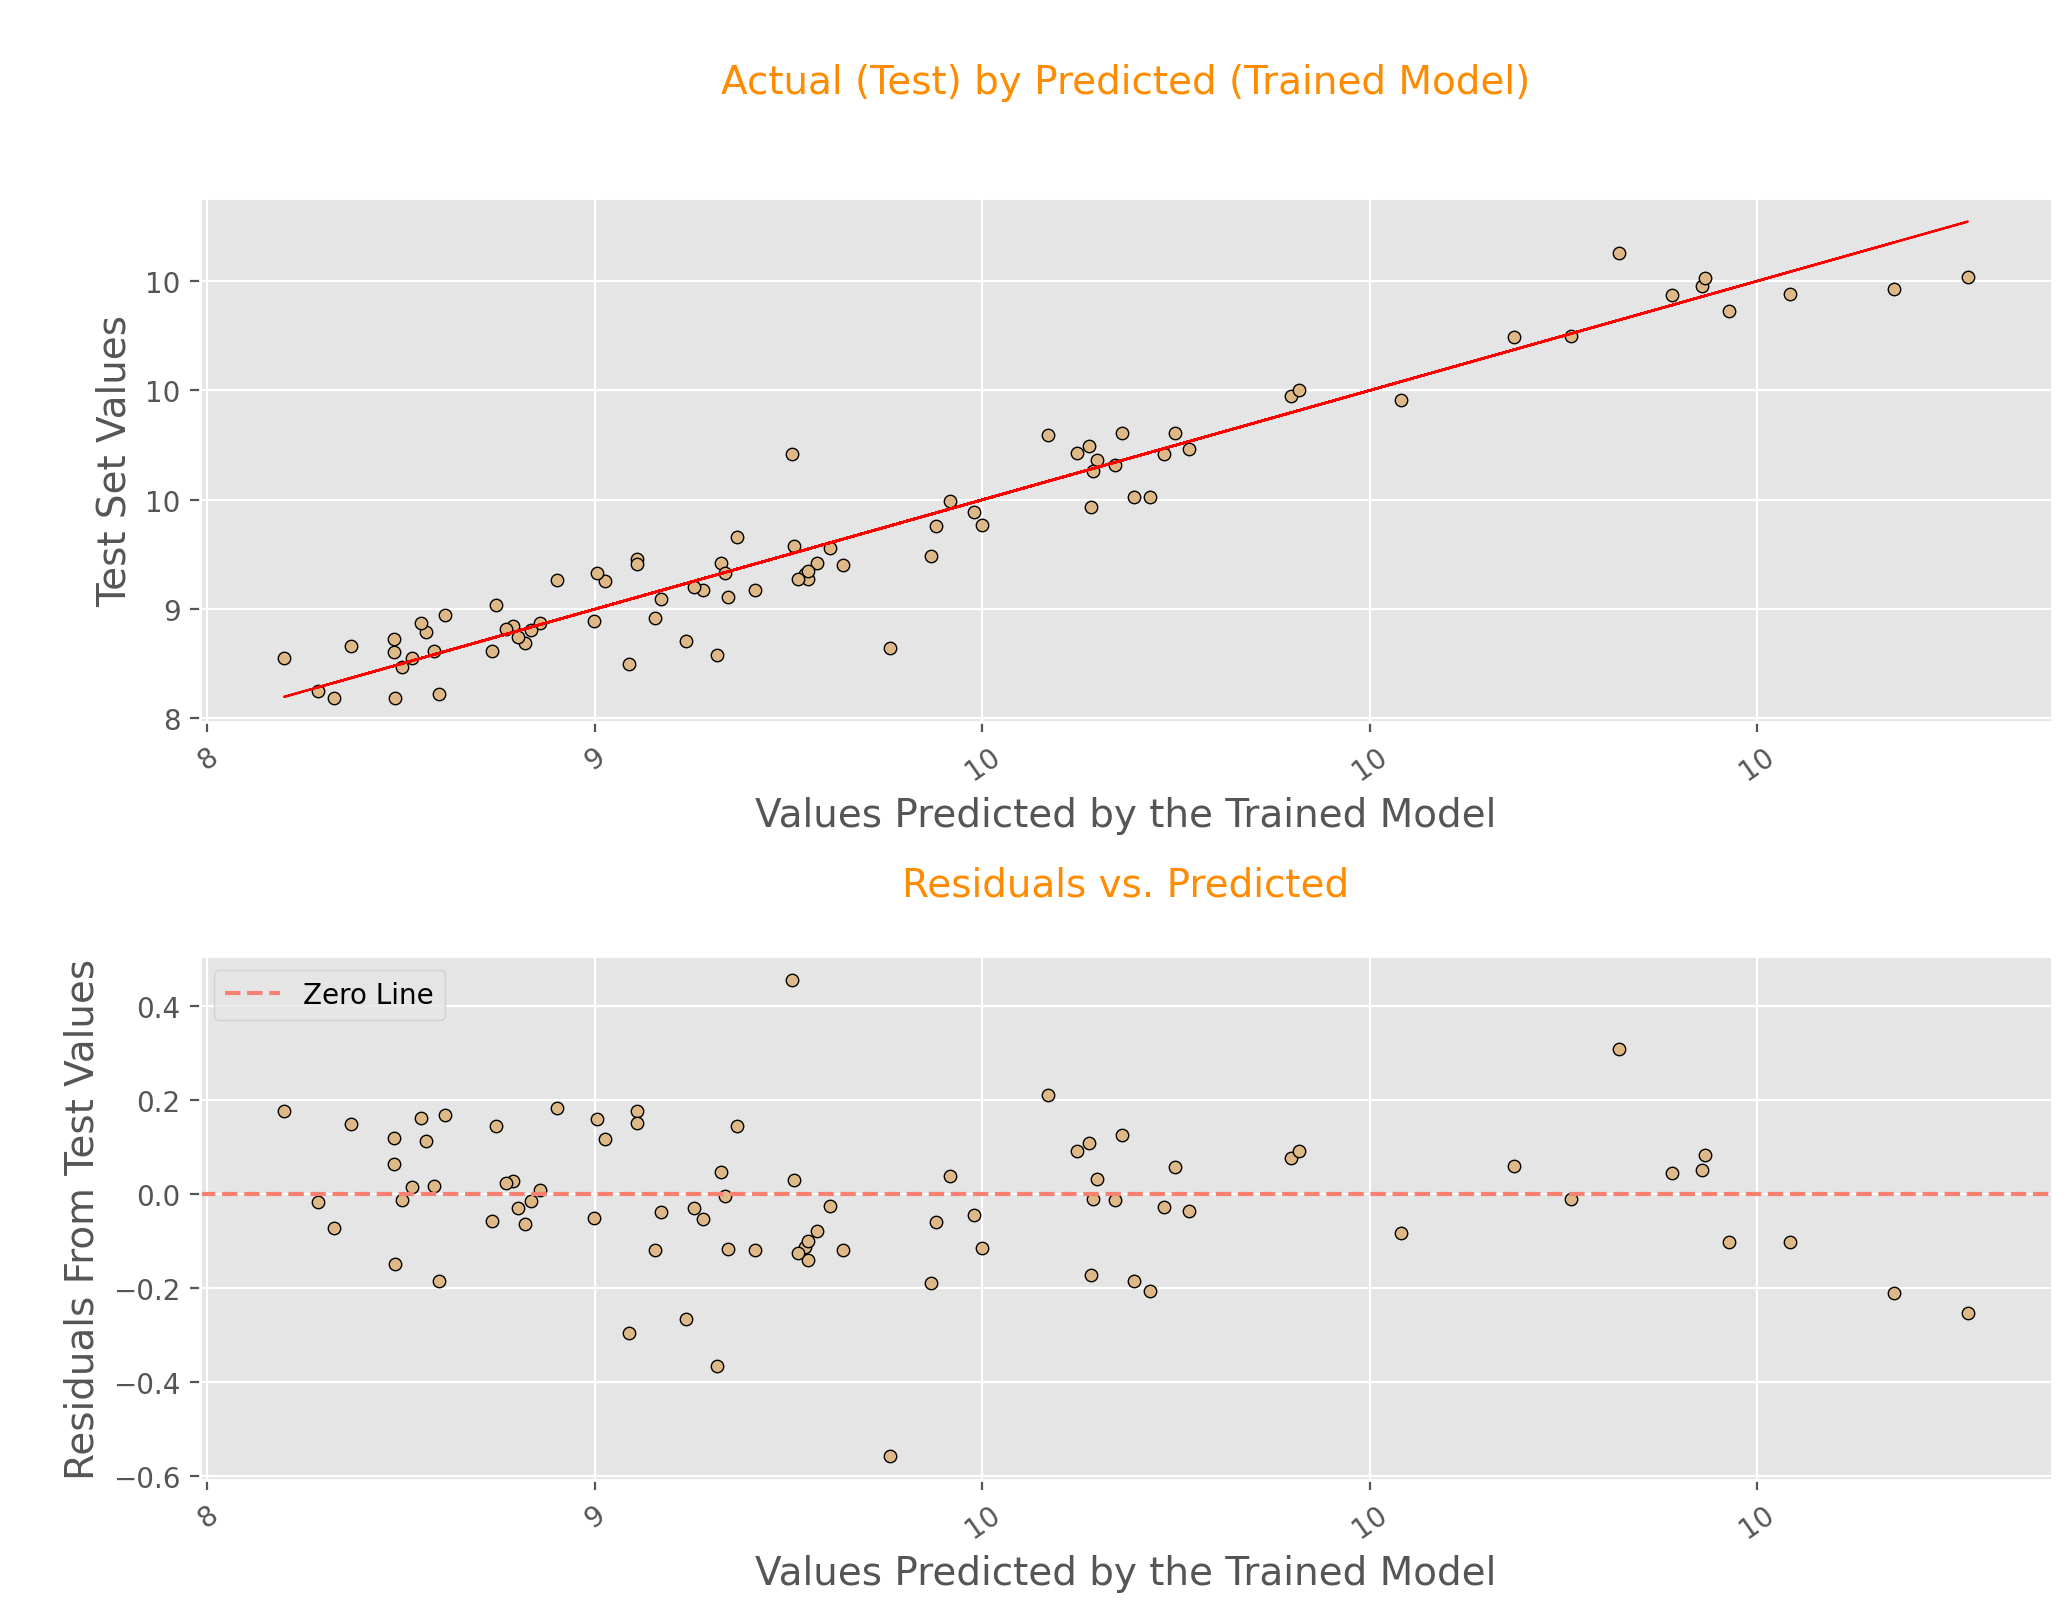

In [29]:
lasso_features_list = lasso_selector(X,
                                     y,
                                     test_size = 0.40,
                                     kfolds = 5, 
                                     random_state = 42, 
                                     display_summary_of_fit=False,
                                     display_analysis_of_variance=False, 
                                     display_parameter_estimates=True,
                                     display_diagnostic_plots=True,
                                     display_leverage_plots=False, 
                                     display_marginal_model_plots=True
                                    )

### LASSO / Reduce VIFS after the LASSO selectio individually until they are all below 10.

In [30]:
def reduce_vifs(X, max_vif = 10):
    
    new_vifs = get_vifs(X_train)

    for check in range(0, len(new_vifs)):    
        cols = [col for col in new_vifs.index.to_list() if col != 'const']
        vifs = get_vifs(X_train[cols])

        if vifs.max() >= 10:

            new_vifs = vifs.loc[vifs < vifs.max()]
        else:
            break
          
    cols = [val for val in vifs.index.to_list() if val != 'const']
    
    return X[cols]

In [31]:
#The LassoCV method already uses a train / test split so we need to duplicate it here. 

X_train, X_test, y_train, y_test = train_test_split(mod_df[lasso_features_list], y, test_size=0.40, random_state=42)

# get the VIF scores from the training data and remove the const / "intercept" column 
lasso_vifs_reduced = reduce_vifs(X_train)
lasso_vifs_reduced = get_vifs(lasso_vifs_reduced)
lasso_reduced_vif_X = X_train[[val for val in lasso_vifs_reduced.index.to_list() if val != 'const']]
lasso_vifs_reduced 

const                          NaN
city-mpg                  8.652966
cratio_high               1.967870
make_audi                 1.348230
make_bmw                  1.219544
make_chevrolet            1.128616
make_dodge                1.272019
make_mercedes-benz        1.160728
make_mitsubishi           1.176791
make_peugot               1.473817
make_plymouth             1.110674
make_porsche              1.077170
make_subaru               1.264611
make_toyota               1.542633
make_volkswagen           1.646175
num-of-doors_four         4.931566
body-style_convertible    1.302217
body-style_hatchback      3.160210
body-style_wagon          1.566821
drive-wheels_rwd          3.478441
fuel-system_mpfi          4.221976
Name: VIF, dtype: float64

### Use backwards stepwise selection to remove all p-values that are not significant, then selecting the best one based on BIC.

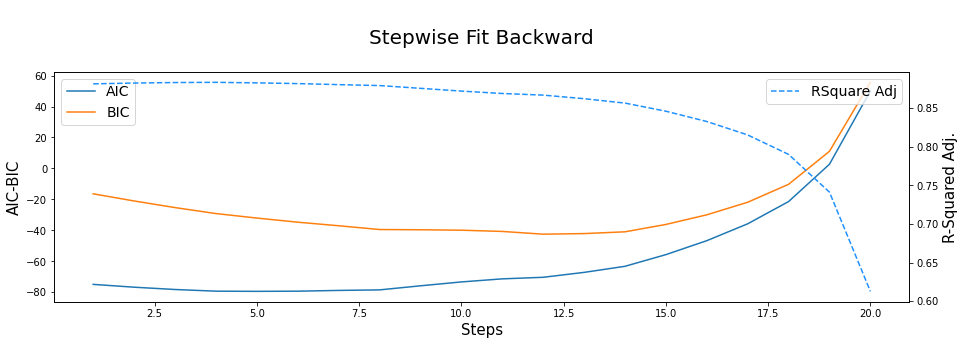

Step               Parameter    Action  Sig Prob        AIC       AICc  \
0      1                     All   Entered  0.703943 -74.974315 -65.545744   
1      2         make_mitsubishi   Removed  0.515852 -76.798396 -68.313548   
2      3    body-style_hatchback   Removed  0.379671 -78.289244 -70.689244   
3      4        body-style_wagon   Removed  0.206896 -79.367747 -72.595470   
4      5  body-style_convertible   Removed  0.179580 -79.484416 -73.484416   
5      6               make_audi   Removed  0.142620 -79.375854 -74.094300   
6      7           make_plymouth   Removed  0.153202 -78.883774 -74.268390   
7      8              make_dodge   Removed  0.043488 -78.541146 -74.541146   
8      9             make_toyota   Removed  0.045527 -75.904690 -72.470728   
9     10        drive-wheels_rwd   Removed  0.058746 -73.398887 -70.482999   
10    11       num-of-doors_four   Removed  0.098880 -71.411149 -68.966704   
11    12             make_peugot   Removed  0.029840 -70.399033 -68.380685   
12    13             make_subaru   Removed  0.019436 -67.228202 -65.591839   
13    14         make_volkswagen   Removed  0.002896 -63.296976 -61.999679   
14    15            make_porsche   Removed  0.001313 -55.749081 -54.749081   
15    16          make_chevrolet   Removed  0.000474 -46.736935 -45.993572   
16    17                make_bmw   Removed  0.000077 -35.823869 -35.297553   
17    18      make_mercedes-benz   Removed  0.000001 -21.443982 -21.096156   
18    19        fuel-system_mpfi   Removed  0.000000   2.697285   2.904182   
19    20             cratio_high   Removed  0.000000  50.068401  50.170965   
20    21                    Best  Specific  0.029840 -70.399033 -68.380685   

          BIC  RSquare Adj  \
0  -16.436989     0.881360   
1  -21.048561     0.882374   
2  -25.326901     0.883044   
3  -29.192896     0.883298   
4  -32.097056     0.882603   
5  -34.775986     0.881670   
6  -37.071398     0.880338   
7  -39.516261     0.879130   
8  -39.667298     0.875543   
9  -39.948986     0.871977   
10 -40.748739     0.868866   
11 -42.524116     0.866755   
12 -42.140777     0.862141   
13 -40.997042     0.856449   
14 -36.236639     0.845936   
15 -30.011984     0.832610   
16 -21.886410     0.815214   
17 -10.294015     0.790014   
18  11.059760     0.741137   
19  55.643384     0.612694   
20 -42.524116     0.866755   

                                                                                         remaining_cols  
0   [city-mpg, cratio_high, make_audi, make_bmw, make_chevrolet, make_dodge, make_mercedes-benz, mak...  
1   [city-mpg, cratio_high, make_audi, make_bmw, make_chevrolet, make_dodge, make_mercedes-benz, mak...  
2   [city-mpg, cratio_high, make_audi, make_bmw, make_chevrolet, make_dodge, make_mercedes-benz, mak...  
3   [city-mpg, cratio_high, make_audi, make_bmw, make_chevrolet, make_dodge, make_mercedes-benz, mak...  
4   [city-mpg, cratio_high, make_audi, make_bmw, make_chevrolet, make_dodge, make_mercedes-benz, mak...  
5   [city-mpg, cratio_high, make_bmw, make_chevrolet, make_dodge, make_mercedes-benz, make_peugot, m...  
6   [city-mpg, cratio_high, make_bmw, make_chevrolet, make_dodge, make_mercedes-benz, make_peugot, m...  
7   [city-mpg, cratio_high, make_bmw, make_chevrolet, make_mercedes-benz, make_peugot, make_porsche,...  
8   [city-mpg, cratio_high, make_bmw, make_chevrolet, make_mercedes-benz, make_peugot, make_porsche,...  
9   [city-mpg, cratio_high, make_bmw, make_chevrolet, make_mercedes-benz, make_peugot, make_porsche,...  
10  [city-mpg, cratio_high, make_bmw, make_chevrolet, make_mercedes-benz, make_peugot, make_porsche,...  
11  [city-mpg, cratio_high, make_bmw, make_chevrolet, make_mercedes-benz, make_porsche, make_subaru,...  
12  [city-mpg, cratio_high, make_bmw, make_chevrolet, make_mercedes-benz, make_porsche, make_volkswa...  
13  [city-mpg, cratio_high, make_bmw, make_chevrolet, make_mercedes-benz, make_porsche, fuel-system_...  
14              [city-mpg, cratio_hi

In [32]:
lasso_results, lasso_fitted_model, lasso_step_history = forward_backward_selection(
    y = y_train, 
    X = lasso_reduced_vif_X, 
    w=False, 
    method = 'fit_backward', 
    stopping_rule = 'bic')

### Extract best model columns from the backwards stepwise fit.

In [33]:
lasso_best_model_columns = lasso_step_history.iloc[-1][-1]
lasso_best_model_columns

['city-mpg',
 'cratio_high',
 'make_bmw',
 'make_chevrolet',
 'make_mercedes-benz',
 'make_porsche',
 'make_subaru',
 'make_volkswagen',
 'fuel-system_mpfi']

## Elastic Net 


---TRAIN SET-----




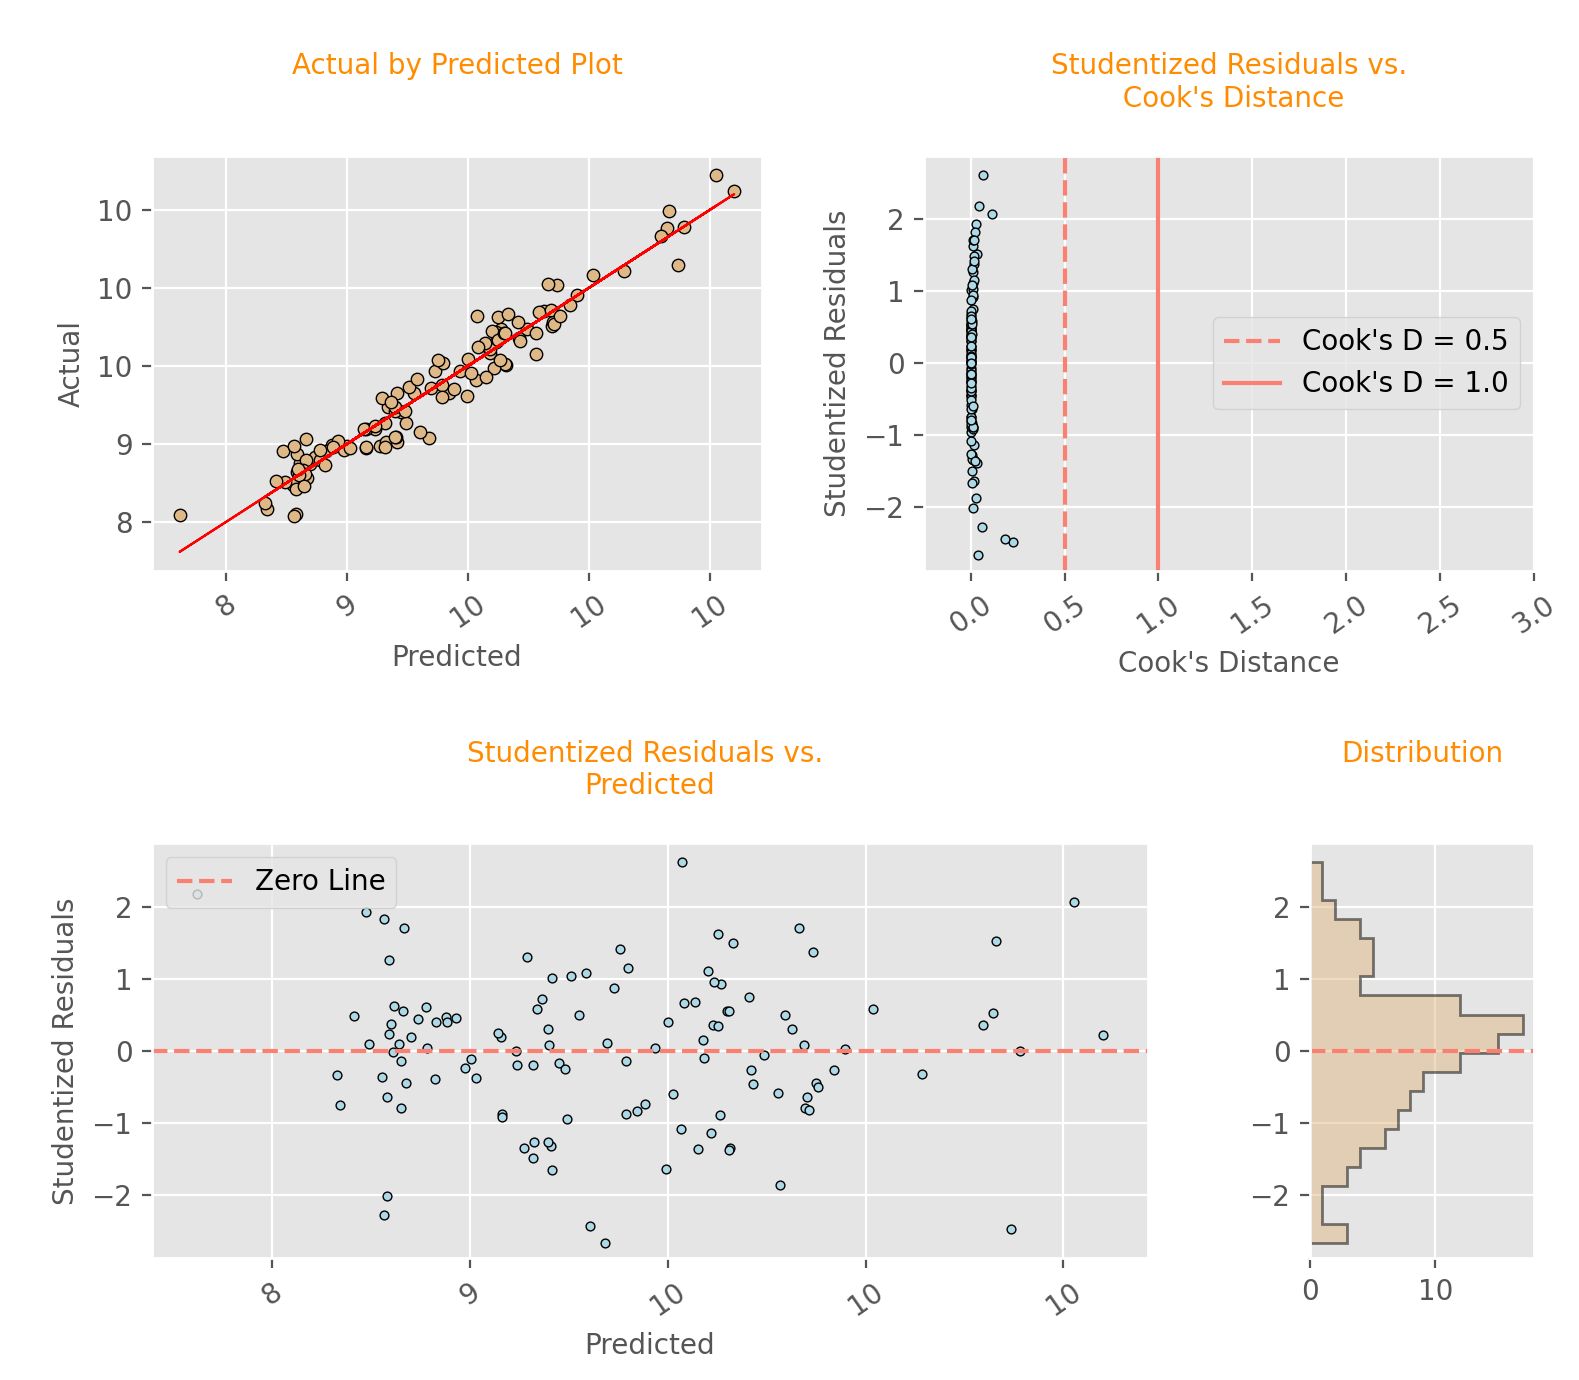

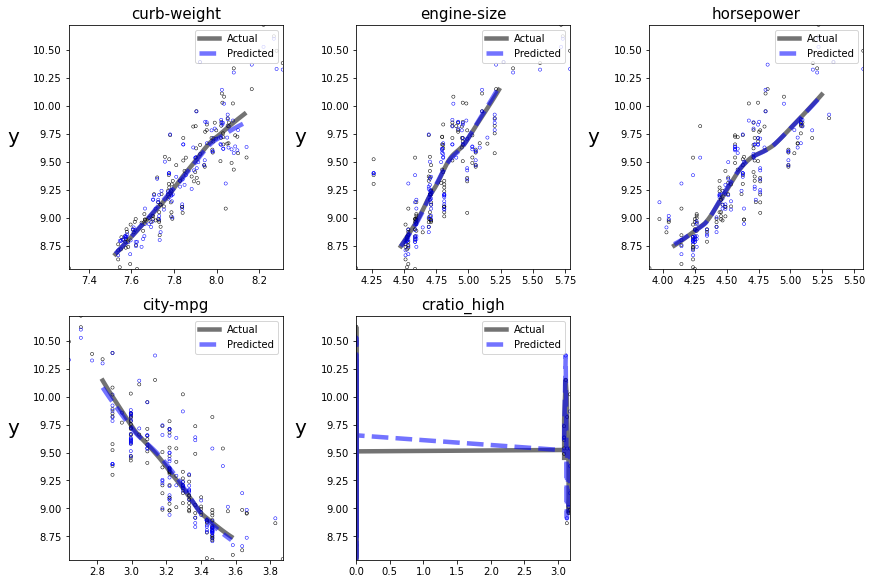

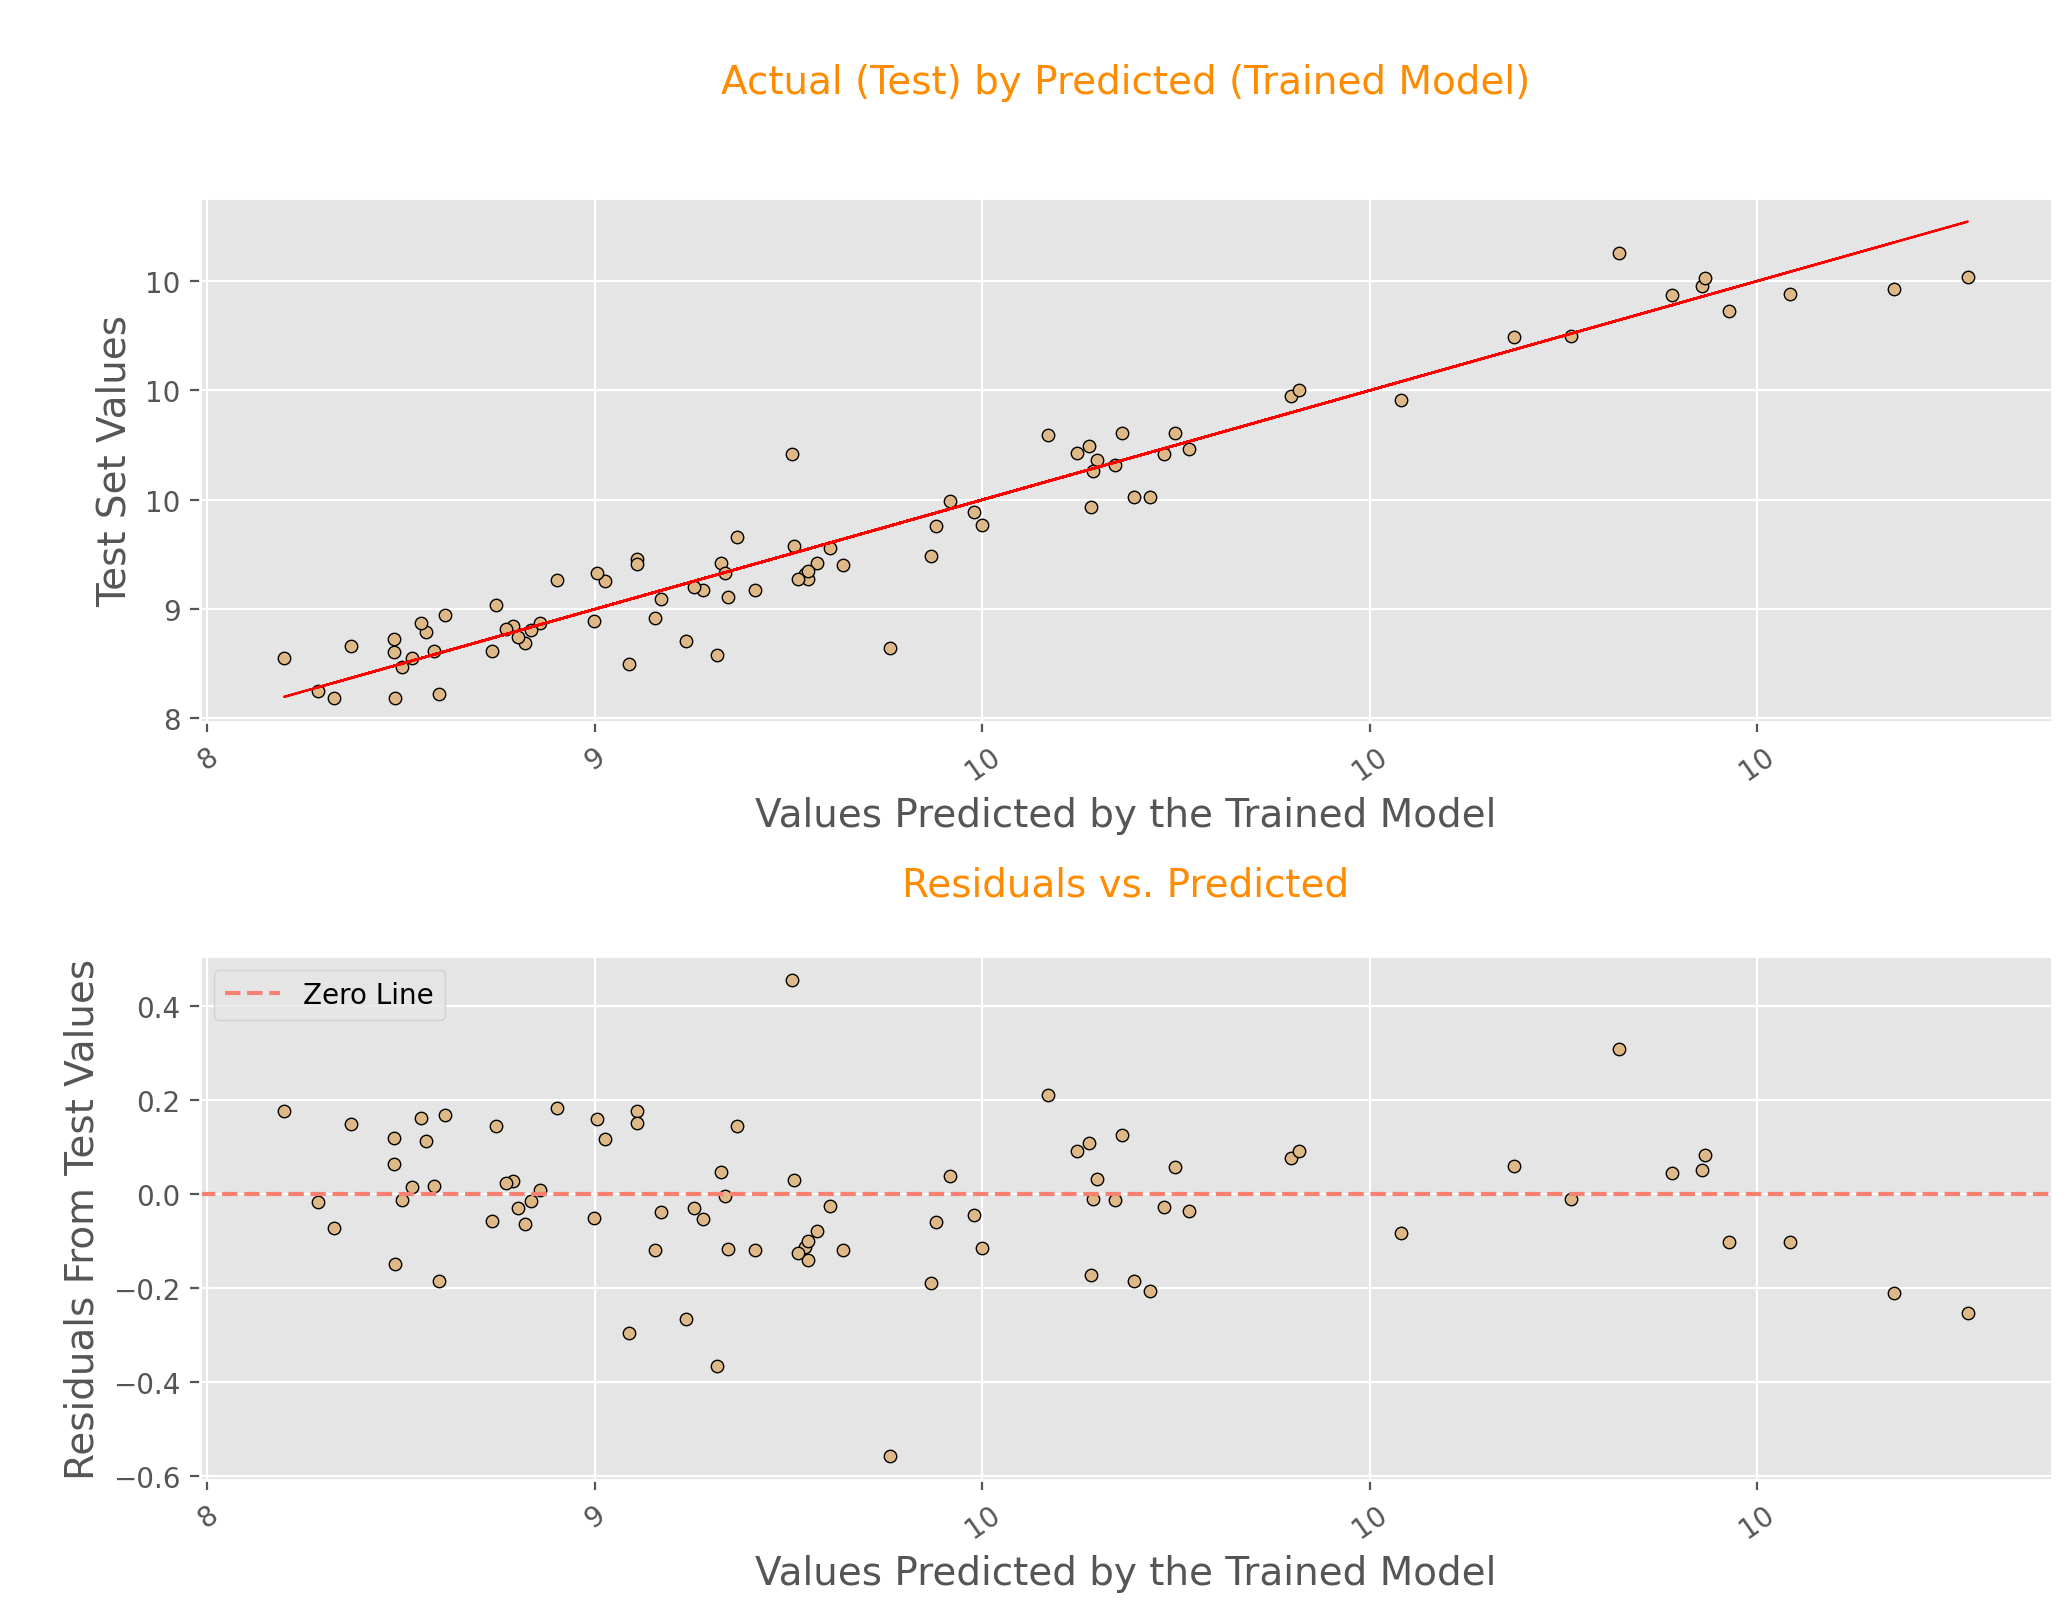

In [34]:
enet_features_list = enet_selector(X,
                                   y,
                                   test_size = 0.40,
                                   kfolds = 5, 
                                   random_state = 42, 
                                   display_summary_of_fit=False,
                                   display_analysis_of_variance=False, 
                                   display_parameter_estimates=True,
                                   display_diagnostic_plots=True,
                                   display_leverage_plots=False, 
                                   display_marginal_model_plots=True
                                  )

### ELASTIC-NET /Reduce VIFS after the ELASTIC-NET selection individually until they are all below 10.

In [35]:
#The LassoCV method already uses a train / test split so we need to duplicate it here. 

X_train, X_test, y_train, y_test = train_test_split(mod_df[enet_features_list], y, test_size=0.40, random_state=42)

# get the VIF scores from the training data and remove the const / "intercept" column 
enet_vifs_reduced = reduce_vifs(X_train)
enet_vifs_reduced = get_vifs(enet_vifs_reduced)
enet_reduced_vif_X = X_train[[val for val in enet_vifs_reduced.index.to_list() if val != 'const']]
enet_vifs_reduced 

const                          NaN
city-mpg                  2.786648
cratio_high               1.562193
make_audi                 1.221299
make_bmw                  1.174201
make_dodge                1.175411
make_mercedes-benz        1.143028
make_peugot               1.428487
make_plymouth             1.085674
make_subaru               1.201459
make_toyota               1.402956
body-style_convertible    1.119306
body-style_wagon          1.353112
drive-wheels_rwd          2.689272
fuel-system_mpfi          2.940234
Name: VIF, dtype: float64

### Elastic Net - All possible models on remaining values to minimize BIC.

In [36]:
# #The LassoCV method already uses a train / test split so we need to duplicate it here. 

# X_train, X_test, y_train, y_test = train_test_split(mod_df[enet_features_list], y, test_size=0.40, random_state=42)

# # get the VIF scores from the training data and remove the const / "intercept" column 
# enet_vifs = get_vifs(mod_df[enet_features_list]) 
# cols = [val for val in enet_vifs.index.to_list() if val != 'const']

# #select training data with columns that have VIF scores lower than 10.
# enet_reduced_vif_X = X_train[cols]

# # display the VIF scores to confirm.
# get_vifs(enet_reduced_vif_X)

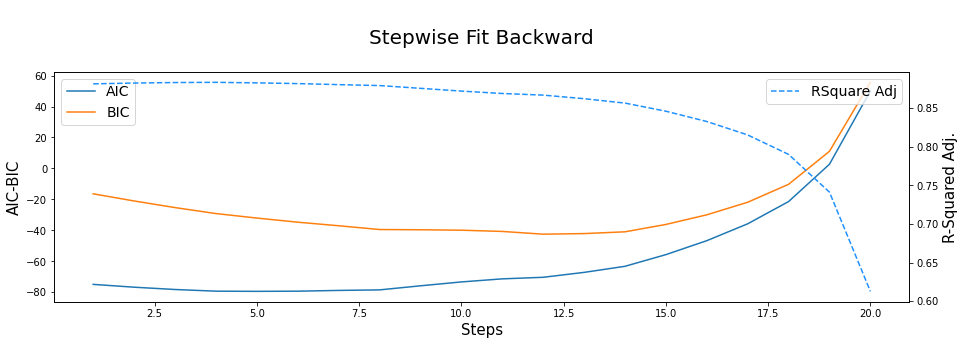

Step               Parameter    Action  Sig Prob        AIC       AICc  \
0      1                     All   Entered  0.703943 -74.974315 -65.545744   
1      2         make_mitsubishi   Removed  0.515852 -76.798396 -68.313548   
2      3    body-style_hatchback   Removed  0.379671 -78.289244 -70.689244   
3      4        body-style_wagon   Removed  0.206896 -79.367747 -72.595470   
4      5  body-style_convertible   Removed  0.179580 -79.484416 -73.484416   
5      6               make_audi   Removed  0.142620 -79.375854 -74.094300   
6      7           make_plymouth   Removed  0.153202 -78.883774 -74.268390   
7      8              make_dodge   Removed  0.043488 -78.541146 -74.541146   
8      9             make_toyota   Removed  0.045527 -75.904690 -72.470728   
9     10        drive-wheels_rwd   Removed  0.058746 -73.398887 -70.482999   
10    11       num-of-doors_four   Removed  0.098880 -71.411149 -68.966704   
11    12             make_peugot   Removed  0.029840 -70.399033 -68.380685   
12    13             make_subaru   Removed  0.019436 -67.228202 -65.591839   
13    14         make_volkswagen   Removed  0.002896 -63.296976 -61.999679   
14    15            make_porsche   Removed  0.001313 -55.749081 -54.749081   
15    16          make_chevrolet   Removed  0.000474 -46.736935 -45.993572   
16    17                make_bmw   Removed  0.000077 -35.823869 -35.297553   
17    18      make_mercedes-benz   Removed  0.000001 -21.443982 -21.096156   
18    19        fuel-system_mpfi   Removed  0.000000   2.697285   2.904182   
19    20             cratio_high   Removed  0.000000  50.068401  50.170965   
20    21                    Best  Specific  0.029840 -70.399033 -68.380685   

          BIC  RSquare Adj  \
0  -16.436989     0.881360   
1  -21.048561     0.882374   
2  -25.326901     0.883044   
3  -29.192896     0.883298   
4  -32.097056     0.882603   
5  -34.775986     0.881670   
6  -37.071398     0.880338   
7  -39.516261     0.879130   
8  -39.667298     0.875543   
9  -39.948986     0.871977   
10 -40.748739     0.868866   
11 -42.524116     0.866755   
12 -42.140777     0.862141   
13 -40.997042     0.856449   
14 -36.236639     0.845936   
15 -30.011984     0.832610   
16 -21.886410     0.815214   
17 -10.294015     0.790014   
18  11.059760     0.741137   
19  55.643384     0.612694   
20 -42.524116     0.866755   

                                                                                         remaining_cols  
0   [city-mpg, cratio_high, make_audi, make_bmw, make_chevrolet, make_dodge, make_mercedes-benz, mak...  
1   [city-mpg, cratio_high, make_audi, make_bmw, make_chevrolet, make_dodge, make_mercedes-benz, mak...  
2   [city-mpg, cratio_high, make_audi, make_bmw, make_chevrolet, make_dodge, make_mercedes-benz, mak...  
3   [city-mpg, cratio_high, make_audi, make_bmw, make_chevrolet, make_dodge, make_mercedes-benz, mak...  
4   [city-mpg, cratio_high, make_audi, make_bmw, make_chevrolet, make_dodge, make_mercedes-benz, mak...  
5   [city-mpg, cratio_high, make_bmw, make_chevrolet, make_dodge, make_mercedes-benz, make_peugot, m...  
6   [city-mpg, cratio_high, make_bmw, make_chevrolet, make_dodge, make_mercedes-benz, make_peugot, m...  
7   [city-mpg, cratio_high, make_bmw, make_chevrolet, make_mercedes-benz, make_peugot, make_porsche,...  
8   [city-mpg, cratio_high, make_bmw, make_chevrolet, make_mercedes-benz, make_peugot, make_porsche,...  
9   [city-mpg, cratio_high, make_bmw, make_chevrolet, make_mercedes-benz, make_peugot, make_porsche,...  
10  [city-mpg, cratio_high, make_bmw, make_chevrolet, make_mercedes-benz, make_peugot, make_porsche,...  
11  [city-mpg, cratio_high, make_bmw, make_chevrolet, make_mercedes-benz, make_porsche, make_subaru,...  
12  [city-mpg, cratio_high, make_bmw, make_chevrolet, make_mercedes-benz, make_porsche, make_volkswa...  
13  [city-mpg, cratio_high, make_bmw, make_chevrolet, make_mercedes-benz, make_porsche, fuel-system_...  
14              [city-mpg, cratio_hi

In [37]:
enet_results, enet_fitted_model, enet_step_history = forward_backward_selection(
    y = y_train, 
    X = lasso_reduced_vif_X, 
    w=False, 
    method = 'fit_backward', 
    stopping_rule = 'bic')

In [38]:
enet_best_model_columns = enet_step_history.iloc[-1][-1]
enet_best_model_columns

['city-mpg',
 'cratio_high',
 'make_bmw',
 'make_chevrolet',
 'make_mercedes-benz',
 'make_porsche',
 'make_subaru',
 'make_volkswagen',
 'fuel-system_mpfi']

### Step 6 - Select the model with the lowest BIC and run diagnostic plots.
- Predcited vs. Actual
- Studentized Residuals vs. Cook's Distance (to check for leverage points.)
- Studentized Residuals Plot (Check for model validity)
- Leverage Plots (Impact of each parameter on the model)
- Marginal Model Plots (Make sure that the underlying distribution of each column of data is accounted for.)  

### SAME MODEL SELECTED AFTER LASSO AND ENET REDUCTION! 

In [39]:
print(lasso_best_model_columns)
print(enet_best_model_columns)

['city-mpg', 'cratio_high', 'make_bmw', 'make_chevrolet', 'make_mercedes-benz', 'make_porsche', 'make_subaru', 'make_volkswagen', 'fuel-system_mpfi']
['city-mpg', 'cratio_high', 'make_bmw', 'make_chevrolet', 'make_mercedes-benz', 'make_porsche', 'make_subaru', 'make_volkswagen', 'fuel-system_mpfi']


In [40]:
X_train, X_test, y_train, y_test = train_test_split(mod_df[lasso_best_model_columns], y, test_size=0.40, random_state=42)

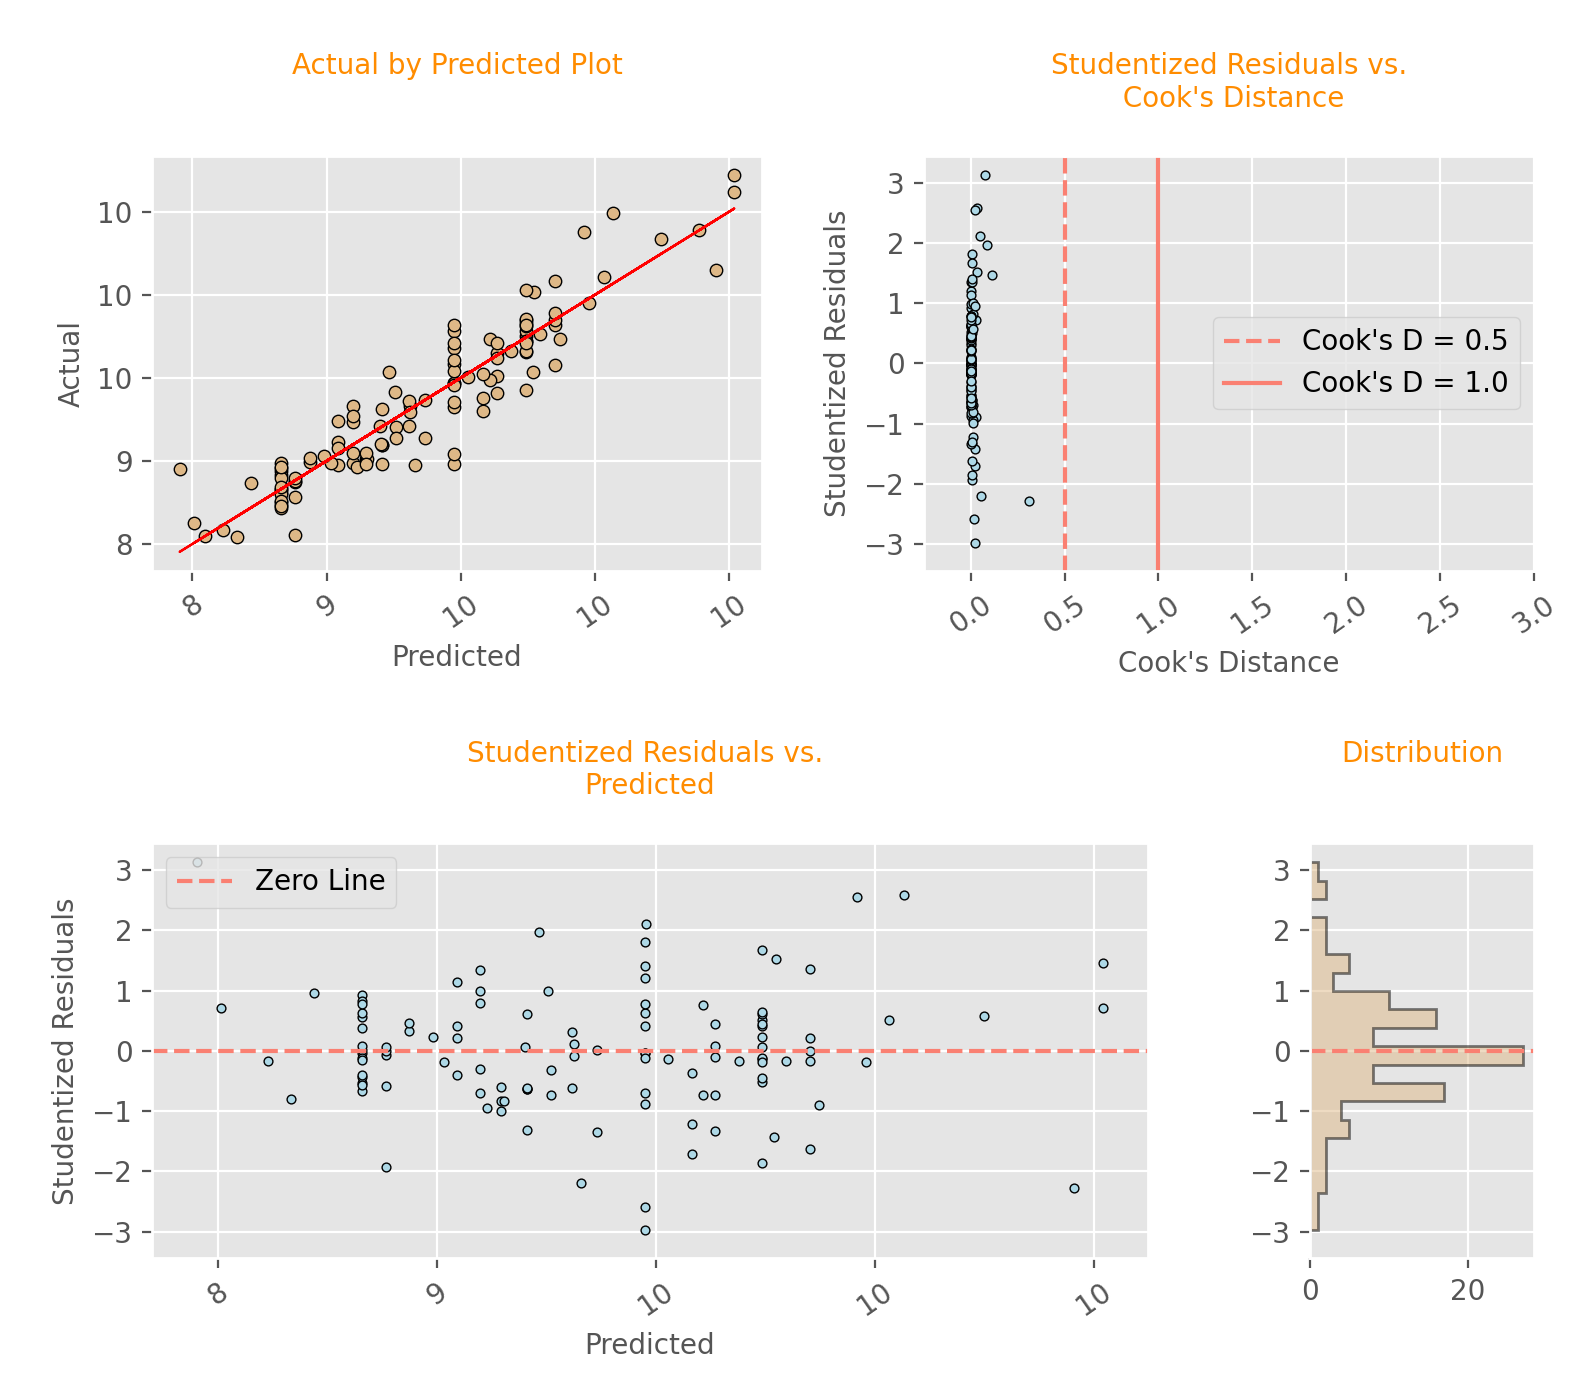

In [41]:
results_train, fitted_ols_model_train = ols_regression(
    y=y_train,
    X=X_train,
    add_intercept=True,
    display_summary_of_fit=True,
    display_analysis_of_variance=True,
    display_parameter_estimates=True,
    display_diagnostic_plots=True,
    display_leverage_plots=False,
    display_marginal_model_plots=False,
    return_data=True
)

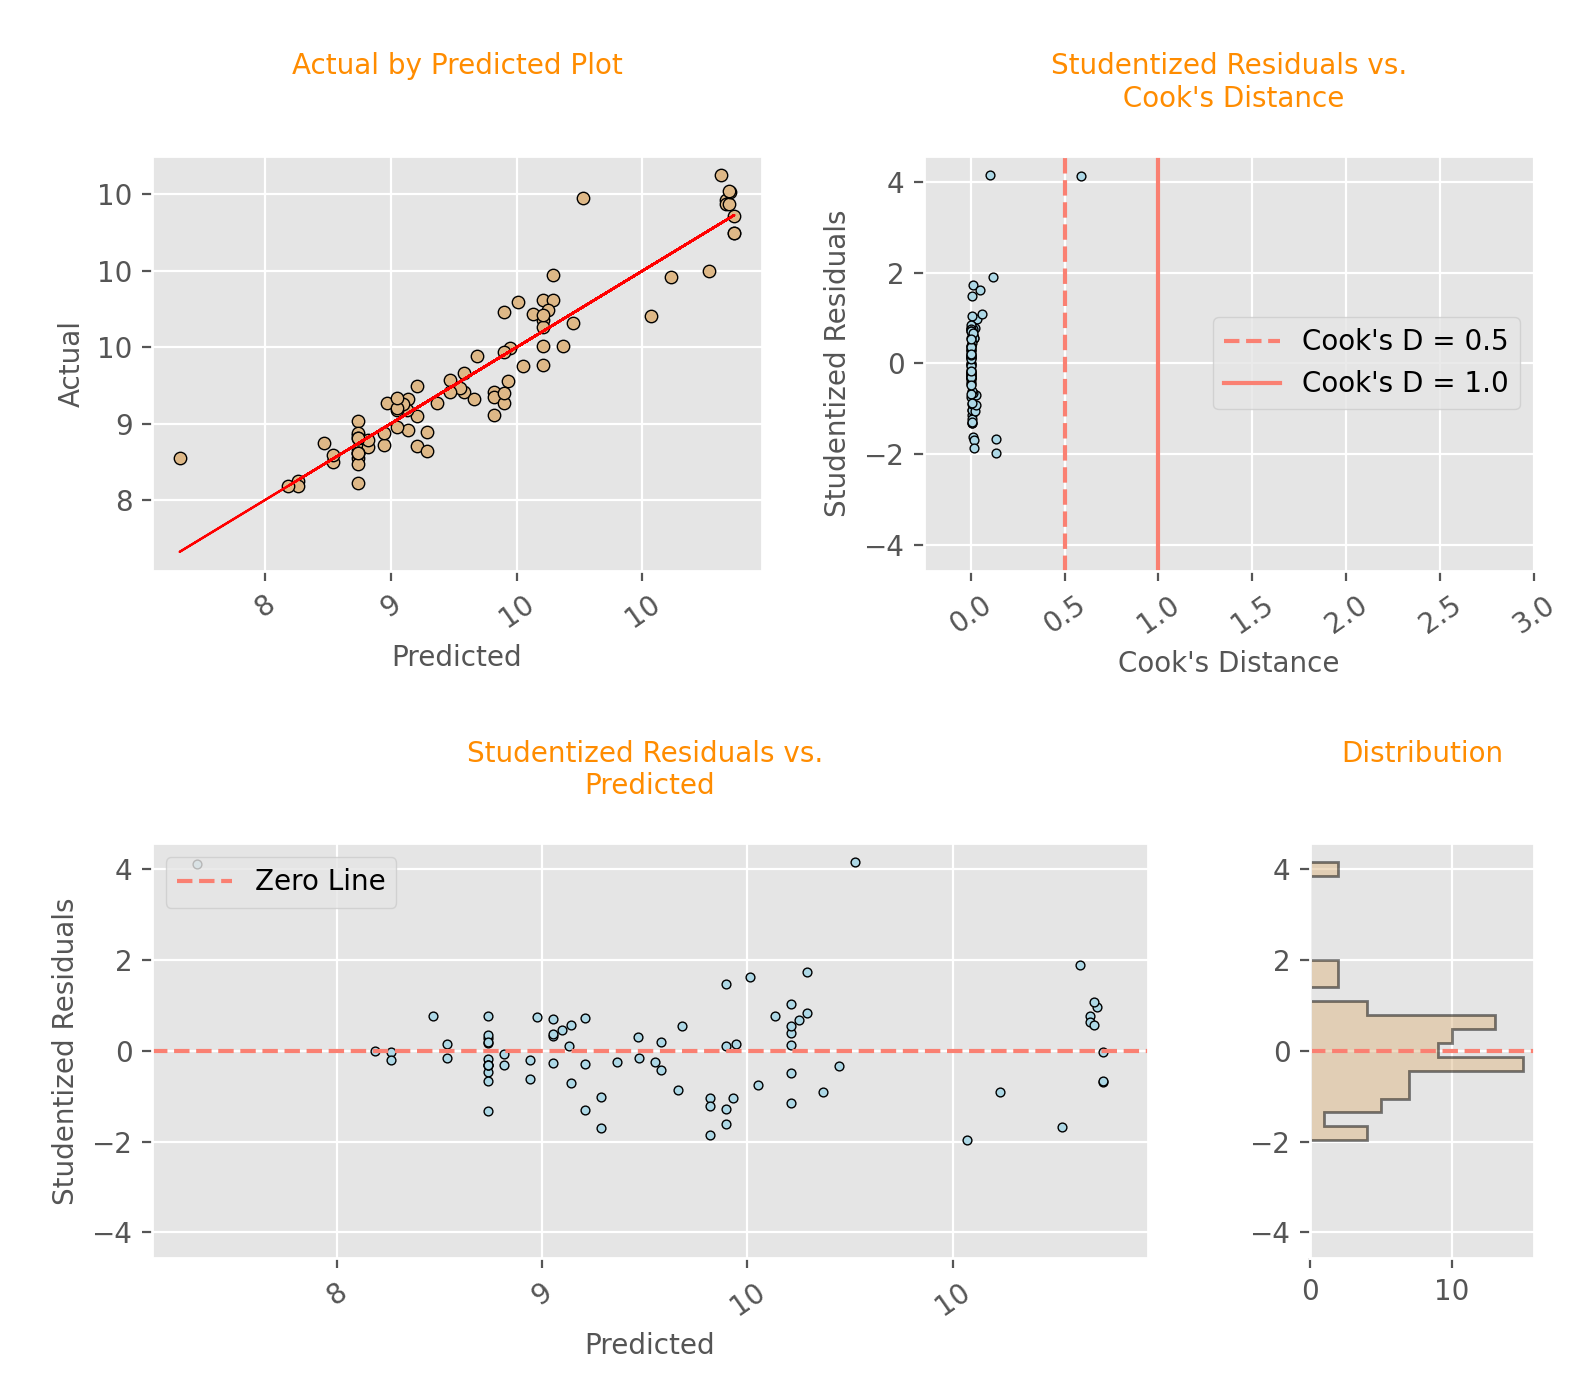

In [42]:
results_test, fitted_ols_model_test = ols_regression(
    y=y_test,
    X=X_test,
    add_intercept=True,
    display_summary_of_fit=True,
    display_analysis_of_variance=True,
    display_parameter_estimates=True,
    display_diagnostic_plots=True,
    display_leverage_plots=False,
    display_marginal_model_plots=False,
    return_data=True
)

# MODEL INTERPRETATION

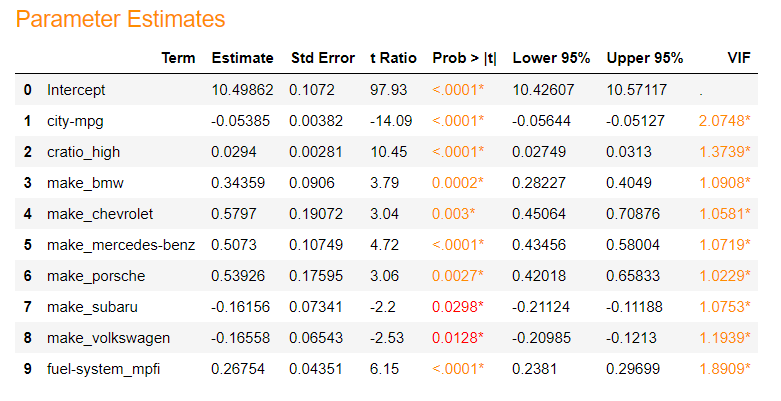

## Model Form

$$log(y) = {\beta}_{0}+{\beta}_{1}\times\log(x_{1})+{\beta}_{2}\times\log(x_{2})+{\beta}_{3}\times\log(x_{3})+{\beta}_{4}\times\log(x_{4})+{\beta}_{5}\times\log(x_{5})+{\beta}_{6}\times\log(x_{6})$$
$$+{\beta}_{7}\times\log(x_{7})+{\beta}_{8}\times\log(x_{8})+{\beta}_{9}\times\log(x_{9})$$

## Final Model

$$log(y) = {10.0882}{-0.03935}\times\ log(city-mpg)+{0.02476}\times\log(cratio-high)+{0.58711}\times\log(make_bmw)+{0.5797}\times\log(make-chevrolet)$$
$$+{0.5073}\times\log(make-mercedes-benz)+{0.53926}\times\log(make-porshce)-{0.16156}\times\log(make-subaru)$$$$-{0.16558}\times\log(make-volkswagen)+{0.26754}\times\log(fuel-system-mpfi)$$

## Here are the percentage effects of each feature on the final price of each vehicle.

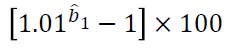

In [43]:
estimates = fitted_ols_model_test.params
percents_list=[]
for coeff in estimates:
    perc = round(((1.01**coeff)-1)*100,2)
    percents_list.append(perc)
percentage_effects = pd.DataFrame({'Estimates':estimates, 'Percentage Effects':percents_list})
percentage_effects

Estimates  Percentage Effects
const               10.088200               10.56
city-mpg            -0.039349               -0.04
cratio_high          0.024756                0.02
make_bmw             0.587109                0.59
make_chevrolet       0.176498                0.18
make_mercedes-benz   0.609885                0.61
make_porsche         0.660335                0.66
make_subaru         -0.094241               -0.09
make_volkswagen     -0.131973               -0.13
fuel-system_mpfi     0.264664                0.26